In [1]:
# Coimbra dataset(blood Analysis)

In [2]:
# importing packages and Libraries
#  For data analysis and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For ML  models 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from collections import OrderedDict

In [3]:
# Importing dataset
coimbra = pd.read_csv('coimbra.csv')

In [4]:
# Data analysis and preprocessing

In [5]:
# Number of features, instances and data types in the dataset
print("Total instances",coimbra.shape[0])
print("Total number of features are ", coimbra.shape[1])
print("Data Types:", coimbra.dtypes)

Total instances 116
Total number of features are  10
Data Types: Age                 int64
BMI               float64
Glucose             int64
Insulin           float64
HOMA              float64
Leptin            float64
Adiponectin       float64
Resistin          float64
MCP.1             float64
Classification      int64
dtype: object


In [6]:
#Checking class labels and distribution 
class_counts= coimbra['Classification'].value_counts()
print(class_counts)

2    64
1    52
Name: Classification, dtype: int64


In [7]:
# Class label mapping 
data_target= coimbra['Classification'].map({1: 0, 2: 1})

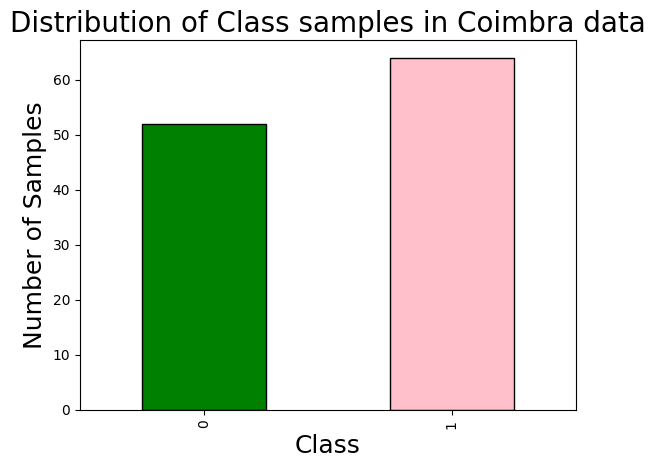

In [8]:
#visualizing class distribution in the dataset
class_distributions = data_target.value_counts().sort_index() 
class_distributions.plot(kind='bar', color=['green', 'pink'], edgecolor="black")
plt.xlabel("Class", fontsize=18)
plt.ylabel("Number of Samples", fontsize=18)
plt.title("Distribution of Class samples in Coimbra data", fontsize=20)
plt.show()


In [9]:
#checking missing values
missing_data= coimbra.isnull().sum()
print(missing_data)

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64


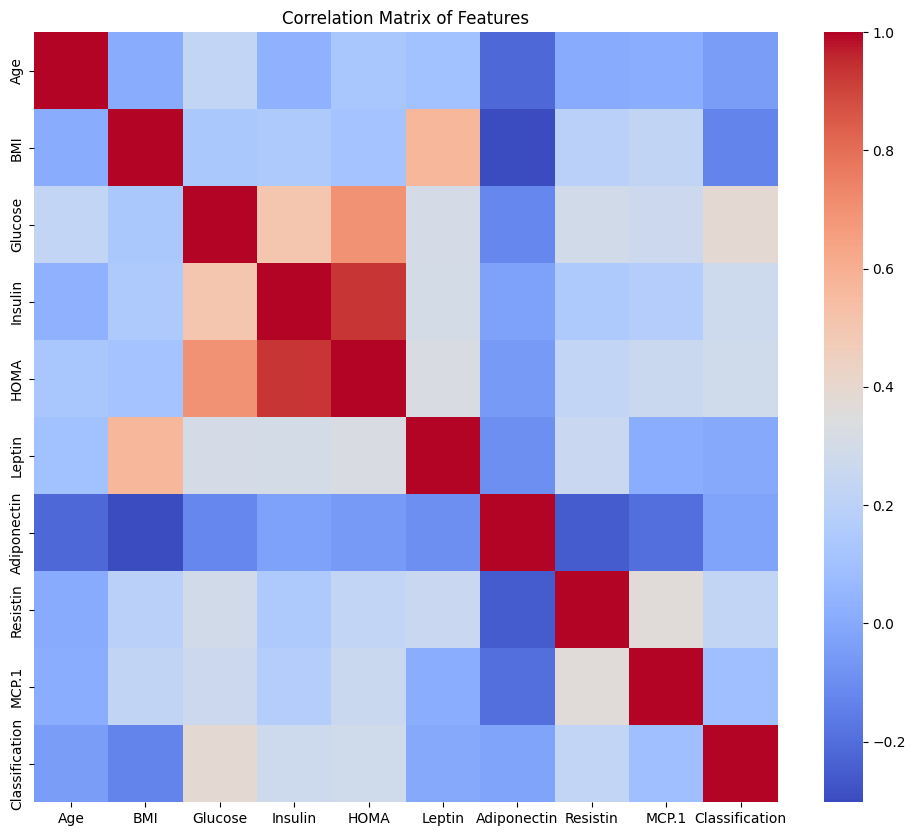

In [10]:
#checking features correlation
correlation_matrix = coimbra.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [11]:
correlation_threshold = 0.8
correlated_features = {}
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2:
            correlation_value = correlation_matrix.loc[feature1, feature2]
            if abs(correlation_value) > correlation_threshold:
                if feature1 not in correlated_features:
                    correlated_features[feature1] = [feature2]
                else:
                    correlated_features[feature1].append(feature2)
for feature, correlated_list in correlated_features.items():
    print(f"{feature} is correlated with: {', '.join(correlated_list)}")

Insulin is correlated with: HOMA
HOMA is correlated with: Insulin


In [12]:
#Feature selection ('Insulin' and 'HOMA' are highly correlated, so decided on droping Insulin feature)
feature_selected=coimbra.drop(['Insulin'], axis=1) 

In [13]:
# Split 80:20
X = feature_selected.drop([ 'Classification'], axis=1)
y = data_target
RANDOM_STATE=123
feature_names = X.columns 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [14]:
#Normalization after splitting to avoiad data leakage
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform (X_test)

In [15]:
# Ml Models Hyperparameter optimization, training ,testing, performance and Interpretability

In [16]:
# 1.DECISION TREE

# Hyperparameter optimization using Randomized search CV 
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5, 10, 20], 
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
     'min_samples_leaf': [1, 2, 4]
}

search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
   param_distributions=dt_params,  
    cv=5,
    scoring='f1',
    verbose=1
)

# DT training
search_dt.fit(X_train_scaled, y_train)
best_params = search_dt.best_params_
print("Best Parameters:", best_params)
print("Best f1 score for Dt during training: ", search_dt.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'gini'}
Best f1 score for Dt during training:  0.7812865497076024


In [17]:
# DT Testing 
best_dt_model = search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)

# DT Performance Evaluation:
print("\nEvaluation Metrics for dt:")
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_dt)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_dt)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_dt, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test,best_dt_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for dt:
Accuracy: 0.6666666666666666
Precision: 0.7777777777777778
Recall: 0.5384615384615384
F1 Score: 0.6363636363636364
F2 Score: 0.5737704918032787
AUC: 0.6748251748251748


In [18]:
# Test set instance 1 would be used for local Interpretability
instance = X_test.iloc[0]
feature_dict = instance.to_dict()
print("Feature Dictionary:", feature_dict)

Feature Dictionary: {'Age': 86.0, 'BMI': 26.66666667, 'Glucose': 201.0, 'HOMA': 20.6307338, 'Leptin': 47.647, 'Adiponectin': 5.357135, 'Resistin': 24.3701, 'MCP.1': 1698.44}


In [19]:
# as standardized data was used for model training and testing, we need to define scaled data instance for explaianbility as well
instance_to_explain = X_test_scaled[0, :].reshape(1, -1) 

In [20]:
# Model prediction and feature relevance based on decision path - Interpretability
prediction = best_dt_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")

feature_relevance = OrderedDict({feature: 0 for feature in X_test.columns.tolist()})
decision_path = best_dt_model.decision_path(instance_to_explain).toarray()
nodes_in_path = np.where(decision_path[0] == 1)[0]
for node in nodes_in_path:
    feature_index = best_dt_model.tree_.feature[node]
    if feature_index != -1 and feature_index < len(X_test.columns):
        feature_name = X_test.columns[feature_index]
        feature_relevance[feature_name] += 1

Model Prediction: 1


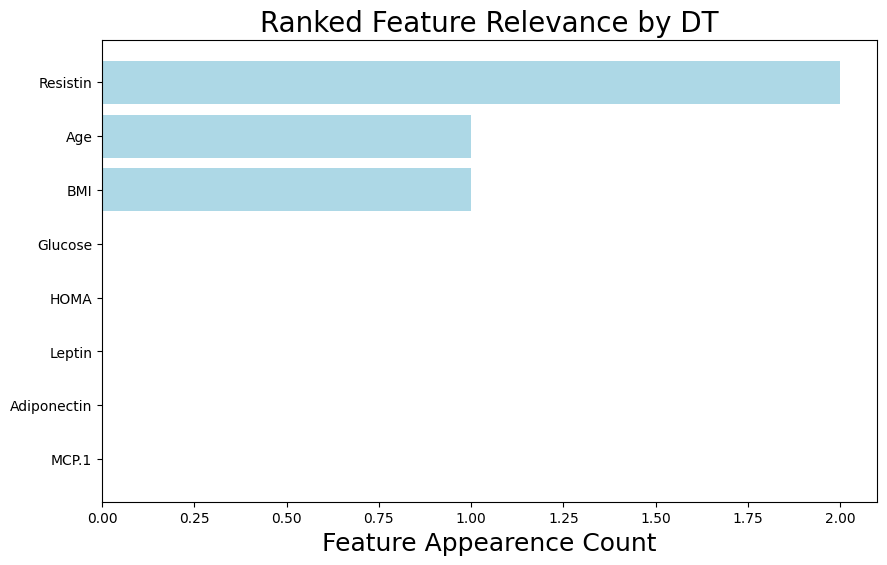

In [21]:
#visualising feature relevance by DT in descending order
sorted_feature_relevance = dict(sorted(feature_relevance.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_feature_relevance.keys())
feature_values = list(sorted_feature_relevance.values())
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_values, color='lightblue')
plt.xlabel("Feature Appearence Count", fontsize=18)
plt.title("Ranked Feature Relevance by DT", fontsize=20)
plt.gca().invert_yaxis()  

In [22]:
# 2.RANDOM FOREST

# Hyperparameter optimization
param_dist = {
    'n_estimators': [10, 15, 20, 25, 30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4]
}

search_rf = RandomizedSearchCV(
     RandomForestClassifier(random_state=RANDOM_STATE),
     param_distributions=param_dist,
    cv=5,
    verbose=1,
    
)

#  Training RF
search_rf.fit(X_train_scaled, y_train)
best_params_rf = search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)
print("best f1 score for Rf during training: ", search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
best f1 score for Rf during training:  0.8175438596491228


In [23]:
# Testing RF 
best_rf_model =search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# performace evaluation RF
print("\nEvaluation Metrics for Random Forest:")
accuracy= accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_rf)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_rf, beta=2)
print("F2 Score:", f_beta)
auc= roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Random Forest:
Accuracy: 0.5833333333333334
Precision: 0.6
Recall: 0.6923076923076923
F1 Score: 0.6428571428571429
F2 Score: 0.6716417910447761
AUC: 0.5944055944055945


In [24]:
# Model prediction and local feature importance by RF- Interpretability
prediction = best_rf_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
rf_feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(rf_feature_importances)[::-1]
sorted_features = [feature_names[idx] for idx in sorted_indices]
sorted_importances = [rf_feature_importances[idx] for idx in sorted_indices]

Model Prediction: 1


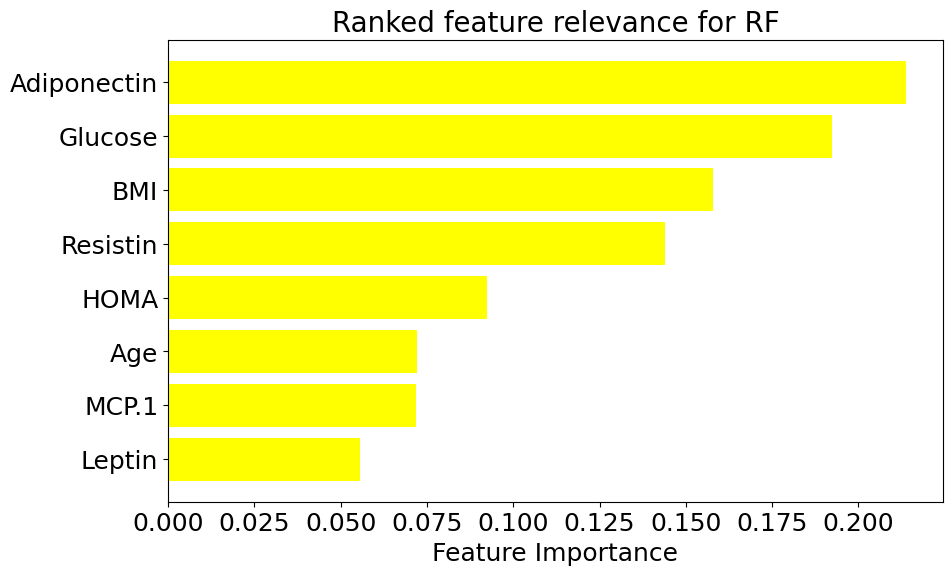

In [25]:
# visulaizing feature relevance by RF
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='yellow')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Feature Importance' , fontsize=18)
plt.title('Ranked feature relevance for RF', fontsize=20)
plt.gca().invert_yaxis() 
plt.show()

In [26]:
# 3.TabNet
# Hyperparameter optimization
tabnet_params = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.3, 1.8],
    'lambda_sparse': [0.001, 0.005, 0.01],
}

search_tabnet = RandomizedSearchCV(
    TabNetClassifier(),
    param_distributions=tabnet_params,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Training TabNet
search_tabnet.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=20
)
best_params_tabnet = search_tabnet.best_params_
print("Best Parameters for TabNet:", best_params_tabnet)
print("Best f1 score for Tabnet during training: ", search_tabnet.best_score_)

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
epoch 0  | loss: 2.83967 | val_0_auc: 0.28671 |  0:00:00s
epoch 1  | loss: 1.38493 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.90742 | val_0_auc: 0.59441 |  0:00:00s
epoch 3  | loss: 0.95183 | val_0_auc: 0.44056 |  0:00:00s
epoch 4  | loss: 0.55477 | val_0_auc: 0.32168 |  0:00:01s
epoch 5  | loss: 0.8515  | val_0_auc: 0.3007  |  0:00:01s
epoch 6  | loss: 0.66891 | val_0_auc: 0.35664 |  0:00:01s
epoch 7  | loss: 0.49911 | val_0_auc: 0.34965 |  0:00:01s
epoch 8  | loss: 0.5126  | val_0_auc: 0.3986  |  0:00:01s
epoch 9  | loss: 0.67954 | val_0_auc: 0.42657 |  0:00:02s
epoch 10 | loss: 0.57913 | val_0_auc: 0.42657 |  0:00:02s
epoch 11 | loss: 0.58337 | val_0_auc: 0.3986  |  0:00:02s
epoch 12 | loss: 0.53102 | val_0_auc: 0.40559 |  0:00:02s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.59441


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.57963 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 1.52913 | val_0_auc: 0.62238 |  0:00:00s
epoch 2  | loss: 0.93147 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 0.98305 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.58959 | val_0_auc: 0.55944 |  0:00:01s
epoch 5  | loss: 0.68446 | val_0_auc: 0.64336 |  0:00:01s
epoch 6  | loss: 0.67781 | val_0_auc: 0.62238 |  0:00:01s
epoch 7  | loss: 0.89748 | val_0_auc: 0.59441 |  0:00:01s
epoch 8  | loss: 0.54396 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.61179 | val_0_auc: 0.67133 |  0:00:02s
epoch 10 | loss: 0.76662 | val_0_auc: 0.76224 |  0:00:02s
epoch 11 | loss: 0.60373 | val_0_auc: 0.71329 |  0:00:02s
epoch 12 | loss: 0.52932 | val_0_auc: 0.64336 |  0:00:02s
epoch 13 | loss: 0.63277 | val_0_auc: 0.55245 |  0:00:02s
epoch 14 | loss: 0.50275 | val_0_auc: 0.57343 |  0:00:03s
epoch 15 | loss: 0.5171  | val_0_auc: 0.56643 |  0:00:03s
epoch 16 | loss: 0.54866 | val_0_auc: 0.65734 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.14229 | val_0_auc: 0.58042 |  0:00:00s
epoch 1  | loss: 1.21479 | val_0_auc: 0.5035  |  0:00:00s
epoch 2  | loss: 1.00588 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.81215 | val_0_auc: 0.47552 |  0:00:00s
epoch 4  | loss: 0.7463  | val_0_auc: 0.44755 |  0:00:01s
epoch 5  | loss: 0.44332 | val_0_auc: 0.43357 |  0:00:01s
epoch 6  | loss: 0.66071 | val_0_auc: 0.55245 |  0:00:01s
epoch 7  | loss: 0.71095 | val_0_auc: 0.53147 |  0:00:01s
epoch 8  | loss: 0.61524 | val_0_auc: 0.74126 |  0:00:02s
epoch 9  | loss: 0.73537 | val_0_auc: 0.64336 |  0:00:02s
epoch 10 | loss: 0.66747 | val_0_auc: 0.68531 |  0:00:02s
epoch 11 | loss: 0.60837 | val_0_auc: 0.59441 |  0:00:02s
epoch 12 | loss: 0.6341  | val_0_auc: 0.73427 |  0:00:02s
epoch 13 | loss: 0.62869 | val_0_auc: 0.83217 |  0:00:03s
epoch 14 | loss: 0.62379 | val_0_auc: 0.85315 |  0:00:03s
epoch 15 | loss: 0.56338 | val_0_auc: 0.83916 |  0:00:03s
epoch 16 | loss: 0.51707 | val_0_auc: 0.71329 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.05089 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 1.33886 | val_0_auc: 0.53147 |  0:00:00s
epoch 2  | loss: 1.11913 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.87018 | val_0_auc: 0.74825 |  0:00:00s
epoch 4  | loss: 0.99733 | val_0_auc: 0.8042  |  0:00:01s
epoch 5  | loss: 0.75893 | val_0_auc: 0.76224 |  0:00:01s
epoch 6  | loss: 0.6236  | val_0_auc: 0.74126 |  0:00:01s
epoch 7  | loss: 0.66276 | val_0_auc: 0.74126 |  0:00:01s
epoch 8  | loss: 0.79196 | val_0_auc: 0.54545 |  0:00:02s
epoch 9  | loss: 0.55843 | val_0_auc: 0.3986  |  0:00:02s
epoch 10 | loss: 0.60251 | val_0_auc: 0.36364 |  0:00:02s
epoch 11 | loss: 0.56765 | val_0_auc: 0.34266 |  0:00:02s
epoch 12 | loss: 0.597   | val_0_auc: 0.40559 |  0:00:03s
epoch 13 | loss: 0.52808 | val_0_auc: 0.44755 |  0:00:03s
epoch 14 | loss: 0.54907 | val_0_auc: 0.47552 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.8042


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.16457 | val_0_auc: 0.48951 |  0:00:00s
epoch 1  | loss: 1.50449 | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 0.98665 | val_0_auc: 0.51748 |  0:00:00s
epoch 3  | loss: 0.9568  | val_0_auc: 0.40559 |  0:00:01s
epoch 4  | loss: 0.9711  | val_0_auc: 0.46853 |  0:00:01s
epoch 5  | loss: 0.82718 | val_0_auc: 0.48951 |  0:00:01s
epoch 6  | loss: 0.64823 | val_0_auc: 0.37762 |  0:00:01s
epoch 7  | loss: 0.63221 | val_0_auc: 0.53147 |  0:00:02s
epoch 8  | loss: 0.49344 | val_0_auc: 0.73427 |  0:00:02s
epoch 9  | loss: 0.453   | val_0_auc: 0.74825 |  0:00:02s
epoch 10 | loss: 0.62049 | val_0_auc: 0.62238 |  0:00:02s
epoch 11 | loss: 0.47917 | val_0_auc: 0.58042 |  0:00:02s
epoch 12 | loss: 0.44162 | val_0_auc: 0.52448 |  0:00:03s
epoch 13 | loss: 0.47181 | val_0_auc: 0.51049 |  0:00:03s
epoch 14 | loss: 0.68982 | val_0_auc: 0.46154 |  0:00:03s
epoch 15 | loss: 0.64866 | val_0_auc: 0.52448 |  0:00:04s
epoch 16 | loss: 0.7131  | val_0_auc: 0.53147 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71061 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 0.8778  | val_0_auc: 0.37762 |  0:00:00s
epoch 2  | loss: 1.08883 | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.98802 | val_0_auc: 0.38462 |  0:00:00s
epoch 4  | loss: 0.61886 | val_0_auc: 0.46853 |  0:00:01s
epoch 5  | loss: 0.58911 | val_0_auc: 0.58042 |  0:00:01s
epoch 6  | loss: 0.56385 | val_0_auc: 0.73427 |  0:00:01s
epoch 7  | loss: 0.42989 | val_0_auc: 0.70629 |  0:00:01s
epoch 8  | loss: 0.56355 | val_0_auc: 0.67832 |  0:00:01s
epoch 9  | loss: 0.44774 | val_0_auc: 0.72028 |  0:00:02s
epoch 10 | loss: 0.45645 | val_0_auc: 0.70629 |  0:00:02s
epoch 11 | loss: 0.56022 | val_0_auc: 0.70629 |  0:00:02s
epoch 12 | loss: 0.60463 | val_0_auc: 0.72727 |  0:00:02s
epoch 13 | loss: 0.28733 | val_0_auc: 0.6993  |  0:00:02s
epoch 14 | loss: 0.39311 | val_0_auc: 0.72028 |  0:00:03s
epoch 15 | loss: 0.53714 | val_0_auc: 0.72727 |  0:00:03s
epoch 16 | loss: 0.36556 | val_0_auc: 0.71329 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.96403 | val_0_auc: 0.52448 |  0:00:00s
epoch 1  | loss: 1.21104 | val_0_auc: 0.67133 |  0:00:00s
epoch 2  | loss: 0.92629 | val_0_auc: 0.48951 |  0:00:00s
epoch 3  | loss: 0.57042 | val_0_auc: 0.53846 |  0:00:00s
epoch 4  | loss: 0.68689 | val_0_auc: 0.6014  |  0:00:01s
epoch 5  | loss: 0.52148 | val_0_auc: 0.66434 |  0:00:01s
epoch 6  | loss: 0.35261 | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.38284 | val_0_auc: 0.63636 |  0:00:01s
epoch 8  | loss: 0.3601  | val_0_auc: 0.51748 |  0:00:01s
epoch 9  | loss: 0.61074 | val_0_auc: 0.38462 |  0:00:01s
epoch 10 | loss: 0.45222 | val_0_auc: 0.39161 |  0:00:02s
epoch 11 | loss: 0.43784 | val_0_auc: 0.46154 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.67133


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71296 | val_0_auc: 0.40559 |  0:00:00s
epoch 1  | loss: 1.10189 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 1.16921 | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.87622 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.69345 | val_0_auc: 0.55245 |  0:00:01s
epoch 5  | loss: 0.52186 | val_0_auc: 0.5035  |  0:00:01s
epoch 6  | loss: 0.59099 | val_0_auc: 0.54545 |  0:00:01s
epoch 7  | loss: 0.4763  | val_0_auc: 0.66434 |  0:00:01s
epoch 8  | loss: 0.55243 | val_0_auc: 0.67832 |  0:00:01s
epoch 9  | loss: 0.50483 | val_0_auc: 0.70629 |  0:00:02s
epoch 10 | loss: 0.50259 | val_0_auc: 0.62238 |  0:00:02s
epoch 11 | loss: 0.42671 | val_0_auc: 0.6014  |  0:00:02s
epoch 12 | loss: 0.59913 | val_0_auc: 0.58042 |  0:00:02s
epoch 13 | loss: 0.51388 | val_0_auc: 0.65035 |  0:00:02s
epoch 14 | loss: 0.45555 | val_0_auc: 0.6993  |  0:00:03s
epoch 15 | loss: 0.39143 | val_0_auc: 0.74126 |  0:00:03s
epoch 16 | loss: 0.59884 | val_0_auc: 0.74126 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02064 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 1.01236 | val_0_auc: 0.32168 |  0:00:00s
epoch 2  | loss: 1.1108  | val_0_auc: 0.36364 |  0:00:00s
epoch 3  | loss: 0.76557 | val_0_auc: 0.46154 |  0:00:00s
epoch 4  | loss: 0.64081 | val_0_auc: 0.54545 |  0:00:00s
epoch 5  | loss: 0.60516 | val_0_auc: 0.53846 |  0:00:01s
epoch 6  | loss: 0.51287 | val_0_auc: 0.48951 |  0:00:01s
epoch 7  | loss: 0.48345 | val_0_auc: 0.41958 |  0:00:01s
epoch 8  | loss: 0.63943 | val_0_auc: 0.46154 |  0:00:01s
epoch 9  | loss: 0.63046 | val_0_auc: 0.55944 |  0:00:01s
epoch 10 | loss: 0.78967 | val_0_auc: 0.59441 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.67133


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8675  | val_0_auc: 0.37063 |  0:00:00s
epoch 1  | loss: 0.97478 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 0.73811 | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.59556 | val_0_auc: 0.34965 |  0:00:00s
epoch 4  | loss: 0.58042 | val_0_auc: 0.38462 |  0:00:01s
epoch 5  | loss: 0.6263  | val_0_auc: 0.45455 |  0:00:01s
epoch 6  | loss: 0.51589 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.51921 | val_0_auc: 0.52448 |  0:00:01s
epoch 8  | loss: 0.63597 | val_0_auc: 0.53147 |  0:00:02s
epoch 9  | loss: 0.50458 | val_0_auc: 0.48951 |  0:00:02s
epoch 10 | loss: 0.53164 | val_0_auc: 0.48252 |  0:00:02s
epoch 11 | loss: 0.54658 | val_0_auc: 0.48951 |  0:00:02s
epoch 12 | loss: 0.37133 | val_0_auc: 0.48951 |  0:00:02s
epoch 13 | loss: 0.35586 | val_0_auc: 0.58741 |  0:00:02s
epoch 14 | loss: 0.46416 | val_0_auc: 0.66434 |  0:00:03s
epoch 15 | loss: 0.4044  | val_0_auc: 0.76224 |  0:00:03s
epoch 16 | loss: 0.39598 | val_0_auc: 0.7972  |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71111 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 1.00133 | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 1.17479 | val_0_auc: 0.63636 |  0:00:00s
epoch 3  | loss: 0.81174 | val_0_auc: 0.65035 |  0:00:00s
epoch 4  | loss: 0.56344 | val_0_auc: 0.59441 |  0:00:00s
epoch 5  | loss: 0.71884 | val_0_auc: 0.63636 |  0:00:01s
epoch 6  | loss: 0.59318 | val_0_auc: 0.72727 |  0:00:01s
epoch 7  | loss: 0.51005 | val_0_auc: 0.79021 |  0:00:01s
epoch 8  | loss: 0.74    | val_0_auc: 0.78322 |  0:00:01s
epoch 9  | loss: 0.4738  | val_0_auc: 0.77622 |  0:00:02s
epoch 10 | loss: 0.47328 | val_0_auc: 0.70629 |  0:00:02s
epoch 11 | loss: 0.44399 | val_0_auc: 0.68531 |  0:00:02s
epoch 12 | loss: 0.63925 | val_0_auc: 0.67832 |  0:00:02s
epoch 13 | loss: 0.4616  | val_0_auc: 0.76923 |  0:00:02s
epoch 14 | loss: 0.28011 | val_0_auc: 0.79021 |  0:00:02s
epoch 15 | loss: 0.38629 | val_0_auc: 0.77622 |  0:00:03s
epoch 16 | loss: 0.3165  | val_0_auc: 0.79021 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9437  | val_0_auc: 0.63636 |  0:00:00s
epoch 1  | loss: 1.07326 | val_0_auc: 0.69231 |  0:00:00s
epoch 2  | loss: 0.74314 | val_0_auc: 0.67133 |  0:00:00s
epoch 3  | loss: 0.57548 | val_0_auc: 0.66434 |  0:00:00s
epoch 4  | loss: 0.65984 | val_0_auc: 0.61538 |  0:00:00s
epoch 5  | loss: 0.53234 | val_0_auc: 0.55944 |  0:00:01s
epoch 6  | loss: 0.39896 | val_0_auc: 0.44056 |  0:00:01s
epoch 7  | loss: 0.48218 | val_0_auc: 0.62937 |  0:00:01s
epoch 8  | loss: 0.62355 | val_0_auc: 0.78322 |  0:00:01s
epoch 9  | loss: 0.63515 | val_0_auc: 0.81119 |  0:00:01s
epoch 10 | loss: 0.65312 | val_0_auc: 0.76224 |  0:00:02s
epoch 11 | loss: 0.34722 | val_0_auc: 0.76923 |  0:00:02s
epoch 12 | loss: 0.39277 | val_0_auc: 0.77622 |  0:00:02s
epoch 13 | loss: 0.37358 | val_0_auc: 0.77622 |  0:00:02s
epoch 14 | loss: 0.33485 | val_0_auc: 0.81119 |  0:00:02s
epoch 15 | loss: 0.28855 | val_0_auc: 0.81818 |  0:00:02s
epoch 16 | loss: 0.54614 | val_0_auc: 0.83916 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.72636 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 1.03782 | val_0_auc: 0.46154 |  0:00:00s
epoch 2  | loss: 0.81907 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.80412 | val_0_auc: 0.6014  |  0:00:00s
epoch 4  | loss: 0.56492 | val_0_auc: 0.59441 |  0:00:01s
epoch 5  | loss: 0.56211 | val_0_auc: 0.56643 |  0:00:01s
epoch 6  | loss: 0.63167 | val_0_auc: 0.53147 |  0:00:01s
epoch 7  | loss: 0.75952 | val_0_auc: 0.59441 |  0:00:01s
epoch 8  | loss: 0.54251 | val_0_auc: 0.65035 |  0:00:01s
epoch 9  | loss: 0.39867 | val_0_auc: 0.67832 |  0:00:02s
epoch 10 | loss: 0.49058 | val_0_auc: 0.7972  |  0:00:02s
epoch 11 | loss: 0.57721 | val_0_auc: 0.72727 |  0:00:02s
epoch 12 | loss: 0.40935 | val_0_auc: 0.64336 |  0:00:02s
epoch 13 | loss: 0.64304 | val_0_auc: 0.61538 |  0:00:02s
epoch 14 | loss: 0.35808 | val_0_auc: 0.56643 |  0:00:03s
epoch 15 | loss: 0.49286 | val_0_auc: 0.4965  |  0:00:03s
epoch 16 | loss: 0.37    | val_0_auc: 0.48252 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02423 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 0.94751 | val_0_auc: 0.43357 |  0:00:00s
epoch 2  | loss: 1.16126 | val_0_auc: 0.53147 |  0:00:00s
epoch 3  | loss: 0.79308 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.71767 | val_0_auc: 0.35664 |  0:00:01s
epoch 5  | loss: 0.58438 | val_0_auc: 0.58042 |  0:00:01s
epoch 6  | loss: 0.61109 | val_0_auc: 0.57343 |  0:00:01s
epoch 7  | loss: 0.64868 | val_0_auc: 0.52448 |  0:00:01s
epoch 8  | loss: 0.82033 | val_0_auc: 0.55245 |  0:00:01s
epoch 9  | loss: 0.67077 | val_0_auc: 0.55944 |  0:00:02s
epoch 10 | loss: 0.55797 | val_0_auc: 0.45455 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.67133


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.78693 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 1.01999 | val_0_auc: 0.24476 |  0:00:00s
epoch 2  | loss: 0.7556  | val_0_auc: 0.48252 |  0:00:00s
epoch 3  | loss: 0.60109 | val_0_auc: 0.48252 |  0:00:01s
epoch 4  | loss: 0.65897 | val_0_auc: 0.65035 |  0:00:01s
epoch 5  | loss: 0.63868 | val_0_auc: 0.68531 |  0:00:01s
epoch 6  | loss: 0.41647 | val_0_auc: 0.76224 |  0:00:01s
epoch 7  | loss: 0.35638 | val_0_auc: 0.76224 |  0:00:01s
epoch 8  | loss: 0.46955 | val_0_auc: 0.55944 |  0:00:02s
epoch 9  | loss: 0.43898 | val_0_auc: 0.54545 |  0:00:02s
epoch 10 | loss: 0.48856 | val_0_auc: 0.58042 |  0:00:02s
epoch 11 | loss: 0.39129 | val_0_auc: 0.60839 |  0:00:03s
epoch 12 | loss: 0.48197 | val_0_auc: 0.67832 |  0:00:03s
epoch 13 | loss: 0.53366 | val_0_auc: 0.6993  |  0:00:03s
epoch 14 | loss: 0.66815 | val_0_auc: 0.75524 |  0:00:03s
epoch 15 | loss: 0.48097 | val_0_auc: 0.72727 |  0:00:04s
epoch 16 | loss: 0.36363 | val_0_auc: 0.72727 |  0:00:04s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30374 | val_0_auc: 0.32168 |  0:00:00s
epoch 1  | loss: 0.78187 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.74782 | val_0_auc: 0.6993  |  0:00:01s
epoch 3  | loss: 0.70074 | val_0_auc: 0.60839 |  0:00:01s
epoch 4  | loss: 0.48676 | val_0_auc: 0.72028 |  0:00:01s
epoch 5  | loss: 0.59826 | val_0_auc: 0.67832 |  0:00:02s
epoch 6  | loss: 0.70767 | val_0_auc: 0.71329 |  0:00:02s
epoch 7  | loss: 0.63661 | val_0_auc: 0.67832 |  0:00:03s
epoch 8  | loss: 0.58128 | val_0_auc: 0.60839 |  0:00:03s
epoch 9  | loss: 0.67443 | val_0_auc: 0.47552 |  0:00:04s
epoch 10 | loss: 0.45808 | val_0_auc: 0.5035  |  0:00:04s
epoch 11 | loss: 0.25819 | val_0_auc: 0.62238 |  0:00:04s
epoch 12 | loss: 0.42808 | val_0_auc: 0.66434 |  0:00:05s
epoch 13 | loss: 0.37131 | val_0_auc: 0.65734 |  0:00:05s
epoch 14 | loss: 0.27897 | val_0_auc: 0.67832 |  0:00:05s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.72028


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89326 | val_0_auc: 0.5035  |  0:00:00s
epoch 1  | loss: 1.1798  | val_0_auc: 0.67133 |  0:00:00s
epoch 2  | loss: 0.70472 | val_0_auc: 0.46853 |  0:00:01s
epoch 3  | loss: 0.80449 | val_0_auc: 0.74825 |  0:00:01s
epoch 4  | loss: 0.46452 | val_0_auc: 0.69231 |  0:00:01s
epoch 5  | loss: 0.41576 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 0.5607  | val_0_auc: 0.55245 |  0:00:02s
epoch 7  | loss: 0.62499 | val_0_auc: 0.67133 |  0:00:02s
epoch 8  | loss: 0.37095 | val_0_auc: 0.59441 |  0:00:02s
epoch 9  | loss: 0.45695 | val_0_auc: 0.62937 |  0:00:03s
epoch 10 | loss: 0.6727  | val_0_auc: 0.60839 |  0:00:03s
epoch 11 | loss: 0.43684 | val_0_auc: 0.64336 |  0:00:03s
epoch 12 | loss: 0.45612 | val_0_auc: 0.73427 |  0:00:03s
epoch 13 | loss: 0.53816 | val_0_auc: 0.57343 |  0:00:04s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.74825


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02859 | val_0_auc: 0.57343 |  0:00:00s
epoch 1  | loss: 1.24538 | val_0_auc: 0.37063 |  0:00:00s
epoch 2  | loss: 1.17634 | val_0_auc: 0.54545 |  0:00:00s
epoch 3  | loss: 1.18261 | val_0_auc: 0.70629 |  0:00:01s
epoch 4  | loss: 0.80892 | val_0_auc: 0.55944 |  0:00:01s
epoch 5  | loss: 0.61025 | val_0_auc: 0.75524 |  0:00:01s
epoch 6  | loss: 0.41418 | val_0_auc: 0.83916 |  0:00:02s
epoch 7  | loss: 0.50315 | val_0_auc: 0.83217 |  0:00:02s
epoch 8  | loss: 0.44009 | val_0_auc: 0.82517 |  0:00:02s
epoch 9  | loss: 0.70536 | val_0_auc: 0.86014 |  0:00:03s
epoch 10 | loss: 0.71961 | val_0_auc: 0.83916 |  0:00:03s
epoch 11 | loss: 0.68958 | val_0_auc: 0.86014 |  0:00:03s
epoch 12 | loss: 0.38596 | val_0_auc: 0.81818 |  0:00:03s
epoch 13 | loss: 0.55781 | val_0_auc: 0.55944 |  0:00:04s
epoch 14 | loss: 0.67701 | val_0_auc: 0.53147 |  0:00:04s
epoch 15 | loss: 0.56342 | val_0_auc: 0.44755 |  0:00:04s
epoch 16 | loss: 0.39482 | val_0_auc: 0.48951 |  0:00:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60425 | val_0_auc: 0.44056 |  0:00:00s
epoch 1  | loss: 1.11829 | val_0_auc: 0.17483 |  0:00:00s
epoch 2  | loss: 1.05939 | val_0_auc: 0.24476 |  0:00:00s
epoch 3  | loss: 0.87177 | val_0_auc: 0.55944 |  0:00:01s
epoch 4  | loss: 0.82836 | val_0_auc: 0.60839 |  0:00:01s
epoch 5  | loss: 0.89342 | val_0_auc: 0.73427 |  0:00:01s
epoch 6  | loss: 0.51049 | val_0_auc: 0.72028 |  0:00:02s
epoch 7  | loss: 0.55532 | val_0_auc: 0.84615 |  0:00:02s
epoch 8  | loss: 0.72715 | val_0_auc: 0.74825 |  0:00:02s
epoch 9  | loss: 0.55439 | val_0_auc: 0.78322 |  0:00:03s
epoch 10 | loss: 0.44772 | val_0_auc: 0.74126 |  0:00:03s
epoch 11 | loss: 0.23541 | val_0_auc: 0.74825 |  0:00:03s
epoch 12 | loss: 0.53163 | val_0_auc: 0.76224 |  0:00:03s
epoch 13 | loss: 0.47006 | val_0_auc: 0.74126 |  0:00:04s
epoch 14 | loss: 0.35875 | val_0_auc: 0.59441 |  0:00:04s
epoch 15 | loss: 0.29402 | val_0_auc: 0.51748 |  0:00:04s
epoch 16 | loss: 0.30927 | val_0_auc: 0.45455 |  0:00:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83699 | val_0_auc: 0.57343 |  0:00:00s
epoch 1  | loss: 0.80415 | val_0_auc: 0.58042 |  0:00:00s
epoch 2  | loss: 0.89005 | val_0_auc: 0.6014  |  0:00:00s
epoch 3  | loss: 0.80305 | val_0_auc: 0.5035  |  0:00:01s
epoch 4  | loss: 0.61509 | val_0_auc: 0.6993  |  0:00:01s
epoch 5  | loss: 0.72195 | val_0_auc: 0.6993  |  0:00:01s
epoch 6  | loss: 0.43922 | val_0_auc: 0.68531 |  0:00:02s
epoch 7  | loss: 0.83986 | val_0_auc: 0.6993  |  0:00:02s
epoch 8  | loss: 0.47966 | val_0_auc: 0.67832 |  0:00:02s
epoch 9  | loss: 0.57669 | val_0_auc: 0.63636 |  0:00:02s
epoch 10 | loss: 0.67346 | val_0_auc: 0.64336 |  0:00:03s
epoch 11 | loss: 0.44442 | val_0_auc: 0.67832 |  0:00:03s
epoch 12 | loss: 0.34055 | val_0_auc: 0.6993  |  0:00:03s
epoch 13 | loss: 0.43499 | val_0_auc: 0.76923 |  0:00:04s
epoch 14 | loss: 0.39635 | val_0_auc: 0.81119 |  0:00:04s
epoch 15 | loss: 0.38495 | val_0_auc: 0.76923 |  0:00:04s
epoch 16 | loss: 0.3841  | val_0_auc: 0.74825 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.72705 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.86991 | val_0_auc: 0.76224 |  0:00:00s
epoch 2  | loss: 0.90418 | val_0_auc: 0.48951 |  0:00:00s
epoch 3  | loss: 0.77594 | val_0_auc: 0.5035  |  0:00:00s
epoch 4  | loss: 0.61283 | val_0_auc: 0.51748 |  0:00:01s
epoch 5  | loss: 0.5344  | val_0_auc: 0.32168 |  0:00:01s
epoch 6  | loss: 0.62147 | val_0_auc: 0.41958 |  0:00:01s
epoch 7  | loss: 0.34123 | val_0_auc: 0.54545 |  0:00:01s
epoch 8  | loss: 0.54359 | val_0_auc: 0.45455 |  0:00:01s
epoch 9  | loss: 0.49552 | val_0_auc: 0.67832 |  0:00:02s
epoch 10 | loss: 0.41436 | val_0_auc: 0.65734 |  0:00:02s
epoch 11 | loss: 0.26612 | val_0_auc: 0.73427 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.76224


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37489 | val_0_auc: 0.63636 |  0:00:00s
epoch 1  | loss: 1.08283 | val_0_auc: 0.79021 |  0:00:00s
epoch 2  | loss: 0.73243 | val_0_auc: 0.81119 |  0:00:00s
epoch 3  | loss: 0.71627 | val_0_auc: 0.76923 |  0:00:00s
epoch 4  | loss: 0.74363 | val_0_auc: 0.70629 |  0:00:01s
epoch 5  | loss: 0.41386 | val_0_auc: 0.72028 |  0:00:01s
epoch 6  | loss: 0.45944 | val_0_auc: 0.74126 |  0:00:01s
epoch 7  | loss: 0.41539 | val_0_auc: 0.76923 |  0:00:01s
epoch 8  | loss: 0.58842 | val_0_auc: 0.74825 |  0:00:01s
epoch 9  | loss: 0.65024 | val_0_auc: 0.66434 |  0:00:02s
epoch 10 | loss: 0.66414 | val_0_auc: 0.66434 |  0:00:02s
epoch 11 | loss: 0.30881 | val_0_auc: 0.68531 |  0:00:02s
epoch 12 | loss: 0.60452 | val_0_auc: 0.68531 |  0:00:02s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.81119


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59529 | val_0_auc: 0.56643 |  0:00:00s
epoch 1  | loss: 1.12635 | val_0_auc: 0.53147 |  0:00:00s
epoch 2  | loss: 1.04553 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.95306 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 1.12743 | val_0_auc: 0.58741 |  0:00:01s
epoch 5  | loss: 0.67229 | val_0_auc: 0.58042 |  0:00:01s
epoch 6  | loss: 0.41729 | val_0_auc: 0.44755 |  0:00:01s
epoch 7  | loss: 0.3899  | val_0_auc: 0.46154 |  0:00:01s
epoch 8  | loss: 0.64515 | val_0_auc: 0.51049 |  0:00:01s
epoch 9  | loss: 0.76197 | val_0_auc: 0.53846 |  0:00:02s
epoch 10 | loss: 0.41298 | val_0_auc: 0.46853 |  0:00:02s
epoch 11 | loss: 0.49542 | val_0_auc: 0.63636 |  0:00:02s
epoch 12 | loss: 0.46458 | val_0_auc: 0.66434 |  0:00:02s
epoch 13 | loss: 0.42845 | val_0_auc: 0.71329 |  0:00:02s
epoch 14 | loss: 0.40269 | val_0_auc: 0.74126 |  0:00:03s
epoch 15 | loss: 0.46293 | val_0_auc: 0.74825 |  0:00:03s
epoch 16 | loss: 0.37642 | val_0_auc: 0.73427 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32688 | val_0_auc: 0.48252 |  0:00:00s
epoch 1  | loss: 0.8576  | val_0_auc: 0.55245 |  0:00:00s
epoch 2  | loss: 0.60004 | val_0_auc: 0.63636 |  0:00:00s
epoch 3  | loss: 1.02152 | val_0_auc: 0.47552 |  0:00:00s
epoch 4  | loss: 0.68929 | val_0_auc: 0.34965 |  0:00:01s
epoch 5  | loss: 0.55524 | val_0_auc: 0.35664 |  0:00:01s
epoch 6  | loss: 0.48264 | val_0_auc: 0.39161 |  0:00:01s
epoch 7  | loss: 0.64988 | val_0_auc: 0.37063 |  0:00:01s
epoch 8  | loss: 0.58045 | val_0_auc: 0.3986  |  0:00:01s
epoch 9  | loss: 0.23083 | val_0_auc: 0.4965  |  0:00:02s
epoch 10 | loss: 0.56588 | val_0_auc: 0.53147 |  0:00:02s
epoch 11 | loss: 0.48554 | val_0_auc: 0.58741 |  0:00:02s
epoch 12 | loss: 0.53369 | val_0_auc: 0.59441 |  0:00:02s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.63636


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68132 | val_0_auc: 0.30769 |  0:00:00s
epoch 1  | loss: 0.80243 | val_0_auc: 0.67832 |  0:00:00s
epoch 2  | loss: 0.77176 | val_0_auc: 0.72727 |  0:00:00s
epoch 3  | loss: 0.82441 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.78287 | val_0_auc: 0.69231 |  0:00:01s
epoch 5  | loss: 0.36035 | val_0_auc: 0.63636 |  0:00:01s
epoch 6  | loss: 0.84372 | val_0_auc: 0.52448 |  0:00:01s
epoch 7  | loss: 1.06261 | val_0_auc: 0.57343 |  0:00:01s
epoch 8  | loss: 0.4766  | val_0_auc: 0.57343 |  0:00:01s
epoch 9  | loss: 0.40934 | val_0_auc: 0.51049 |  0:00:02s
epoch 10 | loss: 0.47596 | val_0_auc: 0.57343 |  0:00:02s
epoch 11 | loss: 0.3105  | val_0_auc: 0.71329 |  0:00:02s
epoch 12 | loss: 0.64665 | val_0_auc: 0.92308 |  0:00:02s
epoch 13 | loss: 0.60707 | val_0_auc: 0.81119 |  0:00:02s
epoch 14 | loss: 0.31769 | val_0_auc: 0.78322 |  0:00:03s
epoch 15 | loss: 0.73373 | val_0_auc: 0.74825 |  0:00:03s
epoch 16 | loss: 0.44758 | val_0_auc: 0.69231 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51035 | val_0_auc: 0.45455 |  0:00:00s
epoch 1  | loss: 1.05996 | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 0.75211 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.85817 | val_0_auc: 0.35664 |  0:00:01s
epoch 4  | loss: 0.67167 | val_0_auc: 0.33566 |  0:00:01s
epoch 5  | loss: 0.67791 | val_0_auc: 0.43357 |  0:00:01s
epoch 6  | loss: 0.69816 | val_0_auc: 0.44056 |  0:00:01s
epoch 7  | loss: 0.65257 | val_0_auc: 0.40559 |  0:00:02s
epoch 8  | loss: 0.60427 | val_0_auc: 0.38462 |  0:00:02s
epoch 9  | loss: 0.70206 | val_0_auc: 0.40559 |  0:00:02s
epoch 10 | loss: 0.55513 | val_0_auc: 0.44755 |  0:00:02s
epoch 11 | loss: 0.82773 | val_0_auc: 0.42657 |  0:00:03s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.48252


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69876 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 1.15356 | val_0_auc: 0.57343 |  0:00:00s
epoch 2  | loss: 0.86258 | val_0_auc: 0.52448 |  0:00:00s
epoch 3  | loss: 0.75948 | val_0_auc: 0.48951 |  0:00:01s
epoch 4  | loss: 0.63454 | val_0_auc: 0.44755 |  0:00:01s
epoch 5  | loss: 0.65866 | val_0_auc: 0.48951 |  0:00:01s
epoch 6  | loss: 0.55747 | val_0_auc: 0.47552 |  0:00:01s
epoch 7  | loss: 0.5896  | val_0_auc: 0.35664 |  0:00:01s
epoch 8  | loss: 0.5478  | val_0_auc: 0.3986  |  0:00:02s
epoch 9  | loss: 0.66692 | val_0_auc: 0.41958 |  0:00:02s
epoch 10 | loss: 0.49719 | val_0_auc: 0.3986  |  0:00:02s
epoch 11 | loss: 0.67004 | val_0_auc: 0.5035  |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.57343


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47199 | val_0_auc: 0.55245 |  0:00:00s
epoch 1  | loss: 0.99912 | val_0_auc: 0.67832 |  0:00:00s
epoch 2  | loss: 0.88681 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 0.88108 | val_0_auc: 0.61538 |  0:00:00s
epoch 4  | loss: 0.74911 | val_0_auc: 0.71329 |  0:00:01s
epoch 5  | loss: 0.66077 | val_0_auc: 0.65035 |  0:00:01s
epoch 6  | loss: 0.69482 | val_0_auc: 0.55245 |  0:00:01s
epoch 7  | loss: 0.59767 | val_0_auc: 0.47552 |  0:00:01s
epoch 8  | loss: 0.57669 | val_0_auc: 0.46853 |  0:00:01s
epoch 9  | loss: 0.64214 | val_0_auc: 0.44755 |  0:00:02s
epoch 10 | loss: 0.56855 | val_0_auc: 0.44755 |  0:00:02s
epoch 11 | loss: 0.56367 | val_0_auc: 0.4965  |  0:00:02s
epoch 12 | loss: 0.54213 | val_0_auc: 0.48951 |  0:00:02s
epoch 13 | loss: 0.54358 | val_0_auc: 0.41259 |  0:00:02s
epoch 14 | loss: 0.62392 | val_0_auc: 0.45455 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.71329


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60421 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 1.04686 | val_0_auc: 0.51049 |  0:00:00s
epoch 2  | loss: 0.93803 | val_0_auc: 0.68531 |  0:00:00s
epoch 3  | loss: 0.8045  | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.82196 | val_0_auc: 0.6993  |  0:00:01s
epoch 5  | loss: 0.58187 | val_0_auc: 0.71329 |  0:00:01s
epoch 6  | loss: 0.73483 | val_0_auc: 0.71329 |  0:00:01s
epoch 7  | loss: 0.65457 | val_0_auc: 0.72028 |  0:00:01s
epoch 8  | loss: 0.71424 | val_0_auc: 0.73427 |  0:00:01s
epoch 9  | loss: 0.60408 | val_0_auc: 0.72727 |  0:00:01s
epoch 10 | loss: 0.66011 | val_0_auc: 0.79021 |  0:00:02s
epoch 11 | loss: 0.76302 | val_0_auc: 0.8042  |  0:00:02s
epoch 12 | loss: 0.63235 | val_0_auc: 0.63636 |  0:00:02s
epoch 13 | loss: 0.59419 | val_0_auc: 0.48252 |  0:00:02s
epoch 14 | loss: 0.55762 | val_0_auc: 0.41958 |  0:00:02s
epoch 15 | loss: 0.58731 | val_0_auc: 0.3986  |  0:00:03s
epoch 16 | loss: 0.58845 | val_0_auc: 0.46853 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48776 | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 1.09774 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 1.07707 | val_0_auc: 0.41958 |  0:00:00s
epoch 3  | loss: 0.89404 | val_0_auc: 0.48951 |  0:00:00s
epoch 4  | loss: 0.72567 | val_0_auc: 0.51049 |  0:00:01s
epoch 5  | loss: 0.72495 | val_0_auc: 0.43357 |  0:00:01s
epoch 6  | loss: 0.66017 | val_0_auc: 0.39161 |  0:00:01s
epoch 7  | loss: 0.67716 | val_0_auc: 0.35664 |  0:00:01s
epoch 8  | loss: 0.59929 | val_0_auc: 0.33566 |  0:00:01s
epoch 9  | loss: 0.63033 | val_0_auc: 0.36364 |  0:00:02s
epoch 10 | loss: 0.53586 | val_0_auc: 0.40559 |  0:00:02s
epoch 11 | loss: 0.65094 | val_0_auc: 0.51049 |  0:00:02s
epoch 12 | loss: 0.57982 | val_0_auc: 0.62238 |  0:00:02s
epoch 13 | loss: 0.80735 | val_0_auc: 0.63636 |  0:00:02s
epoch 14 | loss: 0.47686 | val_0_auc: 0.58741 |  0:00:03s
epoch 15 | loss: 0.38918 | val_0_auc: 0.57343 |  0:00:03s
epoch 16 | loss: 0.4425  | val_0_auc: 0.58042 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02257 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 1.20791 | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 1.09775 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.89216 | val_0_auc: 0.53846 |  0:00:00s
epoch 4  | loss: 1.58864 | val_0_auc: 0.55245 |  0:00:01s
epoch 5  | loss: 0.92885 | val_0_auc: 0.8042  |  0:00:01s
epoch 6  | loss: 0.9782  | val_0_auc: 0.88112 |  0:00:01s
epoch 7  | loss: 1.04037 | val_0_auc: 0.74825 |  0:00:01s
epoch 8  | loss: 0.58323 | val_0_auc: 0.67832 |  0:00:02s
epoch 9  | loss: 1.15113 | val_0_auc: 0.58741 |  0:00:02s
epoch 10 | loss: 0.65444 | val_0_auc: 0.55245 |  0:00:02s
epoch 11 | loss: 0.84168 | val_0_auc: 0.59441 |  0:00:02s
epoch 12 | loss: 0.63799 | val_0_auc: 0.61538 |  0:00:03s
epoch 13 | loss: 0.40762 | val_0_auc: 0.67832 |  0:00:03s
epoch 14 | loss: 0.7033  | val_0_auc: 0.72727 |  0:00:03s
epoch 15 | loss: 0.64589 | val_0_auc: 0.76224 |  0:00:03s
epoch 16 | loss: 1.32085 | val_0_auc: 0.68531 |  0:00:04s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48546 | val_0_auc: 0.38462 |  0:00:00s
epoch 1  | loss: 1.88206 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 1.76867 | val_0_auc: 0.60839 |  0:00:00s
epoch 3  | loss: 1.08143 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 1.02565 | val_0_auc: 0.55245 |  0:00:01s
epoch 5  | loss: 0.89428 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.64057 | val_0_auc: 0.47552 |  0:00:01s
epoch 7  | loss: 1.05539 | val_0_auc: 0.61538 |  0:00:01s
epoch 8  | loss: 0.9528  | val_0_auc: 0.65035 |  0:00:02s
epoch 9  | loss: 0.53822 | val_0_auc: 0.62238 |  0:00:02s
epoch 10 | loss: 0.51723 | val_0_auc: 0.71329 |  0:00:02s
epoch 11 | loss: 0.5255  | val_0_auc: 0.71329 |  0:00:02s
epoch 12 | loss: 0.72675 | val_0_auc: 0.67832 |  0:00:03s
epoch 13 | loss: 0.57806 | val_0_auc: 0.64336 |  0:00:03s
epoch 14 | loss: 1.01776 | val_0_auc: 0.76224 |  0:00:03s
epoch 15 | loss: 0.77238 | val_0_auc: 0.72727 |  0:00:03s
epoch 16 | loss: 0.74067 | val_0_auc: 0.64336 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.07158 | val_0_auc: 0.53846 |  0:00:00s
epoch 1  | loss: 1.45124 | val_0_auc: 0.40559 |  0:00:00s
epoch 2  | loss: 1.1382  | val_0_auc: 0.32867 |  0:00:00s
epoch 3  | loss: 1.40263 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.74816 | val_0_auc: 0.51049 |  0:00:01s
epoch 5  | loss: 0.64452 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 0.3729  | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.64613 | val_0_auc: 0.72727 |  0:00:01s
epoch 8  | loss: 0.88728 | val_0_auc: 0.65035 |  0:00:02s
epoch 9  | loss: 0.6487  | val_0_auc: 0.55944 |  0:00:02s
epoch 10 | loss: 0.86145 | val_0_auc: 0.55245 |  0:00:02s
epoch 11 | loss: 1.25432 | val_0_auc: 0.52448 |  0:00:02s
epoch 12 | loss: 0.40786 | val_0_auc: 0.45455 |  0:00:03s
epoch 13 | loss: 0.62217 | val_0_auc: 0.42657 |  0:00:03s
epoch 14 | loss: 0.80336 | val_0_auc: 0.53846 |  0:00:03s
epoch 15 | loss: 0.81927 | val_0_auc: 0.44056 |  0:00:03s
epoch 16 | loss: 0.60509 | val_0_auc: 0.48252 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.97426 | val_0_auc: 0.33566 |  0:00:00s
epoch 1  | loss: 1.32374 | val_0_auc: 0.65035 |  0:00:00s
epoch 2  | loss: 1.39045 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 1.25502 | val_0_auc: 0.3007  |  0:00:00s
epoch 4  | loss: 1.35491 | val_0_auc: 0.62238 |  0:00:01s
epoch 5  | loss: 1.15172 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 1.08377 | val_0_auc: 0.81818 |  0:00:01s
epoch 7  | loss: 1.24418 | val_0_auc: 0.65734 |  0:00:01s
epoch 8  | loss: 1.14404 | val_0_auc: 0.47552 |  0:00:02s
epoch 9  | loss: 0.96604 | val_0_auc: 0.48252 |  0:00:02s
epoch 10 | loss: 1.56687 | val_0_auc: 0.58042 |  0:00:02s
epoch 11 | loss: 0.82257 | val_0_auc: 0.73427 |  0:00:02s
epoch 12 | loss: 0.53404 | val_0_auc: 0.73427 |  0:00:03s
epoch 13 | loss: 0.51641 | val_0_auc: 0.67832 |  0:00:03s
epoch 14 | loss: 0.48883 | val_0_auc: 0.55944 |  0:00:03s
epoch 15 | loss: 0.75083 | val_0_auc: 0.60839 |  0:00:03s
epoch 16 | loss: 0.87399 | val_0_auc: 0.53846 |  0:00:04s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77584 | val_0_auc: 0.69231 |  0:00:00s
epoch 1  | loss: 1.19964 | val_0_auc: 0.57343 |  0:00:00s
epoch 2  | loss: 0.90351 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 1.18801 | val_0_auc: 0.67832 |  0:00:00s
epoch 4  | loss: 0.77841 | val_0_auc: 0.55944 |  0:00:01s
epoch 5  | loss: 0.93608 | val_0_auc: 0.51748 |  0:00:01s
epoch 6  | loss: 0.73287 | val_0_auc: 0.52448 |  0:00:01s
epoch 7  | loss: 0.57585 | val_0_auc: 0.72028 |  0:00:01s
epoch 8  | loss: 0.71572 | val_0_auc: 0.53147 |  0:00:02s
epoch 9  | loss: 0.803   | val_0_auc: 0.47552 |  0:00:02s
epoch 10 | loss: 0.56434 | val_0_auc: 0.47552 |  0:00:02s
epoch 11 | loss: 0.65621 | val_0_auc: 0.51748 |  0:00:02s
epoch 12 | loss: 0.54095 | val_0_auc: 0.6014  |  0:00:02s
epoch 13 | loss: 0.5149  | val_0_auc: 0.6014  |  0:00:03s
epoch 14 | loss: 0.79421 | val_0_auc: 0.66434 |  0:00:03s
epoch 15 | loss: 0.70138 | val_0_auc: 0.4965  |  0:00:03s
epoch 16 | loss: 0.76707 | val_0_auc: 0.54545 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21862 | val_0_auc: 0.53846 |  0:00:00s
epoch 1  | loss: 0.79683 | val_0_auc: 0.43357 |  0:00:00s
epoch 2  | loss: 0.79855 | val_0_auc: 0.48252 |  0:00:00s
epoch 3  | loss: 0.60463 | val_0_auc: 0.46853 |  0:00:00s
epoch 4  | loss: 0.4825  | val_0_auc: 0.65035 |  0:00:00s
epoch 5  | loss: 0.40809 | val_0_auc: 0.73427 |  0:00:00s
epoch 6  | loss: 0.36697 | val_0_auc: 0.51049 |  0:00:00s
epoch 7  | loss: 0.63881 | val_0_auc: 0.48252 |  0:00:01s
epoch 8  | loss: 0.5597  | val_0_auc: 0.45455 |  0:00:01s
epoch 9  | loss: 0.53759 | val_0_auc: 0.44755 |  0:00:01s
epoch 10 | loss: 0.36597 | val_0_auc: 0.44755 |  0:00:01s
epoch 11 | loss: 0.35359 | val_0_auc: 0.46853 |  0:00:01s
epoch 12 | loss: 0.28447 | val_0_auc: 0.51049 |  0:00:01s
epoch 13 | loss: 0.46743 | val_0_auc: 0.55944 |  0:00:01s
epoch 14 | loss: 0.38582 | val_0_auc: 0.58741 |  0:00:01s
epoch 15 | loss: 0.30231 | val_0_auc: 0.55944 |  0:00:01s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31069 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 1.03024 | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 0.48601 | val_0_auc: 0.67832 |  0:00:00s
epoch 3  | loss: 0.54308 | val_0_auc: 0.64336 |  0:00:00s
epoch 4  | loss: 0.59255 | val_0_auc: 0.48252 |  0:00:00s
epoch 5  | loss: 0.50655 | val_0_auc: 0.46853 |  0:00:00s
epoch 6  | loss: 0.48335 | val_0_auc: 0.43357 |  0:00:00s
epoch 7  | loss: 0.54952 | val_0_auc: 0.34965 |  0:00:01s
epoch 8  | loss: 0.50654 | val_0_auc: 0.34965 |  0:00:01s
epoch 9  | loss: 0.45054 | val_0_auc: 0.37063 |  0:00:01s
epoch 10 | loss: 0.40857 | val_0_auc: 0.46853 |  0:00:01s
epoch 11 | loss: 0.40984 | val_0_auc: 0.57343 |  0:00:01s
epoch 12 | loss: 0.27812 | val_0_auc: 0.68531 |  0:00:01s
epoch 13 | loss: 0.25783 | val_0_auc: 0.74825 |  0:00:01s
epoch 14 | loss: 0.31391 | val_0_auc: 0.69231 |  0:00:01s
epoch 15 | loss: 0.41236 | val_0_auc: 0.57343 |  0:00:02s
epoch 16 | loss: 0.42485 | val_0_auc: 0.58741 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38841 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.82066 | val_0_auc: 0.53846 |  0:00:00s
epoch 2  | loss: 0.56152 | val_0_auc: 0.51049 |  0:00:00s
epoch 3  | loss: 0.76838 | val_0_auc: 0.61538 |  0:00:00s
epoch 4  | loss: 0.58216 | val_0_auc: 0.59441 |  0:00:00s
epoch 5  | loss: 0.3812  | val_0_auc: 0.5035  |  0:00:00s
epoch 6  | loss: 0.57311 | val_0_auc: 0.53846 |  0:00:00s
epoch 7  | loss: 0.30928 | val_0_auc: 0.68531 |  0:00:01s
epoch 8  | loss: 0.32446 | val_0_auc: 0.62238 |  0:00:01s
epoch 9  | loss: 0.51298 | val_0_auc: 0.58741 |  0:00:01s
epoch 10 | loss: 0.33756 | val_0_auc: 0.51748 |  0:00:01s
epoch 11 | loss: 0.28909 | val_0_auc: 0.52448 |  0:00:01s
epoch 12 | loss: 0.45024 | val_0_auc: 0.52448 |  0:00:01s
epoch 13 | loss: 0.30077 | val_0_auc: 0.68531 |  0:00:01s
epoch 14 | loss: 0.3568  | val_0_auc: 0.67133 |  0:00:01s
epoch 15 | loss: 0.54031 | val_0_auc: 0.69231 |  0:00:02s
epoch 16 | loss: 0.19099 | val_0_auc: 0.71329 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58485 | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 1.22481 | val_0_auc: 0.62937 |  0:00:00s
epoch 2  | loss: 0.77291 | val_0_auc: 0.59441 |  0:00:00s
epoch 3  | loss: 0.90685 | val_0_auc: 0.45455 |  0:00:00s
epoch 4  | loss: 0.69554 | val_0_auc: 0.52448 |  0:00:00s
epoch 5  | loss: 0.53427 | val_0_auc: 0.59441 |  0:00:00s
epoch 6  | loss: 0.41647 | val_0_auc: 0.58042 |  0:00:00s
epoch 7  | loss: 0.64314 | val_0_auc: 0.61538 |  0:00:01s
epoch 8  | loss: 0.41936 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.52744 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.50044 | val_0_auc: 0.56643 |  0:00:01s
epoch 11 | loss: 0.5125  | val_0_auc: 0.53846 |  0:00:01s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.62937


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63088 | val_0_auc: 0.41259 |  0:00:00s
epoch 1  | loss: 0.77734 | val_0_auc: 0.6014  |  0:00:00s
epoch 2  | loss: 0.72058 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.63208 | val_0_auc: 0.40559 |  0:00:00s
epoch 4  | loss: 0.50309 | val_0_auc: 0.55944 |  0:00:00s
epoch 5  | loss: 0.56089 | val_0_auc: 0.53846 |  0:00:00s
epoch 6  | loss: 0.66297 | val_0_auc: 0.53147 |  0:00:00s
epoch 7  | loss: 0.51887 | val_0_auc: 0.52448 |  0:00:01s
epoch 8  | loss: 0.60417 | val_0_auc: 0.55944 |  0:00:01s
epoch 9  | loss: 0.47345 | val_0_auc: 0.55944 |  0:00:01s
epoch 10 | loss: 0.41933 | val_0_auc: 0.51049 |  0:00:01s
epoch 11 | loss: 0.43483 | val_0_auc: 0.44056 |  0:00:01s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.6014


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95712 | val_0_auc: 0.38462 |  0:00:00s
epoch 1  | loss: 0.83814 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.6556  | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.61069 | val_0_auc: 0.48951 |  0:00:00s
epoch 4  | loss: 0.60738 | val_0_auc: 0.48252 |  0:00:00s
epoch 5  | loss: 0.53722 | val_0_auc: 0.5035  |  0:00:00s
epoch 6  | loss: 0.53538 | val_0_auc: 0.55944 |  0:00:00s
epoch 7  | loss: 0.53641 | val_0_auc: 0.54545 |  0:00:00s
epoch 8  | loss: 0.37072 | val_0_auc: 0.48252 |  0:00:01s
epoch 9  | loss: 0.40188 | val_0_auc: 0.47552 |  0:00:01s
epoch 10 | loss: 0.5294  | val_0_auc: 0.44056 |  0:00:01s
epoch 11 | loss: 0.43557 | val_0_auc: 0.44755 |  0:00:01s
epoch 12 | loss: 0.53249 | val_0_auc: 0.38462 |  0:00:01s
epoch 13 | loss: 0.41657 | val_0_auc: 0.42657 |  0:00:01s
epoch 14 | loss: 0.40982 | val_0_auc: 0.45455 |  0:00:01s
epoch 15 | loss: 0.346   | val_0_auc: 0.47552 |  0:00:01s
epoch 16 | loss: 0.38786 | val_0_auc: 0.55245 |  0:00:01s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.83412 | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.70177 | val_0_auc: 0.65734 |  0:00:00s
epoch 3  | loss: 0.60359 | val_0_auc: 0.74825 |  0:00:00s
epoch 4  | loss: 0.50424 | val_0_auc: 0.72028 |  0:00:00s
epoch 5  | loss: 0.50018 | val_0_auc: 0.73427 |  0:00:00s
epoch 6  | loss: 0.50917 | val_0_auc: 0.73427 |  0:00:00s
epoch 7  | loss: 0.50206 | val_0_auc: 0.68531 |  0:00:00s
epoch 8  | loss: 0.58584 | val_0_auc: 0.69231 |  0:00:00s
epoch 9  | loss: 0.41755 | val_0_auc: 0.71329 |  0:00:01s
epoch 10 | loss: 0.42352 | val_0_auc: 0.67133 |  0:00:01s
epoch 11 | loss: 0.58721 | val_0_auc: 0.64336 |  0:00:01s
epoch 12 | loss: 0.52087 | val_0_auc: 0.55245 |  0:00:01s
epoch 13 | loss: 0.39923 | val_0_auc: 0.58741 |  0:00:01s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.74825
epoch 0  | loss: 1.15389 | val_0_auc: 0.59441 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.76745 | val_0_auc: 0.23077 |  0:00:00s
epoch 2  | loss: 0.69365 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.66605 | val_0_auc: 0.61538 |  0:00:00s
epoch 4  | loss: 0.56884 | val_0_auc: 0.6014  |  0:00:00s
epoch 5  | loss: 0.58015 | val_0_auc: 0.62937 |  0:00:00s
epoch 6  | loss: 0.52747 | val_0_auc: 0.60839 |  0:00:00s
epoch 7  | loss: 0.59099 | val_0_auc: 0.60839 |  0:00:00s
epoch 8  | loss: 0.52096 | val_0_auc: 0.41259 |  0:00:00s
epoch 9  | loss: 0.5104  | val_0_auc: 0.36364 |  0:00:01s
epoch 10 | loss: 0.42692 | val_0_auc: 0.36364 |  0:00:01s
epoch 11 | loss: 0.445   | val_0_auc: 0.36364 |  0:00:01s
epoch 12 | loss: 0.4597  | val_0_auc: 0.38462 |  0:00:01s
epoch 13 | loss: 0.38591 | val_0_auc: 0.5035  |  0:00:01s
epoch 14 | loss: 0.32882 | val_0_auc: 0.58042 |  0:00:01s
epoch 15 | loss: 0.37932 | val_0_auc: 0.62238 |  0:00:01s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_auc = 0.62937
epoch 0  | loss: 1.06512 | val_0_auc: 0.4125

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.91439 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.74093 | val_0_auc: 0.27273 |  0:00:00s
epoch 3  | loss: 0.72269 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.62146 | val_0_auc: 0.53846 |  0:00:00s
epoch 5  | loss: 0.57157 | val_0_auc: 0.55245 |  0:00:00s
epoch 6  | loss: 0.60826 | val_0_auc: 0.44755 |  0:00:00s
epoch 7  | loss: 0.5824  | val_0_auc: 0.44755 |  0:00:00s
epoch 8  | loss: 0.56283 | val_0_auc: 0.45455 |  0:00:00s
epoch 9  | loss: 0.54632 | val_0_auc: 0.44056 |  0:00:01s
epoch 10 | loss: 0.53952 | val_0_auc: 0.41958 |  0:00:01s
epoch 11 | loss: 0.58702 | val_0_auc: 0.38462 |  0:00:01s
epoch 12 | loss: 0.53073 | val_0_auc: 0.42657 |  0:00:01s
epoch 13 | loss: 0.41635 | val_0_auc: 0.48252 |  0:00:01s
epoch 14 | loss: 0.47624 | val_0_auc: 0.54545 |  0:00:01s
epoch 15 | loss: 0.49494 | val_0_auc: 0.57343 |  0:00:01s
epoch 16 | loss: 0.34591 | val_0_auc: 0.55245 |  0:00:01s
epoch 17 | loss: 0.50712 | val_0_auc: 0.51049 |  0:00:01s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.975   | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 0.87746 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.72511 | val_0_auc: 0.32867 |  0:00:00s
epoch 3  | loss: 0.63    | val_0_auc: 0.29371 |  0:00:00s
epoch 4  | loss: 0.73322 | val_0_auc: 0.25874 |  0:00:00s
epoch 5  | loss: 0.66758 | val_0_auc: 0.25175 |  0:00:00s
epoch 6  | loss: 0.54014 | val_0_auc: 0.1958  |  0:00:00s
epoch 7  | loss: 0.5393  | val_0_auc: 0.25175 |  0:00:00s
epoch 8  | loss: 0.47053 | val_0_auc: 0.44755 |  0:00:00s
epoch 9  | loss: 0.45319 | val_0_auc: 0.55245 |  0:00:01s
epoch 10 | loss: 0.36261 | val_0_auc: 0.5035  |  0:00:01s
epoch 11 | loss: 0.55008 | val_0_auc: 0.52448 |  0:00:01s
epoch 12 | loss: 0.38061 | val_0_auc: 0.55944 |  0:00:01s
epoch 13 | loss: 0.35141 | val_0_auc: 0.59441 |  0:00:01s
epoch 14 | loss: 0.38559 | val_0_auc: 0.6014  |  0:00:01s
epoch 15 | loss: 0.2303  | val_0_auc: 0.61538 |  0:00:01s
epoch 16 | loss: 0.45363 | val_0_auc: 0.72727 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.74197 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.58828 | val_0_auc: 0.48252 |  0:00:00s
epoch 3  | loss: 0.591   | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.59204 | val_0_auc: 0.62238 |  0:00:00s
epoch 5  | loss: 0.52948 | val_0_auc: 0.65734 |  0:00:00s
epoch 6  | loss: 0.4887  | val_0_auc: 0.66434 |  0:00:00s
epoch 7  | loss: 0.54441 | val_0_auc: 0.66434 |  0:00:00s
epoch 8  | loss: 0.59231 | val_0_auc: 0.70629 |  0:00:01s
epoch 9  | loss: 0.4984  | val_0_auc: 0.60839 |  0:00:01s
epoch 10 | loss: 0.52642 | val_0_auc: 0.59441 |  0:00:01s
epoch 11 | loss: 0.50257 | val_0_auc: 0.58741 |  0:00:01s
epoch 12 | loss: 0.44249 | val_0_auc: 0.60839 |  0:00:01s
epoch 13 | loss: 0.48736 | val_0_auc: 0.65734 |  0:00:01s
epoch 14 | loss: 0.35703 | val_0_auc: 0.67133 |  0:00:01s
epoch 15 | loss: 0.37876 | val_0_auc: 0.70629 |  0:00:01s
epoch 16 | loss: 0.3614  | val_0_auc: 0.78322 |  0:00:02s
epoch 17 | loss: 0.40069 | val_0_auc: 0.78322 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85705 | val_0_auc: 0.3007  |  0:00:00s
epoch 1  | loss: 0.69562 | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 0.5867  | val_0_auc: 0.51748 |  0:00:00s
epoch 3  | loss: 0.55702 | val_0_auc: 0.46853 |  0:00:00s
epoch 4  | loss: 0.49103 | val_0_auc: 0.48951 |  0:00:00s
epoch 5  | loss: 0.43306 | val_0_auc: 0.4965  |  0:00:00s
epoch 6  | loss: 0.4037  | val_0_auc: 0.48951 |  0:00:00s
epoch 7  | loss: 0.49892 | val_0_auc: 0.48252 |  0:00:00s
epoch 8  | loss: 0.41782 | val_0_auc: 0.44755 |  0:00:01s
epoch 9  | loss: 0.47374 | val_0_auc: 0.46154 |  0:00:01s
epoch 10 | loss: 0.56437 | val_0_auc: 0.53846 |  0:00:01s
epoch 11 | loss: 0.39017 | val_0_auc: 0.57343 |  0:00:01s
epoch 12 | loss: 0.2765  | val_0_auc: 0.55245 |  0:00:01s
epoch 13 | loss: 0.41901 | val_0_auc: 0.33566 |  0:00:01s
epoch 14 | loss: 0.30017 | val_0_auc: 0.33566 |  0:00:01s
epoch 15 | loss: 0.35114 | val_0_auc: 0.31469 |  0:00:01s
epoch 16 | loss: 0.43864 | val_0_auc: 0.34965 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.59284 | val_0_auc: 0.4965  |  0:00:00s
epoch 2  | loss: 0.72696 | val_0_auc: 0.53147 |  0:00:00s
epoch 3  | loss: 0.61197 | val_0_auc: 0.62937 |  0:00:00s
epoch 4  | loss: 0.54531 | val_0_auc: 0.63636 |  0:00:00s
epoch 5  | loss: 0.50403 | val_0_auc: 0.56643 |  0:00:00s
epoch 6  | loss: 0.49933 | val_0_auc: 0.4965  |  0:00:00s
epoch 7  | loss: 0.47679 | val_0_auc: 0.45455 |  0:00:00s
epoch 8  | loss: 0.56588 | val_0_auc: 0.43357 |  0:00:01s
epoch 9  | loss: 0.44678 | val_0_auc: 0.42657 |  0:00:01s
epoch 10 | loss: 0.46374 | val_0_auc: 0.42657 |  0:00:01s
epoch 11 | loss: 0.48917 | val_0_auc: 0.5035  |  0:00:01s
epoch 12 | loss: 0.42927 | val_0_auc: 0.60839 |  0:00:01s
epoch 13 | loss: 0.31749 | val_0_auc: 0.66434 |  0:00:01s
epoch 14 | loss: 0.44781 | val_0_auc: 0.67832 |  0:00:01s
epoch 15 | loss: 0.45538 | val_0_auc: 0.65035 |  0:00:01s
epoch 16 | loss: 0.47885 | val_0_auc: 0.56643 |  0:00:01s
epoch 17 | loss: 0.5175  | val_0_auc: 0.63636 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7127  | val_0_auc: 0.23077 |  0:00:00s
epoch 1  | loss: 0.59263 | val_0_auc: 0.51049 |  0:00:00s
epoch 2  | loss: 0.65702 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 0.62919 | val_0_auc: 0.43357 |  0:00:00s
epoch 4  | loss: 0.49154 | val_0_auc: 0.41958 |  0:00:00s
epoch 5  | loss: 0.5215  | val_0_auc: 0.64336 |  0:00:00s
epoch 6  | loss: 0.5144  | val_0_auc: 0.54545 |  0:00:00s
epoch 7  | loss: 0.61354 | val_0_auc: 0.59441 |  0:00:00s
epoch 8  | loss: 0.48211 | val_0_auc: 0.56643 |  0:00:01s
epoch 9  | loss: 0.47815 | val_0_auc: 0.56643 |  0:00:01s
epoch 10 | loss: 0.41012 | val_0_auc: 0.56643 |  0:00:01s
epoch 11 | loss: 0.46927 | val_0_auc: 0.58741 |  0:00:01s
epoch 12 | loss: 0.34659 | val_0_auc: 0.73427 |  0:00:01s
epoch 13 | loss: 0.46835 | val_0_auc: 0.73427 |  0:00:01s
epoch 14 | loss: 0.41    | val_0_auc: 0.79021 |  0:00:01s
epoch 15 | loss: 0.44109 | val_0_auc: 0.83916 |  0:00:01s
epoch 16 | loss: 0.32183 | val_0_auc: 0.83916 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67279 | val_0_auc: 0.36364 |  0:00:00s
epoch 1  | loss: 0.61505 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.72604 | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.54754 | val_0_auc: 0.43357 |  0:00:00s
epoch 4  | loss: 0.54808 | val_0_auc: 0.56643 |  0:00:00s
epoch 5  | loss: 0.50564 | val_0_auc: 0.65035 |  0:00:00s
epoch 6  | loss: 0.5167  | val_0_auc: 0.73427 |  0:00:00s
epoch 7  | loss: 0.49979 | val_0_auc: 0.72028 |  0:00:00s
epoch 8  | loss: 0.53964 | val_0_auc: 0.74126 |  0:00:01s
epoch 9  | loss: 0.42648 | val_0_auc: 0.71329 |  0:00:01s
epoch 10 | loss: 0.41373 | val_0_auc: 0.71329 |  0:00:01s
epoch 11 | loss: 0.3895  | val_0_auc: 0.6993  |  0:00:01s
epoch 12 | loss: 0.29545 | val_0_auc: 0.72028 |  0:00:01s
epoch 13 | loss: 0.43645 | val_0_auc: 0.75524 |  0:00:01s
epoch 14 | loss: 0.38437 | val_0_auc: 0.81119 |  0:00:01s
epoch 15 | loss: 0.58816 | val_0_auc: 0.8042  |  0:00:01s
epoch 16 | loss: 0.40785 | val_0_auc: 0.82517 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.85804 | val_0_auc: 0.35664 |  0:00:00s
epoch 1  | loss: 1.05589 | val_0_auc: 0.32867 |  0:00:00s
epoch 2  | loss: 1.10861 | val_0_auc: 0.21678 |  0:00:00s
epoch 3  | loss: 1.32807 | val_0_auc: 0.3986  |  0:00:00s
epoch 4  | loss: 0.9122  | val_0_auc: 0.48951 |  0:00:01s
epoch 5  | loss: 0.70162 | val_0_auc: 0.60839 |  0:00:01s
epoch 6  | loss: 0.79439 | val_0_auc: 0.6014  |  0:00:01s
epoch 7  | loss: 0.70451 | val_0_auc: 0.56643 |  0:00:01s
epoch 8  | loss: 0.70804 | val_0_auc: 0.72028 |  0:00:01s
epoch 9  | loss: 0.44469 | val_0_auc: 0.74126 |  0:00:02s
epoch 10 | loss: 0.68263 | val_0_auc: 0.77622 |  0:00:02s
epoch 11 | loss: 0.69547 | val_0_auc: 0.76224 |  0:00:02s
epoch 12 | loss: 0.46433 | val_0_auc: 0.70629 |  0:00:02s
epoch 13 | loss: 0.50479 | val_0_auc: 0.68531 |  0:00:03s
epoch 14 | loss: 0.43717 | val_0_auc: 0.67832 |  0:00:03s
epoch 15 | loss: 0.64709 | val_0_auc: 0.63636 |  0:00:03s
epoch 16 | loss: 0.5983  | val_0_auc: 0.61538 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.15508 | val_0_auc: 0.37762 |  0:00:00s
epoch 1  | loss: 0.72513 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 1.24971 | val_0_auc: 0.32168 |  0:00:00s
epoch 3  | loss: 1.15292 | val_0_auc: 0.38462 |  0:00:00s
epoch 4  | loss: 0.8104  | val_0_auc: 0.42657 |  0:00:01s
epoch 5  | loss: 0.98015 | val_0_auc: 0.45455 |  0:00:01s
epoch 6  | loss: 0.65316 | val_0_auc: 0.41259 |  0:00:01s
epoch 7  | loss: 0.64055 | val_0_auc: 0.56643 |  0:00:01s
epoch 8  | loss: 0.54733 | val_0_auc: 0.61538 |  0:00:01s
epoch 9  | loss: 0.2825  | val_0_auc: 0.64336 |  0:00:02s
epoch 10 | loss: 0.41373 | val_0_auc: 0.55944 |  0:00:02s
epoch 11 | loss: 0.55137 | val_0_auc: 0.53147 |  0:00:02s
epoch 12 | loss: 0.35382 | val_0_auc: 0.6014  |  0:00:02s
epoch 13 | loss: 0.40502 | val_0_auc: 0.59441 |  0:00:03s
epoch 14 | loss: 0.43866 | val_0_auc: 0.51049 |  0:00:03s
epoch 15 | loss: 0.31731 | val_0_auc: 0.53846 |  0:00:03s
epoch 16 | loss: 0.60805 | val_0_auc: 0.53846 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.36983 | val_0_auc: 0.63636 |  0:00:00s
epoch 1  | loss: 1.2031  | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.80838 | val_0_auc: 0.53147 |  0:00:00s
epoch 3  | loss: 1.00533 | val_0_auc: 0.48252 |  0:00:00s
epoch 4  | loss: 0.66353 | val_0_auc: 0.41259 |  0:00:01s
epoch 5  | loss: 0.55868 | val_0_auc: 0.40559 |  0:00:01s
epoch 6  | loss: 0.59057 | val_0_auc: 0.47552 |  0:00:01s
epoch 7  | loss: 0.58695 | val_0_auc: 0.41958 |  0:00:01s
epoch 8  | loss: 0.68671 | val_0_auc: 0.47552 |  0:00:01s
epoch 9  | loss: 0.63333 | val_0_auc: 0.48951 |  0:00:02s
epoch 10 | loss: 0.44786 | val_0_auc: 0.41259 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.63636


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.06532 | val_0_auc: 0.52448 |  0:00:00s
epoch 1  | loss: 1.09921 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 1.39251 | val_0_auc: 0.39161 |  0:00:00s
epoch 3  | loss: 1.15428 | val_0_auc: 0.53147 |  0:00:00s
epoch 4  | loss: 1.19377 | val_0_auc: 0.55245 |  0:00:01s
epoch 5  | loss: 0.78227 | val_0_auc: 0.47552 |  0:00:01s
epoch 6  | loss: 0.74757 | val_0_auc: 0.57343 |  0:00:01s
epoch 7  | loss: 0.55399 | val_0_auc: 0.63636 |  0:00:01s
epoch 8  | loss: 0.69963 | val_0_auc: 0.67832 |  0:00:02s
epoch 9  | loss: 0.59336 | val_0_auc: 0.71329 |  0:00:02s
epoch 10 | loss: 0.46641 | val_0_auc: 0.74825 |  0:00:02s
epoch 11 | loss: 0.67622 | val_0_auc: 0.76923 |  0:00:02s
epoch 12 | loss: 0.62004 | val_0_auc: 0.78322 |  0:00:03s
epoch 13 | loss: 0.60364 | val_0_auc: 0.74126 |  0:00:03s
epoch 14 | loss: 0.48493 | val_0_auc: 0.55944 |  0:00:03s
epoch 15 | loss: 0.56098 | val_0_auc: 0.74126 |  0:00:03s
epoch 16 | loss: 0.59441 | val_0_auc: 0.77622 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.05585 | val_0_auc: 0.37762 |  0:00:00s
epoch 1  | loss: 1.25752 | val_0_auc: 0.33566 |  0:00:00s
epoch 2  | loss: 0.94902 | val_0_auc: 0.29371 |  0:00:00s
epoch 3  | loss: 0.84869 | val_0_auc: 0.25874 |  0:00:00s
epoch 4  | loss: 0.64583 | val_0_auc: 0.35664 |  0:00:01s
epoch 5  | loss: 0.79577 | val_0_auc: 0.32867 |  0:00:01s
epoch 6  | loss: 0.75903 | val_0_auc: 0.34266 |  0:00:01s
epoch 7  | loss: 0.62277 | val_0_auc: 0.48252 |  0:00:01s
epoch 8  | loss: 0.63167 | val_0_auc: 0.67133 |  0:00:01s
epoch 9  | loss: 0.88885 | val_0_auc: 0.55944 |  0:00:02s
epoch 10 | loss: 0.89199 | val_0_auc: 0.55245 |  0:00:02s
epoch 11 | loss: 0.65304 | val_0_auc: 0.43357 |  0:00:02s
epoch 12 | loss: 0.66983 | val_0_auc: 0.42657 |  0:00:02s
epoch 13 | loss: 0.60505 | val_0_auc: 0.39161 |  0:00:03s
epoch 14 | loss: 0.55938 | val_0_auc: 0.42657 |  0:00:03s
epoch 15 | loss: 0.5231  | val_0_auc: 0.3986  |  0:00:03s
epoch 16 | loss: 0.52902 | val_0_auc: 0.44056 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86089 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 1.28745 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 1.11473 | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.65613 | val_0_auc: 0.48252 |  0:00:00s
epoch 4  | loss: 0.58052 | val_0_auc: 0.60839 |  0:00:01s
epoch 5  | loss: 0.51822 | val_0_auc: 0.53147 |  0:00:01s
epoch 6  | loss: 1.0307  | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.58294 | val_0_auc: 0.46853 |  0:00:01s
epoch 8  | loss: 0.55217 | val_0_auc: 0.57343 |  0:00:02s
epoch 9  | loss: 0.61208 | val_0_auc: 0.57343 |  0:00:02s
epoch 10 | loss: 0.36905 | val_0_auc: 0.53147 |  0:00:02s
epoch 11 | loss: 0.60895 | val_0_auc: 0.44056 |  0:00:02s
epoch 12 | loss: 0.44572 | val_0_auc: 0.57343 |  0:00:02s
epoch 13 | loss: 0.50103 | val_0_auc: 0.48252 |  0:00:03s
epoch 14 | loss: 0.40072 | val_0_auc: 0.62937 |  0:00:03s
epoch 15 | loss: 0.39735 | val_0_auc: 0.54545 |  0:00:03s
epoch 16 | loss: 0.42221 | val_0_auc: 0.58741 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38166 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 1.02947 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 1.05286 | val_0_auc: 0.32867 |  0:00:00s
epoch 3  | loss: 1.21172 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.87366 | val_0_auc: 0.51748 |  0:00:01s
epoch 5  | loss: 0.78378 | val_0_auc: 0.3986  |  0:00:01s
epoch 6  | loss: 0.7327  | val_0_auc: 0.38462 |  0:00:01s
epoch 7  | loss: 0.80878 | val_0_auc: 0.38462 |  0:00:01s
epoch 8  | loss: 0.72013 | val_0_auc: 0.37063 |  0:00:02s
epoch 9  | loss: 0.69594 | val_0_auc: 0.51049 |  0:00:02s
epoch 10 | loss: 0.60693 | val_0_auc: 0.40559 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.67133


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.33167 | val_0_auc: 0.61538 |  0:00:00s
epoch 1  | loss: 1.35379 | val_0_auc: 0.45455 |  0:00:00s
epoch 2  | loss: 0.84978 | val_0_auc: 0.37762 |  0:00:00s
epoch 3  | loss: 1.41812 | val_0_auc: 0.32168 |  0:00:00s
epoch 4  | loss: 1.16888 | val_0_auc: 0.46154 |  0:00:01s
epoch 5  | loss: 1.14925 | val_0_auc: 0.44056 |  0:00:01s
epoch 6  | loss: 0.96014 | val_0_auc: 0.44755 |  0:00:01s
epoch 7  | loss: 0.6235  | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 1.04512 | val_0_auc: 0.54545 |  0:00:02s
epoch 9  | loss: 0.98621 | val_0_auc: 0.70629 |  0:00:02s
epoch 10 | loss: 0.46443 | val_0_auc: 0.82517 |  0:00:02s
epoch 11 | loss: 0.69235 | val_0_auc: 0.76923 |  0:00:02s
epoch 12 | loss: 0.74079 | val_0_auc: 0.72727 |  0:00:03s
epoch 13 | loss: 0.57062 | val_0_auc: 0.78322 |  0:00:03s
epoch 14 | loss: 0.55219 | val_0_auc: 0.74126 |  0:00:03s
epoch 15 | loss: 0.58032 | val_0_auc: 0.83916 |  0:00:03s
epoch 16 | loss: 0.45445 | val_0_auc: 0.65734 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.72149 | val_0_auc: 0.37063 |  0:00:00s
epoch 1  | loss: 1.59312 | val_0_auc: 0.67832 |  0:00:00s
epoch 2  | loss: 0.91548 | val_0_auc: 0.25874 |  0:00:00s
epoch 3  | loss: 1.3556  | val_0_auc: 0.61538 |  0:00:01s
epoch 4  | loss: 0.67948 | val_0_auc: 0.52448 |  0:00:01s
epoch 5  | loss: 0.9825  | val_0_auc: 0.62937 |  0:00:01s
epoch 6  | loss: 0.71432 | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.58769 | val_0_auc: 0.6993  |  0:00:01s
epoch 8  | loss: 0.65432 | val_0_auc: 0.76224 |  0:00:02s
epoch 9  | loss: 0.73309 | val_0_auc: 0.72028 |  0:00:02s
epoch 10 | loss: 0.56261 | val_0_auc: 0.74126 |  0:00:02s
epoch 11 | loss: 0.54263 | val_0_auc: 0.69231 |  0:00:02s
epoch 12 | loss: 0.698   | val_0_auc: 0.71329 |  0:00:03s
epoch 13 | loss: 0.74763 | val_0_auc: 0.62937 |  0:00:03s
epoch 14 | loss: 0.55375 | val_0_auc: 0.65734 |  0:00:03s
epoch 15 | loss: 0.73069 | val_0_auc: 0.58741 |  0:00:03s
epoch 16 | loss: 0.51566 | val_0_auc: 0.5035  |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.93735 | val_0_auc: 0.65734 |  0:00:00s
epoch 1  | loss: 1.19062 | val_0_auc: 0.58741 |  0:00:00s
epoch 2  | loss: 1.14514 | val_0_auc: 0.72727 |  0:00:00s
epoch 3  | loss: 0.90745 | val_0_auc: 0.88811 |  0:00:00s
epoch 4  | loss: 0.71013 | val_0_auc: 0.47552 |  0:00:01s
epoch 5  | loss: 1.11635 | val_0_auc: 0.4965  |  0:00:01s
epoch 6  | loss: 0.94809 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.75957 | val_0_auc: 0.58042 |  0:00:01s
epoch 8  | loss: 0.62157 | val_0_auc: 0.85315 |  0:00:02s
epoch 9  | loss: 0.59128 | val_0_auc: 0.72727 |  0:00:02s
epoch 10 | loss: 0.64161 | val_0_auc: 0.75524 |  0:00:02s
epoch 11 | loss: 0.4469  | val_0_auc: 0.6993  |  0:00:02s
epoch 12 | loss: 0.35533 | val_0_auc: 0.56643 |  0:00:02s
epoch 13 | loss: 0.69326 | val_0_auc: 0.60839 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.88811


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.78601 | val_0_auc: 0.62937 |  0:00:00s
epoch 1  | loss: 1.12618 | val_0_auc: 0.65734 |  0:00:00s
epoch 2  | loss: 1.33722 | val_0_auc: 0.76224 |  0:00:00s
epoch 3  | loss: 1.16169 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.79898 | val_0_auc: 0.66434 |  0:00:00s
epoch 5  | loss: 0.91084 | val_0_auc: 0.70629 |  0:00:00s
epoch 6  | loss: 0.54693 | val_0_auc: 0.69231 |  0:00:01s
epoch 7  | loss: 0.67618 | val_0_auc: 0.74126 |  0:00:01s
epoch 8  | loss: 0.61033 | val_0_auc: 0.65734 |  0:00:01s
epoch 9  | loss: 0.61268 | val_0_auc: 0.56643 |  0:00:01s
epoch 10 | loss: 0.51659 | val_0_auc: 0.58741 |  0:00:01s
epoch 11 | loss: 0.61385 | val_0_auc: 0.64336 |  0:00:01s
epoch 12 | loss: 0.75812 | val_0_auc: 0.69231 |  0:00:01s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.76224


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.086   | val_0_auc: 0.27273 |  0:00:00s
epoch 1  | loss: 1.15446 | val_0_auc: 0.53147 |  0:00:00s
epoch 2  | loss: 1.25887 | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.96798 | val_0_auc: 0.44056 |  0:00:00s
epoch 4  | loss: 0.60691 | val_0_auc: 0.48951 |  0:00:00s
epoch 5  | loss: 0.88784 | val_0_auc: 0.55944 |  0:00:00s
epoch 6  | loss: 0.47521 | val_0_auc: 0.40559 |  0:00:01s
epoch 7  | loss: 0.54995 | val_0_auc: 0.39161 |  0:00:01s
epoch 8  | loss: 0.67967 | val_0_auc: 0.5035  |  0:00:01s
epoch 9  | loss: 0.51518 | val_0_auc: 0.5035  |  0:00:01s
epoch 10 | loss: 0.44624 | val_0_auc: 0.47552 |  0:00:01s
epoch 11 | loss: 0.52895 | val_0_auc: 0.41958 |  0:00:01s
epoch 12 | loss: 0.34624 | val_0_auc: 0.43357 |  0:00:01s
epoch 13 | loss: 0.40687 | val_0_auc: 0.46853 |  0:00:02s
epoch 14 | loss: 0.50325 | val_0_auc: 0.63636 |  0:00:02s
epoch 15 | loss: 0.42157 | val_0_auc: 0.76923 |  0:00:02s
epoch 16 | loss: 0.42484 | val_0_auc: 0.87413 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75817 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 1.12723 | val_0_auc: 0.18182 |  0:00:00s
epoch 2  | loss: 1.11191 | val_0_auc: 0.46154 |  0:00:00s
epoch 3  | loss: 1.00805 | val_0_auc: 0.56643 |  0:00:00s
epoch 4  | loss: 0.70578 | val_0_auc: 0.65035 |  0:00:00s
epoch 5  | loss: 0.74292 | val_0_auc: 0.46154 |  0:00:01s
epoch 6  | loss: 0.58318 | val_0_auc: 0.46154 |  0:00:01s
epoch 7  | loss: 0.65073 | val_0_auc: 0.44755 |  0:00:01s
epoch 8  | loss: 0.56849 | val_0_auc: 0.43357 |  0:00:01s
epoch 9  | loss: 0.59959 | val_0_auc: 0.44755 |  0:00:01s
epoch 10 | loss: 0.46669 | val_0_auc: 0.48951 |  0:00:01s
epoch 11 | loss: 0.46558 | val_0_auc: 0.48951 |  0:00:01s
epoch 12 | loss: 0.70361 | val_0_auc: 0.59441 |  0:00:02s
epoch 13 | loss: 0.63913 | val_0_auc: 0.60839 |  0:00:02s
epoch 14 | loss: 0.51802 | val_0_auc: 0.57343 |  0:00:02s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.65035


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79354 | val_0_auc: 0.40559 |  0:00:00s
epoch 1  | loss: 1.03004 | val_0_auc: 0.37063 |  0:00:00s
epoch 2  | loss: 1.0308  | val_0_auc: 0.38462 |  0:00:00s
epoch 3  | loss: 0.6548  | val_0_auc: 0.39161 |  0:00:00s
epoch 4  | loss: 0.68734 | val_0_auc: 0.42657 |  0:00:00s
epoch 5  | loss: 0.74838 | val_0_auc: 0.45455 |  0:00:00s
epoch 6  | loss: 0.53891 | val_0_auc: 0.56643 |  0:00:01s
epoch 7  | loss: 0.50829 | val_0_auc: 0.46154 |  0:00:01s
epoch 8  | loss: 0.55386 | val_0_auc: 0.61538 |  0:00:01s
epoch 9  | loss: 0.51292 | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.64717 | val_0_auc: 0.47552 |  0:00:01s
epoch 11 | loss: 0.47482 | val_0_auc: 0.56643 |  0:00:01s
epoch 12 | loss: 0.56107 | val_0_auc: 0.73427 |  0:00:02s
epoch 13 | loss: 0.5493  | val_0_auc: 0.73427 |  0:00:02s
epoch 14 | loss: 0.4416  | val_0_auc: 0.43357 |  0:00:02s
epoch 15 | loss: 0.43479 | val_0_auc: 0.41958 |  0:00:02s
epoch 16 | loss: 0.49257 | val_0_auc: 0.51748 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52866 | val_0_auc: 0.26573 |  0:00:00s
epoch 1  | loss: 1.22328 | val_0_auc: 0.21678 |  0:00:00s
epoch 2  | loss: 1.16748 | val_0_auc: 0.32867 |  0:00:00s
epoch 3  | loss: 0.76836 | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.74528 | val_0_auc: 0.75524 |  0:00:00s
epoch 5  | loss: 0.67633 | val_0_auc: 0.79021 |  0:00:01s
epoch 6  | loss: 0.57188 | val_0_auc: 0.74825 |  0:00:01s
epoch 7  | loss: 0.56502 | val_0_auc: 0.6993  |  0:00:01s
epoch 8  | loss: 0.68673 | val_0_auc: 0.57343 |  0:00:01s
epoch 9  | loss: 0.53741 | val_0_auc: 0.3986  |  0:00:01s
epoch 10 | loss: 0.6164  | val_0_auc: 0.51748 |  0:00:01s
epoch 11 | loss: 0.68184 | val_0_auc: 0.52448 |  0:00:01s
epoch 12 | loss: 0.61633 | val_0_auc: 0.51748 |  0:00:02s
epoch 13 | loss: 0.88965 | val_0_auc: 0.46154 |  0:00:02s
epoch 14 | loss: 0.66932 | val_0_auc: 0.6993  |  0:00:02s
epoch 15 | loss: 0.59809 | val_0_auc: 0.6014  |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14807 | val_0_auc: 0.73427 |  0:00:00s
epoch 1  | loss: 0.79029 | val_0_auc: 0.65035 |  0:00:00s
epoch 2  | loss: 0.5456  | val_0_auc: 0.7972  |  0:00:00s
epoch 3  | loss: 0.57402 | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.53453 | val_0_auc: 0.65734 |  0:00:00s
epoch 5  | loss: 0.34772 | val_0_auc: 0.6014  |  0:00:00s
epoch 6  | loss: 0.44151 | val_0_auc: 0.58741 |  0:00:00s
epoch 7  | loss: 0.71722 | val_0_auc: 0.58042 |  0:00:00s
epoch 8  | loss: 0.55253 | val_0_auc: 0.68531 |  0:00:01s
epoch 9  | loss: 0.4543  | val_0_auc: 0.69231 |  0:00:01s
epoch 10 | loss: 0.34054 | val_0_auc: 0.62238 |  0:00:01s
epoch 11 | loss: 0.43651 | val_0_auc: 0.51748 |  0:00:01s
epoch 12 | loss: 0.52306 | val_0_auc: 0.58042 |  0:00:01s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.7972


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07027 | val_0_auc: 0.6993  |  0:00:00s
epoch 1  | loss: 0.70471 | val_0_auc: 0.58741 |  0:00:00s
epoch 2  | loss: 0.38944 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.59382 | val_0_auc: 0.54545 |  0:00:00s
epoch 4  | loss: 0.5807  | val_0_auc: 0.44755 |  0:00:00s
epoch 5  | loss: 0.47307 | val_0_auc: 0.45455 |  0:00:00s
epoch 6  | loss: 0.27194 | val_0_auc: 0.51748 |  0:00:00s
epoch 7  | loss: 0.37194 | val_0_auc: 0.58741 |  0:00:00s
epoch 8  | loss: 0.39984 | val_0_auc: 0.4965  |  0:00:01s
epoch 9  | loss: 0.53959 | val_0_auc: 0.42657 |  0:00:01s
epoch 10 | loss: 0.37986 | val_0_auc: 0.6014  |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6993
epoch 0  | loss: 0.76498 | val_0_auc: 0.51748 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.54575 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.60448 | val_0_auc: 0.38462 |  0:00:00s
epoch 3  | loss: 0.63637 | val_0_auc: 0.47552 |  0:00:00s
epoch 4  | loss: 0.66591 | val_0_auc: 0.55245 |  0:00:00s
epoch 5  | loss: 0.56519 | val_0_auc: 0.4965  |  0:00:00s
epoch 6  | loss: 0.50553 | val_0_auc: 0.67832 |  0:00:00s
epoch 7  | loss: 0.43024 | val_0_auc: 0.72028 |  0:00:00s
epoch 8  | loss: 0.47264 | val_0_auc: 0.74825 |  0:00:01s
epoch 9  | loss: 0.56389 | val_0_auc: 0.5035  |  0:00:01s
epoch 10 | loss: 0.68097 | val_0_auc: 0.48252 |  0:00:01s
epoch 11 | loss: 0.64562 | val_0_auc: 0.51049 |  0:00:01s
epoch 12 | loss: 0.48238 | val_0_auc: 0.58042 |  0:00:01s
epoch 13 | loss: 0.35742 | val_0_auc: 0.69231 |  0:00:01s
epoch 14 | loss: 0.67803 | val_0_auc: 0.67832 |  0:00:01s
epoch 15 | loss: 0.42687 | val_0_auc: 0.53846 |  0:00:01s
epoch 16 | loss: 0.47544 | val_0_auc: 0.45455 |  0:00:02s
epoch 17 | loss: 0.40347 | val_0_auc: 0.47552 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93295 | val_0_auc: 0.7972  |  0:00:00s
epoch 1  | loss: 0.77383 | val_0_auc: 0.60839 |  0:00:00s
epoch 2  | loss: 0.59629 | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.58177 | val_0_auc: 0.78322 |  0:00:00s
epoch 4  | loss: 0.64713 | val_0_auc: 0.67133 |  0:00:00s
epoch 5  | loss: 0.69291 | val_0_auc: 0.64336 |  0:00:00s
epoch 6  | loss: 0.5768  | val_0_auc: 0.65734 |  0:00:00s
epoch 7  | loss: 0.69097 | val_0_auc: 0.47552 |  0:00:00s
epoch 8  | loss: 0.48851 | val_0_auc: 0.46154 |  0:00:01s
epoch 9  | loss: 0.564   | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.49157 | val_0_auc: 0.54545 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.7972


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76357 | val_0_auc: 0.38462 |  0:00:00s
epoch 1  | loss: 0.95591 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.66658 | val_0_auc: 0.51748 |  0:00:00s
epoch 3  | loss: 0.45644 | val_0_auc: 0.71329 |  0:00:00s
epoch 4  | loss: 0.38261 | val_0_auc: 0.69231 |  0:00:00s
epoch 5  | loss: 0.25894 | val_0_auc: 0.79021 |  0:00:00s
epoch 6  | loss: 0.30617 | val_0_auc: 0.82517 |  0:00:00s
epoch 7  | loss: 0.29706 | val_0_auc: 0.78322 |  0:00:01s
epoch 8  | loss: 0.40055 | val_0_auc: 0.76224 |  0:00:01s
epoch 9  | loss: 0.37362 | val_0_auc: 0.73427 |  0:00:01s
epoch 10 | loss: 0.29932 | val_0_auc: 0.72727 |  0:00:01s
epoch 11 | loss: 0.91465 | val_0_auc: 0.72028 |  0:00:01s
epoch 12 | loss: 0.30164 | val_0_auc: 0.75524 |  0:00:01s
epoch 13 | loss: 0.28661 | val_0_auc: 0.78322 |  0:00:01s
epoch 14 | loss: 0.56504 | val_0_auc: 0.8042  |  0:00:01s
epoch 15 | loss: 0.42163 | val_0_auc: 0.82517 |  0:00:01s
epoch 16 | loss: 0.35332 | val_0_auc: 0.86014 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.75785 | val_0_auc: 0.54545 |  0:00:00s
epoch 1  | loss: 1.58328 | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 1.33199 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 1.02602 | val_0_auc: 0.62937 |  0:00:00s
epoch 4  | loss: 0.79992 | val_0_auc: 0.65734 |  0:00:01s
epoch 5  | loss: 0.83528 | val_0_auc: 0.65035 |  0:00:01s
epoch 6  | loss: 0.83785 | val_0_auc: 0.78322 |  0:00:01s
epoch 7  | loss: 1.04608 | val_0_auc: 0.74825 |  0:00:01s
epoch 8  | loss: 0.9558  | val_0_auc: 0.6993  |  0:00:01s
epoch 9  | loss: 0.69422 | val_0_auc: 0.67133 |  0:00:02s
epoch 10 | loss: 0.62984 | val_0_auc: 0.55944 |  0:00:02s
epoch 11 | loss: 0.56043 | val_0_auc: 0.52448 |  0:00:02s
epoch 12 | loss: 0.74512 | val_0_auc: 0.53147 |  0:00:02s
epoch 13 | loss: 0.74675 | val_0_auc: 0.52448 |  0:00:03s
epoch 14 | loss: 0.63666 | val_0_auc: 0.51748 |  0:00:03s
epoch 15 | loss: 0.57042 | val_0_auc: 0.6014  |  0:00:03s
epoch 16 | loss: 0.47283 | val_0_auc: 0.67133 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.91184 | val_0_auc: 0.56643 |  0:00:00s
epoch 1  | loss: 1.68787 | val_0_auc: 0.35664 |  0:00:00s
epoch 2  | loss: 1.46931 | val_0_auc: 0.36364 |  0:00:00s
epoch 3  | loss: 0.89133 | val_0_auc: 0.6993  |  0:00:00s
epoch 4  | loss: 0.70004 | val_0_auc: 0.58741 |  0:00:01s
epoch 5  | loss: 0.72004 | val_0_auc: 0.48951 |  0:00:01s
epoch 6  | loss: 0.57689 | val_0_auc: 0.51049 |  0:00:01s
epoch 7  | loss: 0.62776 | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 0.52777 | val_0_auc: 0.33566 |  0:00:01s
epoch 9  | loss: 0.47541 | val_0_auc: 0.53846 |  0:00:02s
epoch 10 | loss: 0.52884 | val_0_auc: 0.40559 |  0:00:02s
epoch 11 | loss: 0.51063 | val_0_auc: 0.37063 |  0:00:02s
epoch 12 | loss: 0.66528 | val_0_auc: 0.44056 |  0:00:02s
epoch 13 | loss: 0.53841 | val_0_auc: 0.53147 |  0:00:02s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.6993


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.10094 | val_0_auc: 0.3007  |  0:00:00s
epoch 1  | loss: 1.34132 | val_0_auc: 0.32867 |  0:00:00s
epoch 2  | loss: 1.17929 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 1.06768 | val_0_auc: 0.33566 |  0:00:00s
epoch 4  | loss: 0.7886  | val_0_auc: 0.54545 |  0:00:01s
epoch 5  | loss: 0.93682 | val_0_auc: 0.42657 |  0:00:01s
epoch 6  | loss: 0.72763 | val_0_auc: 0.32168 |  0:00:01s
epoch 7  | loss: 0.72723 | val_0_auc: 0.41958 |  0:00:01s
epoch 8  | loss: 0.60827 | val_0_auc: 0.52448 |  0:00:01s
epoch 9  | loss: 0.54245 | val_0_auc: 0.6014  |  0:00:02s
epoch 10 | loss: 0.62437 | val_0_auc: 0.61538 |  0:00:02s
epoch 11 | loss: 0.4461  | val_0_auc: 0.58741 |  0:00:02s
epoch 12 | loss: 0.47867 | val_0_auc: 0.51049 |  0:00:02s
epoch 13 | loss: 0.50121 | val_0_auc: 0.71329 |  0:00:03s
epoch 14 | loss: 0.49681 | val_0_auc: 0.82517 |  0:00:03s
epoch 15 | loss: 0.45267 | val_0_auc: 0.76923 |  0:00:03s
epoch 16 | loss: 0.50145 | val_0_auc: 0.79021 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.20898 | val_0_auc: 0.44056 |  0:00:00s
epoch 1  | loss: 1.37736 | val_0_auc: 0.62238 |  0:00:00s
epoch 2  | loss: 1.23097 | val_0_auc: 0.59441 |  0:00:00s
epoch 3  | loss: 1.02764 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.93172 | val_0_auc: 0.48951 |  0:00:01s
epoch 5  | loss: 0.99407 | val_0_auc: 0.51748 |  0:00:01s
epoch 6  | loss: 0.787   | val_0_auc: 0.46154 |  0:00:01s
epoch 7  | loss: 0.70045 | val_0_auc: 0.48252 |  0:00:01s
epoch 8  | loss: 0.83047 | val_0_auc: 0.44056 |  0:00:01s
epoch 9  | loss: 0.64547 | val_0_auc: 0.4965  |  0:00:02s
epoch 10 | loss: 0.78044 | val_0_auc: 0.53846 |  0:00:02s
epoch 11 | loss: 0.69101 | val_0_auc: 0.42657 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.62238


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92939 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 1.73404 | val_0_auc: 0.66434 |  0:00:00s
epoch 2  | loss: 0.87494 | val_0_auc: 0.70629 |  0:00:00s
epoch 3  | loss: 0.78724 | val_0_auc: 0.57343 |  0:00:01s
epoch 4  | loss: 0.94125 | val_0_auc: 0.66434 |  0:00:01s
epoch 5  | loss: 0.7811  | val_0_auc: 0.52448 |  0:00:01s
epoch 6  | loss: 0.71887 | val_0_auc: 0.37063 |  0:00:01s
epoch 7  | loss: 0.60875 | val_0_auc: 0.28671 |  0:00:01s
epoch 8  | loss: 0.67279 | val_0_auc: 0.40559 |  0:00:02s
epoch 9  | loss: 0.57254 | val_0_auc: 0.48951 |  0:00:02s
epoch 10 | loss: 0.65619 | val_0_auc: 0.4965  |  0:00:02s
epoch 11 | loss: 0.52857 | val_0_auc: 0.4965  |  0:00:02s
epoch 12 | loss: 0.59156 | val_0_auc: 0.58741 |  0:00:03s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.70629


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94793 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.5897  | val_0_auc: 0.54545 |  0:00:00s
epoch 2  | loss: 0.58191 | val_0_auc: 0.56643 |  0:00:00s
epoch 3  | loss: 0.56041 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.6401  | val_0_auc: 0.41958 |  0:00:01s
epoch 5  | loss: 0.54949 | val_0_auc: 0.63636 |  0:00:01s
epoch 6  | loss: 0.49352 | val_0_auc: 0.43357 |  0:00:01s
epoch 7  | loss: 0.45719 | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 0.5812  | val_0_auc: 0.37762 |  0:00:02s
epoch 9  | loss: 0.69864 | val_0_auc: 0.4965  |  0:00:02s
epoch 10 | loss: 0.43348 | val_0_auc: 0.45455 |  0:00:02s
epoch 11 | loss: 0.49199 | val_0_auc: 0.53147 |  0:00:02s
epoch 12 | loss: 0.38449 | val_0_auc: 0.55944 |  0:00:02s
epoch 13 | loss: 0.46977 | val_0_auc: 0.73427 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.73427


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92878 | val_0_auc: 0.39161 |  0:00:00s
epoch 1  | loss: 0.58203 | val_0_auc: 0.28671 |  0:00:00s
epoch 2  | loss: 0.59599 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.55642 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 0.48474 | val_0_auc: 0.60839 |  0:00:01s
epoch 5  | loss: 0.51042 | val_0_auc: 0.55944 |  0:00:01s
epoch 6  | loss: 0.41209 | val_0_auc: 0.56643 |  0:00:01s
epoch 7  | loss: 0.43502 | val_0_auc: 0.61538 |  0:00:01s
epoch 8  | loss: 0.42008 | val_0_auc: 0.67133 |  0:00:02s
epoch 9  | loss: 0.44759 | val_0_auc: 0.77622 |  0:00:02s
epoch 10 | loss: 0.38764 | val_0_auc: 0.76224 |  0:00:02s
epoch 11 | loss: 0.29991 | val_0_auc: 0.6014  |  0:00:02s
epoch 12 | loss: 0.27457 | val_0_auc: 0.68531 |  0:00:03s
epoch 13 | loss: 0.33402 | val_0_auc: 0.52448 |  0:00:03s
epoch 14 | loss: 0.31379 | val_0_auc: 0.48951 |  0:00:03s
epoch 15 | loss: 0.3379  | val_0_auc: 0.51049 |  0:00:03s
epoch 16 | loss: 0.23024 | val_0_auc: 0.64336 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97687 | val_0_auc: 0.58042 |  0:00:00s
epoch 1  | loss: 0.78864 | val_0_auc: 0.63636 |  0:00:00s
epoch 2  | loss: 0.75675 | val_0_auc: 0.62937 |  0:00:00s
epoch 3  | loss: 0.51781 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.54625 | val_0_auc: 0.36364 |  0:00:01s
epoch 5  | loss: 0.55689 | val_0_auc: 0.46853 |  0:00:01s
epoch 6  | loss: 0.51788 | val_0_auc: 0.43357 |  0:00:01s
epoch 7  | loss: 0.53216 | val_0_auc: 0.41958 |  0:00:01s
epoch 8  | loss: 0.52879 | val_0_auc: 0.43357 |  0:00:02s
epoch 9  | loss: 0.42308 | val_0_auc: 0.5035  |  0:00:02s
epoch 10 | loss: 0.4501  | val_0_auc: 0.58042 |  0:00:02s
epoch 11 | loss: 0.49577 | val_0_auc: 0.59441 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.63636


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86932 | val_0_auc: 0.55245 |  0:00:00s
epoch 1  | loss: 0.65193 | val_0_auc: 0.58042 |  0:00:00s
epoch 2  | loss: 0.81319 | val_0_auc: 0.64336 |  0:00:00s
epoch 3  | loss: 0.5592  | val_0_auc: 0.65734 |  0:00:00s
epoch 4  | loss: 0.68292 | val_0_auc: 0.48252 |  0:00:01s
epoch 5  | loss: 0.77701 | val_0_auc: 0.65035 |  0:00:01s
epoch 6  | loss: 0.51026 | val_0_auc: 0.60839 |  0:00:01s
epoch 7  | loss: 0.48004 | val_0_auc: 0.5035  |  0:00:01s
epoch 8  | loss: 0.60321 | val_0_auc: 0.45455 |  0:00:02s
epoch 9  | loss: 0.58189 | val_0_auc: 0.4965  |  0:00:02s
epoch 10 | loss: 0.47279 | val_0_auc: 0.48951 |  0:00:02s
epoch 11 | loss: 0.43302 | val_0_auc: 0.5035  |  0:00:02s
epoch 12 | loss: 0.47284 | val_0_auc: 0.4965  |  0:00:02s
epoch 13 | loss: 0.37607 | val_0_auc: 0.51049 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.65734


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.892   | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 0.66416 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.79853 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.41663 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.5765  | val_0_auc: 0.79021 |  0:00:01s
epoch 5  | loss: 0.52019 | val_0_auc: 0.69231 |  0:00:01s
epoch 6  | loss: 0.4596  | val_0_auc: 0.70629 |  0:00:01s
epoch 7  | loss: 0.45156 | val_0_auc: 0.54545 |  0:00:01s
epoch 8  | loss: 0.45976 | val_0_auc: 0.60839 |  0:00:02s
epoch 9  | loss: 0.51254 | val_0_auc: 0.72727 |  0:00:02s
epoch 10 | loss: 0.54209 | val_0_auc: 0.75524 |  0:00:02s
epoch 11 | loss: 0.34262 | val_0_auc: 0.79021 |  0:00:02s
epoch 12 | loss: 0.40463 | val_0_auc: 0.79021 |  0:00:03s
epoch 13 | loss: 0.46483 | val_0_auc: 0.78322 |  0:00:03s
epoch 14 | loss: 0.32235 | val_0_auc: 0.76923 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.79021


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88583 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.6185  | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.59301 | val_0_auc: 0.58042 |  0:00:00s
epoch 3  | loss: 0.49118 | val_0_auc: 0.5035  |  0:00:00s
epoch 4  | loss: 0.58986 | val_0_auc: 0.4965  |  0:00:00s
epoch 5  | loss: 0.48903 | val_0_auc: 0.6014  |  0:00:00s
epoch 6  | loss: 0.573   | val_0_auc: 0.72028 |  0:00:00s
epoch 7  | loss: 0.62554 | val_0_auc: 0.65035 |  0:00:00s
epoch 8  | loss: 0.47944 | val_0_auc: 0.77622 |  0:00:01s
epoch 9  | loss: 0.50739 | val_0_auc: 0.75524 |  0:00:01s
epoch 10 | loss: 0.59207 | val_0_auc: 0.7972  |  0:00:01s
epoch 11 | loss: 0.38468 | val_0_auc: 0.77622 |  0:00:01s
epoch 12 | loss: 0.43997 | val_0_auc: 0.78322 |  0:00:01s
epoch 13 | loss: 0.36566 | val_0_auc: 0.81119 |  0:00:01s
epoch 14 | loss: 0.2977  | val_0_auc: 0.74825 |  0:00:01s
epoch 15 | loss: 0.5589  | val_0_auc: 0.8042  |  0:00:01s
epoch 16 | loss: 0.33243 | val_0_auc: 0.81119 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85312 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.67045 | val_0_auc: 0.76923 |  0:00:00s
epoch 2  | loss: 0.55183 | val_0_auc: 0.74825 |  0:00:00s
epoch 3  | loss: 0.43822 | val_0_auc: 0.62937 |  0:00:00s
epoch 4  | loss: 0.53573 | val_0_auc: 0.62238 |  0:00:00s
epoch 5  | loss: 0.4793  | val_0_auc: 0.67832 |  0:00:00s
epoch 6  | loss: 0.56858 | val_0_auc: 0.65734 |  0:00:00s
epoch 7  | loss: 0.55774 | val_0_auc: 0.60839 |  0:00:00s
epoch 8  | loss: 0.4142  | val_0_auc: 0.67832 |  0:00:00s
epoch 9  | loss: 0.42268 | val_0_auc: 0.72727 |  0:00:01s
epoch 10 | loss: 0.57943 | val_0_auc: 0.75524 |  0:00:01s
epoch 11 | loss: 0.36037 | val_0_auc: 0.77622 |  0:00:01s
epoch 12 | loss: 0.37944 | val_0_auc: 0.73427 |  0:00:01s
epoch 13 | loss: 0.32663 | val_0_auc: 0.66434 |  0:00:01s
epoch 14 | loss: 0.41831 | val_0_auc: 0.62937 |  0:00:01s
epoch 15 | loss: 0.3606  | val_0_auc: 0.64336 |  0:00:01s
epoch 16 | loss: 0.26458 | val_0_auc: 0.64336 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91781 | val_0_auc: 0.40559 |  0:00:00s
epoch 1  | loss: 0.58052 | val_0_auc: 0.41958 |  0:00:00s
epoch 2  | loss: 0.60455 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.60101 | val_0_auc: 0.44056 |  0:00:00s
epoch 4  | loss: 0.48533 | val_0_auc: 0.56643 |  0:00:00s
epoch 5  | loss: 0.60398 | val_0_auc: 0.58741 |  0:00:00s
epoch 6  | loss: 0.44176 | val_0_auc: 0.34266 |  0:00:00s
epoch 7  | loss: 0.50749 | val_0_auc: 0.36364 |  0:00:00s
epoch 8  | loss: 0.39936 | val_0_auc: 0.34965 |  0:00:01s
epoch 9  | loss: 0.37309 | val_0_auc: 0.41259 |  0:00:01s
epoch 10 | loss: 0.46576 | val_0_auc: 0.66434 |  0:00:01s
epoch 11 | loss: 0.58261 | val_0_auc: 0.72727 |  0:00:01s
epoch 12 | loss: 0.40987 | val_0_auc: 0.76224 |  0:00:01s
epoch 13 | loss: 0.41808 | val_0_auc: 0.73427 |  0:00:01s
epoch 14 | loss: 0.31432 | val_0_auc: 0.76923 |  0:00:01s
epoch 15 | loss: 0.30319 | val_0_auc: 0.81818 |  0:00:01s
epoch 16 | loss: 0.72532 | val_0_auc: 0.75524 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78052 | val_0_auc: 0.53846 |  0:00:00s
epoch 1  | loss: 0.7247  | val_0_auc: 0.53147 |  0:00:00s
epoch 2  | loss: 0.61381 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.68894 | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.70262 | val_0_auc: 0.64336 |  0:00:00s
epoch 5  | loss: 0.62432 | val_0_auc: 0.58741 |  0:00:00s
epoch 6  | loss: 0.59699 | val_0_auc: 0.61538 |  0:00:00s
epoch 7  | loss: 0.54057 | val_0_auc: 0.63636 |  0:00:00s
epoch 8  | loss: 0.52607 | val_0_auc: 0.60839 |  0:00:00s
epoch 9  | loss: 0.49384 | val_0_auc: 0.64336 |  0:00:01s
epoch 10 | loss: 0.55216 | val_0_auc: 0.59441 |  0:00:01s
epoch 11 | loss: 0.52243 | val_0_auc: 0.57343 |  0:00:01s
epoch 12 | loss: 0.52222 | val_0_auc: 0.53147 |  0:00:01s
epoch 13 | loss: 0.42902 | val_0_auc: 0.61538 |  0:00:01s
epoch 14 | loss: 0.46767 | val_0_auc: 0.70629 |  0:00:01s
epoch 15 | loss: 0.43918 | val_0_auc: 0.76923 |  0:00:01s
epoch 16 | loss: 0.46117 | val_0_auc: 0.72727 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.70855 | val_0_auc: 0.62937 |  0:00:00s
epoch 2  | loss: 0.61507 | val_0_auc: 0.65734 |  0:00:00s
epoch 3  | loss: 0.68794 | val_0_auc: 0.61538 |  0:00:00s
epoch 4  | loss: 0.69099 | val_0_auc: 0.55245 |  0:00:00s
epoch 5  | loss: 0.66522 | val_0_auc: 0.41958 |  0:00:00s
epoch 6  | loss: 0.50121 | val_0_auc: 0.36364 |  0:00:00s
epoch 7  | loss: 0.56753 | val_0_auc: 0.44056 |  0:00:00s
epoch 8  | loss: 0.48529 | val_0_auc: 0.72727 |  0:00:00s
epoch 9  | loss: 0.4371  | val_0_auc: 0.72028 |  0:00:00s
epoch 10 | loss: 0.57706 | val_0_auc: 0.69231 |  0:00:01s
epoch 11 | loss: 0.49844 | val_0_auc: 0.73427 |  0:00:01s
epoch 12 | loss: 0.51013 | val_0_auc: 0.67832 |  0:00:01s
epoch 13 | loss: 0.36986 | val_0_auc: 0.70629 |  0:00:01s
epoch 14 | loss: 0.34976 | val_0_auc: 0.69231 |  0:00:01s
epoch 15 | loss: 0.34177 | val_0_auc: 0.71329 |  0:00:01s
epoch 16 | loss: 0.34429 | val_0_auc: 0.70629 |  0:00:01s
epoch 17 | loss: 0.22976 | val_0_auc: 0.69231 |  0:00:01s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99509 | val_0_auc: 0.36364 |  0:00:00s
epoch 1  | loss: 0.63875 | val_0_auc: 0.66434 |  0:00:00s
epoch 2  | loss: 0.69425 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.7423  | val_0_auc: 0.38462 |  0:00:00s
epoch 4  | loss: 0.50421 | val_0_auc: 0.46154 |  0:00:01s
epoch 5  | loss: 0.54579 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.45715 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.46127 | val_0_auc: 0.74126 |  0:00:01s
epoch 8  | loss: 0.56642 | val_0_auc: 0.72028 |  0:00:01s
epoch 9  | loss: 0.53635 | val_0_auc: 0.63636 |  0:00:02s
epoch 10 | loss: 0.52391 | val_0_auc: 0.66434 |  0:00:02s
epoch 11 | loss: 0.60715 | val_0_auc: 0.70629 |  0:00:02s
epoch 12 | loss: 0.51513 | val_0_auc: 0.57343 |  0:00:02s
epoch 13 | loss: 0.44646 | val_0_auc: 0.63636 |  0:00:02s
epoch 14 | loss: 0.3318  | val_0_auc: 0.70629 |  0:00:03s
epoch 15 | loss: 0.45416 | val_0_auc: 0.64336 |  0:00:03s
epoch 16 | loss: 0.56537 | val_0_auc: 0.5035  |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90681 | val_0_auc: 0.44056 |  0:00:00s
epoch 1  | loss: 0.62346 | val_0_auc: 0.65734 |  0:00:00s
epoch 2  | loss: 0.4715  | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.57498 | val_0_auc: 0.58741 |  0:00:00s
epoch 4  | loss: 0.41549 | val_0_auc: 0.74126 |  0:00:01s
epoch 5  | loss: 0.4821  | val_0_auc: 0.76224 |  0:00:01s
epoch 6  | loss: 0.42016 | val_0_auc: 0.81818 |  0:00:01s
epoch 7  | loss: 0.34962 | val_0_auc: 0.86713 |  0:00:01s
epoch 8  | loss: 0.41637 | val_0_auc: 0.87413 |  0:00:01s
epoch 9  | loss: 0.32406 | val_0_auc: 0.87413 |  0:00:02s
epoch 10 | loss: 0.32443 | val_0_auc: 0.81119 |  0:00:02s
epoch 11 | loss: 0.32869 | val_0_auc: 0.53147 |  0:00:02s
epoch 12 | loss: 0.20286 | val_0_auc: 0.38462 |  0:00:02s
epoch 13 | loss: 0.43912 | val_0_auc: 0.32867 |  0:00:02s
epoch 14 | loss: 0.41046 | val_0_auc: 0.39161 |  0:00:03s
epoch 15 | loss: 0.47052 | val_0_auc: 0.48951 |  0:00:03s
epoch 16 | loss: 0.29318 | val_0_auc: 0.55944 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93978 | val_0_auc: 0.37762 |  0:00:00s
epoch 1  | loss: 0.74724 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.80987 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.78897 | val_0_auc: 0.42657 |  0:00:00s
epoch 4  | loss: 0.62312 | val_0_auc: 0.62238 |  0:00:01s
epoch 5  | loss: 0.54805 | val_0_auc: 0.60839 |  0:00:01s
epoch 6  | loss: 0.61142 | val_0_auc: 0.70629 |  0:00:01s
epoch 7  | loss: 0.52454 | val_0_auc: 0.65035 |  0:00:01s
epoch 8  | loss: 0.54459 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.50911 | val_0_auc: 0.65035 |  0:00:02s
epoch 10 | loss: 0.53098 | val_0_auc: 0.63636 |  0:00:02s
epoch 11 | loss: 0.50327 | val_0_auc: 0.6014  |  0:00:02s
epoch 12 | loss: 0.47271 | val_0_auc: 0.62937 |  0:00:02s
epoch 13 | loss: 0.5004  | val_0_auc: 0.62238 |  0:00:02s
epoch 14 | loss: 0.51946 | val_0_auc: 0.58741 |  0:00:03s
epoch 15 | loss: 0.52317 | val_0_auc: 0.55245 |  0:00:03s
epoch 16 | loss: 0.46368 | val_0_auc: 0.56643 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84696 | val_0_auc: 0.52448 |  0:00:00s
epoch 1  | loss: 0.68313 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.7111  | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.58088 | val_0_auc: 0.71329 |  0:00:00s
epoch 4  | loss: 0.42795 | val_0_auc: 0.58741 |  0:00:01s
epoch 5  | loss: 0.49826 | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.55708 | val_0_auc: 0.76923 |  0:00:01s
epoch 7  | loss: 0.51807 | val_0_auc: 0.74825 |  0:00:01s
epoch 8  | loss: 0.72337 | val_0_auc: 0.61538 |  0:00:01s
epoch 9  | loss: 0.60801 | val_0_auc: 0.53147 |  0:00:02s
epoch 10 | loss: 0.46155 | val_0_auc: 0.46853 |  0:00:02s
epoch 11 | loss: 0.6616  | val_0_auc: 0.38462 |  0:00:02s
epoch 12 | loss: 0.63042 | val_0_auc: 0.58741 |  0:00:02s
epoch 13 | loss: 0.46002 | val_0_auc: 0.64336 |  0:00:02s
epoch 14 | loss: 0.47387 | val_0_auc: 0.62937 |  0:00:03s
epoch 15 | loss: 0.56532 | val_0_auc: 0.62937 |  0:00:03s
epoch 16 | loss: 0.51557 | val_0_auc: 0.58042 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90416 | val_0_auc: 0.57343 |  0:00:00s
epoch 1  | loss: 0.72082 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.60379 | val_0_auc: 0.6993  |  0:00:00s
epoch 3  | loss: 0.53772 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.58703 | val_0_auc: 0.52448 |  0:00:01s
epoch 5  | loss: 0.57594 | val_0_auc: 0.45455 |  0:00:01s
epoch 6  | loss: 0.43782 | val_0_auc: 0.58042 |  0:00:01s
epoch 7  | loss: 0.40391 | val_0_auc: 0.75524 |  0:00:01s
epoch 8  | loss: 0.55279 | val_0_auc: 0.53846 |  0:00:01s
epoch 9  | loss: 0.38974 | val_0_auc: 0.62937 |  0:00:02s
epoch 10 | loss: 0.32718 | val_0_auc: 0.64336 |  0:00:02s
epoch 11 | loss: 0.38009 | val_0_auc: 0.72028 |  0:00:02s
epoch 12 | loss: 0.54561 | val_0_auc: 0.6993  |  0:00:02s
epoch 13 | loss: 0.3989  | val_0_auc: 0.67832 |  0:00:02s
epoch 14 | loss: 0.33131 | val_0_auc: 0.71329 |  0:00:03s
epoch 15 | loss: 0.47449 | val_0_auc: 0.74126 |  0:00:03s
epoch 16 | loss: 0.44815 | val_0_auc: 0.7972  |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15576 | val_0_auc: 0.75524 |  0:00:00s
epoch 1  | loss: 0.86101 | val_0_auc: 0.62937 |  0:00:00s
epoch 2  | loss: 0.4836  | val_0_auc: 0.43357 |  0:00:00s
epoch 3  | loss: 0.52617 | val_0_auc: 0.37762 |  0:00:00s
epoch 4  | loss: 0.8165  | val_0_auc: 0.52448 |  0:00:00s
epoch 5  | loss: 0.41191 | val_0_auc: 0.57343 |  0:00:00s
epoch 6  | loss: 0.40143 | val_0_auc: 0.58042 |  0:00:00s
epoch 7  | loss: 0.5077  | val_0_auc: 0.56643 |  0:00:00s
epoch 8  | loss: 0.32484 | val_0_auc: 0.52448 |  0:00:00s
epoch 9  | loss: 0.32584 | val_0_auc: 0.52448 |  0:00:01s
epoch 10 | loss: 0.34985 | val_0_auc: 0.53147 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.75524
epoch 0  | loss: 1.08637 | val_0_auc: 0.3986  |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.72187 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.48162 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.70001 | val_0_auc: 0.40559 |  0:00:00s
epoch 4  | loss: 0.66712 | val_0_auc: 0.54545 |  0:00:00s
epoch 5  | loss: 0.39527 | val_0_auc: 0.59441 |  0:00:00s
epoch 6  | loss: 0.38233 | val_0_auc: 0.63636 |  0:00:00s
epoch 7  | loss: 0.50186 | val_0_auc: 0.54545 |  0:00:00s
epoch 8  | loss: 0.5254  | val_0_auc: 0.53846 |  0:00:01s
epoch 9  | loss: 0.33716 | val_0_auc: 0.61538 |  0:00:01s
epoch 10 | loss: 0.34841 | val_0_auc: 0.66434 |  0:00:01s
epoch 11 | loss: 0.31008 | val_0_auc: 0.70629 |  0:00:01s
epoch 12 | loss: 0.28517 | val_0_auc: 0.72028 |  0:00:01s
epoch 13 | loss: 0.23793 | val_0_auc: 0.70629 |  0:00:01s
epoch 14 | loss: 0.20802 | val_0_auc: 0.71329 |  0:00:01s
epoch 15 | loss: 0.28026 | val_0_auc: 0.64336 |  0:00:01s
epoch 16 | loss: 0.25324 | val_0_auc: 0.57343 |  0:00:01s
epoch 17 | loss: 0.21955 | val_0_auc: 0.52448 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76337 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.61985 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 0.69565 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.82514 | val_0_auc: 0.35664 |  0:00:00s
epoch 4  | loss: 0.69338 | val_0_auc: 0.41958 |  0:00:00s
epoch 5  | loss: 0.62073 | val_0_auc: 0.42657 |  0:00:00s
epoch 6  | loss: 0.65804 | val_0_auc: 0.47552 |  0:00:00s
epoch 7  | loss: 0.55165 | val_0_auc: 0.52448 |  0:00:00s
epoch 8  | loss: 0.44075 | val_0_auc: 0.59441 |  0:00:01s
epoch 9  | loss: 0.5649  | val_0_auc: 0.55944 |  0:00:01s
epoch 10 | loss: 0.62375 | val_0_auc: 0.65734 |  0:00:01s
epoch 11 | loss: 0.5637  | val_0_auc: 0.72727 |  0:00:01s
epoch 12 | loss: 0.4069  | val_0_auc: 0.62937 |  0:00:01s
epoch 13 | loss: 0.59766 | val_0_auc: 0.53846 |  0:00:01s
epoch 14 | loss: 0.56333 | val_0_auc: 0.67133 |  0:00:01s
epoch 15 | loss: 0.43434 | val_0_auc: 0.58741 |  0:00:01s
epoch 16 | loss: 0.43354 | val_0_auc: 0.61538 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91817 | val_0_auc: 0.78322 |  0:00:00s
epoch 1  | loss: 0.65589 | val_0_auc: 0.5035  |  0:00:00s
epoch 2  | loss: 0.73924 | val_0_auc: 0.51748 |  0:00:00s
epoch 3  | loss: 0.59561 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.56812 | val_0_auc: 0.6014  |  0:00:00s
epoch 5  | loss: 0.538   | val_0_auc: 0.6014  |  0:00:00s
epoch 6  | loss: 0.48235 | val_0_auc: 0.58741 |  0:00:00s
epoch 7  | loss: 0.69488 | val_0_auc: 0.61538 |  0:00:00s
epoch 8  | loss: 0.44195 | val_0_auc: 0.51049 |  0:00:00s
epoch 9  | loss: 0.43003 | val_0_auc: 0.48252 |  0:00:01s
epoch 10 | loss: 0.33655 | val_0_auc: 0.53147 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.78322
epoch 0  | loss: 0.78836 | val_0_auc: 0.65734 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.92405 | val_0_auc: 0.34266 |  0:00:00s
epoch 2  | loss: 0.4598  | val_0_auc: 0.44755 |  0:00:00s
epoch 3  | loss: 0.42538 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.64772 | val_0_auc: 0.40559 |  0:00:00s
epoch 5  | loss: 0.30957 | val_0_auc: 0.48252 |  0:00:00s
epoch 6  | loss: 0.40473 | val_0_auc: 0.41958 |  0:00:00s
epoch 7  | loss: 0.29512 | val_0_auc: 0.48252 |  0:00:00s
epoch 8  | loss: 0.38554 | val_0_auc: 0.58042 |  0:00:00s
epoch 9  | loss: 0.5119  | val_0_auc: 0.54545 |  0:00:01s
epoch 10 | loss: 0.43179 | val_0_auc: 0.47552 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.65734


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34564 | val_0_auc: 0.58741 |  0:00:00s
epoch 1  | loss: 0.91791 | val_0_auc: 0.63636 |  0:00:00s
epoch 2  | loss: 0.86361 | val_0_auc: 0.63636 |  0:00:00s
epoch 3  | loss: 0.95562 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.82344 | val_0_auc: 0.46154 |  0:00:00s
epoch 5  | loss: 0.66707 | val_0_auc: 0.43357 |  0:00:01s
epoch 6  | loss: 0.72743 | val_0_auc: 0.48252 |  0:00:01s
epoch 7  | loss: 0.72267 | val_0_auc: 0.53147 |  0:00:01s
epoch 8  | loss: 0.73348 | val_0_auc: 0.48252 |  0:00:01s
epoch 9  | loss: 0.62977 | val_0_auc: 0.54545 |  0:00:01s
epoch 10 | loss: 0.74497 | val_0_auc: 0.55245 |  0:00:02s
epoch 11 | loss: 0.71812 | val_0_auc: 0.69231 |  0:00:02s
epoch 12 | loss: 0.61027 | val_0_auc: 0.53846 |  0:00:02s
epoch 13 | loss: 0.59422 | val_0_auc: 0.39161 |  0:00:02s
epoch 14 | loss: 0.56917 | val_0_auc: 0.44056 |  0:00:02s
epoch 15 | loss: 0.59542 | val_0_auc: 0.41958 |  0:00:02s
epoch 16 | loss: 0.63199 | val_0_auc: 0.5035  |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.65173 | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 1.04825 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.86285 | val_0_auc: 0.56643 |  0:00:00s
epoch 3  | loss: 0.80419 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.85903 | val_0_auc: 0.42657 |  0:00:01s
epoch 5  | loss: 0.70265 | val_0_auc: 0.37762 |  0:00:01s
epoch 6  | loss: 0.72619 | val_0_auc: 0.31469 |  0:00:01s
epoch 7  | loss: 0.89366 | val_0_auc: 0.36364 |  0:00:01s
epoch 8  | loss: 0.62149 | val_0_auc: 0.44755 |  0:00:01s
epoch 9  | loss: 0.63951 | val_0_auc: 0.66434 |  0:00:01s
epoch 10 | loss: 0.73265 | val_0_auc: 0.72028 |  0:00:02s
epoch 11 | loss: 0.71202 | val_0_auc: 0.70629 |  0:00:02s
epoch 12 | loss: 0.56778 | val_0_auc: 0.63636 |  0:00:02s
epoch 13 | loss: 0.49681 | val_0_auc: 0.59441 |  0:00:02s
epoch 14 | loss: 0.53859 | val_0_auc: 0.53846 |  0:00:02s
epoch 15 | loss: 0.59134 | val_0_auc: 0.59441 |  0:00:03s
epoch 16 | loss: 0.52075 | val_0_auc: 0.35664 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59941 | val_0_auc: 0.62238 |  0:00:00s
epoch 1  | loss: 1.02611 | val_0_auc: 0.58741 |  0:00:00s
epoch 2  | loss: 1.01435 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.92573 | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.90037 | val_0_auc: 0.51748 |  0:00:00s
epoch 5  | loss: 0.78711 | val_0_auc: 0.46154 |  0:00:01s
epoch 6  | loss: 0.82575 | val_0_auc: 0.47552 |  0:00:01s
epoch 7  | loss: 0.65999 | val_0_auc: 0.44755 |  0:00:01s
epoch 8  | loss: 0.65693 | val_0_auc: 0.41958 |  0:00:01s
epoch 9  | loss: 0.7722  | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.74606 | val_0_auc: 0.41259 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.62238


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53555 | val_0_auc: 0.54545 |  0:00:00s
epoch 1  | loss: 0.82865 | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 1.03743 | val_0_auc: 0.55944 |  0:00:00s
epoch 3  | loss: 0.97515 | val_0_auc: 0.54545 |  0:00:00s
epoch 4  | loss: 0.86874 | val_0_auc: 0.68531 |  0:00:00s
epoch 5  | loss: 0.69719 | val_0_auc: 0.57343 |  0:00:01s
epoch 6  | loss: 0.73798 | val_0_auc: 0.79021 |  0:00:01s
epoch 7  | loss: 0.61681 | val_0_auc: 0.7972  |  0:00:01s
epoch 8  | loss: 0.57697 | val_0_auc: 0.65734 |  0:00:01s
epoch 9  | loss: 0.61898 | val_0_auc: 0.65035 |  0:00:02s
epoch 10 | loss: 0.68556 | val_0_auc: 0.62238 |  0:00:02s
epoch 11 | loss: 0.59844 | val_0_auc: 0.56643 |  0:00:02s
epoch 12 | loss: 0.70989 | val_0_auc: 0.58042 |  0:00:02s
epoch 13 | loss: 0.54665 | val_0_auc: 0.52448 |  0:00:02s
epoch 14 | loss: 0.63206 | val_0_auc: 0.53147 |  0:00:03s
epoch 15 | loss: 0.59897 | val_0_auc: 0.48252 |  0:00:03s
epoch 16 | loss: 0.61842 | val_0_auc: 0.56643 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43866 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 0.9921  | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 1.02211 | val_0_auc: 0.56643 |  0:00:00s
epoch 3  | loss: 0.91814 | val_0_auc: 0.64336 |  0:00:00s
epoch 4  | loss: 0.86105 | val_0_auc: 0.6014  |  0:00:01s
epoch 5  | loss: 0.86735 | val_0_auc: 0.55245 |  0:00:01s
epoch 6  | loss: 0.74892 | val_0_auc: 0.48252 |  0:00:01s
epoch 7  | loss: 0.64323 | val_0_auc: 0.58741 |  0:00:01s
epoch 8  | loss: 0.75391 | val_0_auc: 0.57343 |  0:00:01s
epoch 9  | loss: 0.66478 | val_0_auc: 0.44755 |  0:00:01s
epoch 10 | loss: 0.59578 | val_0_auc: 0.34266 |  0:00:02s
epoch 11 | loss: 0.6413  | val_0_auc: 0.61538 |  0:00:02s
epoch 12 | loss: 0.57924 | val_0_auc: 0.60839 |  0:00:02s
epoch 13 | loss: 0.6815  | val_0_auc: 0.67133 |  0:00:02s
epoch 14 | loss: 0.57314 | val_0_auc: 0.63636 |  0:00:02s
epoch 15 | loss: 0.65165 | val_0_auc: 0.65035 |  0:00:03s
epoch 16 | loss: 0.72735 | val_0_auc: 0.64336 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97421 | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 0.76806 | val_0_auc: 0.40559 |  0:00:00s
epoch 2  | loss: 0.78764 | val_0_auc: 0.62937 |  0:00:00s
epoch 3  | loss: 0.57645 | val_0_auc: 0.66434 |  0:00:00s
epoch 4  | loss: 0.68414 | val_0_auc: 0.53147 |  0:00:00s
epoch 5  | loss: 0.53447 | val_0_auc: 0.64336 |  0:00:00s
epoch 6  | loss: 0.48589 | val_0_auc: 0.70629 |  0:00:01s
epoch 7  | loss: 0.4995  | val_0_auc: 0.65734 |  0:00:01s
epoch 8  | loss: 0.49434 | val_0_auc: 0.63636 |  0:00:01s
epoch 9  | loss: 0.53233 | val_0_auc: 0.53846 |  0:00:01s
epoch 10 | loss: 0.43858 | val_0_auc: 0.46154 |  0:00:01s
epoch 11 | loss: 0.48519 | val_0_auc: 0.46853 |  0:00:01s
epoch 12 | loss: 0.43193 | val_0_auc: 0.5035  |  0:00:01s
epoch 13 | loss: 0.55296 | val_0_auc: 0.54545 |  0:00:02s
epoch 14 | loss: 0.43745 | val_0_auc: 0.54545 |  0:00:02s
epoch 15 | loss: 0.47072 | val_0_auc: 0.46853 |  0:00:02s
epoch 16 | loss: 0.38859 | val_0_auc: 0.42657 |  0:00:02s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81009 | val_0_auc: 0.65035 |  0:00:00s
epoch 1  | loss: 0.62633 | val_0_auc: 0.64336 |  0:00:00s
epoch 2  | loss: 0.60902 | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.43821 | val_0_auc: 0.4965  |  0:00:00s
epoch 4  | loss: 0.47523 | val_0_auc: 0.53846 |  0:00:00s
epoch 5  | loss: 0.41971 | val_0_auc: 0.61538 |  0:00:00s
epoch 6  | loss: 0.68012 | val_0_auc: 0.58042 |  0:00:00s
epoch 7  | loss: 0.37077 | val_0_auc: 0.55944 |  0:00:01s
epoch 8  | loss: 0.38843 | val_0_auc: 0.53846 |  0:00:01s
epoch 9  | loss: 0.41554 | val_0_auc: 0.53147 |  0:00:01s
epoch 10 | loss: 0.44388 | val_0_auc: 0.52448 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.65035


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05371 | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 0.6898  | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 0.7354  | val_0_auc: 0.48951 |  0:00:00s
epoch 3  | loss: 0.76855 | val_0_auc: 0.37762 |  0:00:00s
epoch 4  | loss: 0.62131 | val_0_auc: 0.33566 |  0:00:00s
epoch 5  | loss: 0.61174 | val_0_auc: 0.31469 |  0:00:00s
epoch 6  | loss: 0.54852 | val_0_auc: 0.33566 |  0:00:00s
epoch 7  | loss: 0.58859 | val_0_auc: 0.38462 |  0:00:01s
epoch 8  | loss: 0.51062 | val_0_auc: 0.58741 |  0:00:01s
epoch 9  | loss: 0.49154 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.49281 | val_0_auc: 0.72028 |  0:00:01s
epoch 11 | loss: 0.52089 | val_0_auc: 0.76224 |  0:00:01s
epoch 12 | loss: 0.4405  | val_0_auc: 0.74825 |  0:00:01s
epoch 13 | loss: 0.52228 | val_0_auc: 0.76224 |  0:00:02s
epoch 14 | loss: 0.4886  | val_0_auc: 0.74825 |  0:00:02s
epoch 15 | loss: 0.52813 | val_0_auc: 0.76224 |  0:00:02s
epoch 16 | loss: 0.45438 | val_0_auc: 0.75524 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98162 | val_0_auc: 0.45455 |  0:00:00s
epoch 1  | loss: 0.76266 | val_0_auc: 0.37762 |  0:00:00s
epoch 2  | loss: 0.67461 | val_0_auc: 0.39161 |  0:00:00s
epoch 3  | loss: 0.6578  | val_0_auc: 0.43357 |  0:00:00s
epoch 4  | loss: 0.64988 | val_0_auc: 0.43357 |  0:00:00s
epoch 5  | loss: 0.56541 | val_0_auc: 0.43357 |  0:00:00s
epoch 6  | loss: 0.61792 | val_0_auc: 0.53147 |  0:00:00s
epoch 7  | loss: 0.57925 | val_0_auc: 0.55944 |  0:00:01s
epoch 8  | loss: 0.46892 | val_0_auc: 0.58741 |  0:00:01s
epoch 9  | loss: 0.59359 | val_0_auc: 0.58042 |  0:00:01s
epoch 10 | loss: 0.44216 | val_0_auc: 0.61538 |  0:00:01s
epoch 11 | loss: 0.42258 | val_0_auc: 0.65035 |  0:00:01s
epoch 12 | loss: 0.5087  | val_0_auc: 0.65734 |  0:00:01s
epoch 13 | loss: 0.42354 | val_0_auc: 0.66434 |  0:00:01s
epoch 14 | loss: 0.46085 | val_0_auc: 0.66434 |  0:00:02s
epoch 15 | loss: 0.42362 | val_0_auc: 0.67133 |  0:00:02s
epoch 16 | loss: 0.35838 | val_0_auc: 0.62238 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21289 | val_0_auc: 0.36364 |  0:00:00s
epoch 1  | loss: 0.6864  | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.5696  | val_0_auc: 0.48951 |  0:00:00s
epoch 3  | loss: 0.76782 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.59638 | val_0_auc: 0.46154 |  0:00:00s
epoch 5  | loss: 0.56882 | val_0_auc: 0.58741 |  0:00:00s
epoch 6  | loss: 0.45676 | val_0_auc: 0.66434 |  0:00:01s
epoch 7  | loss: 0.44238 | val_0_auc: 0.75524 |  0:00:01s
epoch 8  | loss: 0.42001 | val_0_auc: 0.82517 |  0:00:01s
epoch 9  | loss: 0.39939 | val_0_auc: 0.8042  |  0:00:01s
epoch 10 | loss: 0.54054 | val_0_auc: 0.77622 |  0:00:01s
epoch 11 | loss: 0.42382 | val_0_auc: 0.6993  |  0:00:01s
epoch 12 | loss: 0.56491 | val_0_auc: 0.56643 |  0:00:01s
epoch 13 | loss: 0.392   | val_0_auc: 0.4965  |  0:00:02s
epoch 14 | loss: 0.48544 | val_0_auc: 0.5035  |  0:00:02s
epoch 15 | loss: 0.49073 | val_0_auc: 0.51748 |  0:00:02s
epoch 16 | loss: 0.42849 | val_0_auc: 0.53147 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69188 | val_0_auc: 0.46154 |  0:00:00s
epoch 1  | loss: 1.30845 | val_0_auc: 0.4965  |  0:00:00s
epoch 2  | loss: 0.72388 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.59994 | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.88074 | val_0_auc: 0.72028 |  0:00:01s
epoch 5  | loss: 0.49029 | val_0_auc: 0.72028 |  0:00:01s
epoch 6  | loss: 0.56947 | val_0_auc: 0.69231 |  0:00:01s
epoch 7  | loss: 0.70532 | val_0_auc: 0.65035 |  0:00:01s
epoch 8  | loss: 0.61755 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.44021 | val_0_auc: 0.77622 |  0:00:02s
epoch 10 | loss: 0.58347 | val_0_auc: 0.76923 |  0:00:02s
epoch 11 | loss: 0.57802 | val_0_auc: 0.77622 |  0:00:02s
epoch 12 | loss: 0.78319 | val_0_auc: 0.78322 |  0:00:02s
epoch 13 | loss: 0.70237 | val_0_auc: 0.81818 |  0:00:02s
epoch 14 | loss: 0.67143 | val_0_auc: 0.7972  |  0:00:03s
epoch 15 | loss: 0.72804 | val_0_auc: 0.79021 |  0:00:03s
epoch 16 | loss: 0.66275 | val_0_auc: 0.74825 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44778 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 1.40855 | val_0_auc: 0.41958 |  0:00:00s
epoch 2  | loss: 0.68946 | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.7109  | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.40943 | val_0_auc: 0.53846 |  0:00:01s
epoch 5  | loss: 0.66337 | val_0_auc: 0.55245 |  0:00:01s
epoch 6  | loss: 0.6613  | val_0_auc: 0.55944 |  0:00:01s
epoch 7  | loss: 0.31407 | val_0_auc: 0.76923 |  0:00:01s
epoch 8  | loss: 0.47482 | val_0_auc: 0.78322 |  0:00:01s
epoch 9  | loss: 0.634   | val_0_auc: 0.78322 |  0:00:02s
epoch 10 | loss: 0.36404 | val_0_auc: 0.76923 |  0:00:02s
epoch 11 | loss: 0.61526 | val_0_auc: 0.81119 |  0:00:02s
epoch 12 | loss: 0.51591 | val_0_auc: 0.78322 |  0:00:02s
epoch 13 | loss: 0.81776 | val_0_auc: 0.7972  |  0:00:02s
epoch 14 | loss: 0.45631 | val_0_auc: 0.78322 |  0:00:03s
epoch 15 | loss: 0.61583 | val_0_auc: 0.72028 |  0:00:03s
epoch 16 | loss: 0.41567 | val_0_auc: 0.63636 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4723  | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 1.07126 | val_0_auc: 0.60839 |  0:00:00s
epoch 2  | loss: 1.14238 | val_0_auc: 0.72028 |  0:00:00s
epoch 3  | loss: 1.05075 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.67293 | val_0_auc: 0.6993  |  0:00:01s
epoch 5  | loss: 0.68874 | val_0_auc: 0.64336 |  0:00:01s
epoch 6  | loss: 0.58252 | val_0_auc: 0.53846 |  0:00:01s
epoch 7  | loss: 0.69415 | val_0_auc: 0.6014  |  0:00:01s
epoch 8  | loss: 0.98564 | val_0_auc: 0.65035 |  0:00:02s
epoch 9  | loss: 0.52704 | val_0_auc: 0.55944 |  0:00:02s
epoch 10 | loss: 0.59877 | val_0_auc: 0.5035  |  0:00:02s
epoch 11 | loss: 0.58924 | val_0_auc: 0.53147 |  0:00:02s
epoch 12 | loss: 0.58077 | val_0_auc: 0.56643 |  0:00:02s
epoch 13 | loss: 0.59232 | val_0_auc: 0.55245 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.73427


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36221 | val_0_auc: 0.40559 |  0:00:00s
epoch 1  | loss: 1.30145 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 0.86041 | val_0_auc: 0.5035  |  0:00:00s
epoch 3  | loss: 0.88589 | val_0_auc: 0.5035  |  0:00:00s
epoch 4  | loss: 1.20189 | val_0_auc: 0.53147 |  0:00:01s
epoch 5  | loss: 0.66615 | val_0_auc: 0.51748 |  0:00:01s
epoch 6  | loss: 1.08342 | val_0_auc: 0.52448 |  0:00:01s
epoch 7  | loss: 0.72948 | val_0_auc: 0.55245 |  0:00:01s
epoch 8  | loss: 0.65459 | val_0_auc: 0.55245 |  0:00:02s
epoch 9  | loss: 0.78976 | val_0_auc: 0.54545 |  0:00:02s
epoch 10 | loss: 0.50677 | val_0_auc: 0.5035  |  0:00:02s
epoch 11 | loss: 0.69515 | val_0_auc: 0.43357 |  0:00:02s
epoch 12 | loss: 1.08067 | val_0_auc: 0.34266 |  0:00:03s
epoch 13 | loss: 0.55217 | val_0_auc: 0.37063 |  0:00:03s
epoch 14 | loss: 0.59153 | val_0_auc: 0.32867 |  0:00:03s
epoch 15 | loss: 0.90707 | val_0_auc: 0.33566 |  0:00:03s
epoch 16 | loss: 0.64402 | val_0_auc: 0.53147 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37784 | val_0_auc: 0.3986  |  0:00:00s
epoch 1  | loss: 0.86766 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.71765 | val_0_auc: 0.34266 |  0:00:00s
epoch 3  | loss: 0.63268 | val_0_auc: 0.34965 |  0:00:00s
epoch 4  | loss: 0.79483 | val_0_auc: 0.35664 |  0:00:01s
epoch 5  | loss: 0.57    | val_0_auc: 0.38462 |  0:00:01s
epoch 6  | loss: 0.5905  | val_0_auc: 0.3986  |  0:00:01s
epoch 7  | loss: 0.62527 | val_0_auc: 0.42657 |  0:00:01s
epoch 8  | loss: 0.48996 | val_0_auc: 0.42657 |  0:00:02s
epoch 9  | loss: 0.5924  | val_0_auc: 0.39161 |  0:00:02s
epoch 10 | loss: 0.42701 | val_0_auc: 0.3986  |  0:00:02s
epoch 11 | loss: 0.78229 | val_0_auc: 0.44056 |  0:00:02s
epoch 12 | loss: 0.45967 | val_0_auc: 0.54545 |  0:00:02s
epoch 13 | loss: 0.45381 | val_0_auc: 0.56643 |  0:00:03s
epoch 14 | loss: 0.52085 | val_0_auc: 0.56643 |  0:00:03s
epoch 15 | loss: 0.47392 | val_0_auc: 0.6014  |  0:00:03s
epoch 16 | loss: 0.33811 | val_0_auc: 0.62238 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98537 | val_0_auc: 0.59441 |  0:00:00s
epoch 1  | loss: 0.66941 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.80433 | val_0_auc: 0.4965  |  0:00:00s
epoch 3  | loss: 0.64797 | val_0_auc: 0.57343 |  0:00:00s
epoch 4  | loss: 0.60608 | val_0_auc: 0.61538 |  0:00:00s
epoch 5  | loss: 0.58835 | val_0_auc: 0.65035 |  0:00:00s
epoch 6  | loss: 0.61601 | val_0_auc: 0.69231 |  0:00:01s
epoch 7  | loss: 0.54037 | val_0_auc: 0.71329 |  0:00:01s
epoch 8  | loss: 0.51664 | val_0_auc: 0.79021 |  0:00:01s
epoch 9  | loss: 0.44531 | val_0_auc: 0.8042  |  0:00:01s
epoch 10 | loss: 0.43804 | val_0_auc: 0.8042  |  0:00:01s
epoch 11 | loss: 0.44678 | val_0_auc: 0.7972  |  0:00:01s
epoch 12 | loss: 0.432   | val_0_auc: 0.81119 |  0:00:02s
epoch 13 | loss: 0.37472 | val_0_auc: 0.71329 |  0:00:02s
epoch 14 | loss: 0.42894 | val_0_auc: 0.71329 |  0:00:02s
epoch 15 | loss: 0.36234 | val_0_auc: 0.66434 |  0:00:02s
epoch 16 | loss: 0.51162 | val_0_auc: 0.65734 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99149 | val_0_auc: 0.52448 |  0:00:00s
epoch 1  | loss: 0.67764 | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 0.52051 | val_0_auc: 0.54545 |  0:00:00s
epoch 3  | loss: 0.6645  | val_0_auc: 0.58741 |  0:00:00s
epoch 4  | loss: 0.54836 | val_0_auc: 0.62238 |  0:00:00s
epoch 5  | loss: 0.49803 | val_0_auc: 0.51748 |  0:00:00s
epoch 6  | loss: 0.6217  | val_0_auc: 0.46154 |  0:00:01s
epoch 7  | loss: 0.61326 | val_0_auc: 0.48252 |  0:00:01s
epoch 8  | loss: 0.59522 | val_0_auc: 0.54545 |  0:00:01s
epoch 9  | loss: 0.52346 | val_0_auc: 0.68531 |  0:00:01s
epoch 10 | loss: 0.51308 | val_0_auc: 0.75524 |  0:00:01s
epoch 11 | loss: 0.45093 | val_0_auc: 0.78322 |  0:00:01s
epoch 12 | loss: 0.4832  | val_0_auc: 0.82517 |  0:00:02s
epoch 13 | loss: 0.49218 | val_0_auc: 0.82517 |  0:00:02s
epoch 14 | loss: 0.54503 | val_0_auc: 0.81818 |  0:00:02s
epoch 15 | loss: 0.40675 | val_0_auc: 0.7972  |  0:00:02s
epoch 16 | loss: 0.40855 | val_0_auc: 0.7972  |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9799  | val_0_auc: 0.44056 |  0:00:00s
epoch 1  | loss: 0.79435 | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 0.71998 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.76496 | val_0_auc: 0.47552 |  0:00:00s
epoch 4  | loss: 0.66044 | val_0_auc: 0.53147 |  0:00:00s
epoch 5  | loss: 0.53205 | val_0_auc: 0.53147 |  0:00:00s
epoch 6  | loss: 0.50153 | val_0_auc: 0.54545 |  0:00:01s
epoch 7  | loss: 0.52328 | val_0_auc: 0.57343 |  0:00:01s
epoch 8  | loss: 0.55786 | val_0_auc: 0.60839 |  0:00:01s
epoch 9  | loss: 0.65725 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.46748 | val_0_auc: 0.56643 |  0:00:01s
epoch 11 | loss: 0.52288 | val_0_auc: 0.53147 |  0:00:01s
epoch 12 | loss: 0.49245 | val_0_auc: 0.52448 |  0:00:02s
epoch 13 | loss: 0.47884 | val_0_auc: 0.57343 |  0:00:02s
epoch 14 | loss: 0.40818 | val_0_auc: 0.55944 |  0:00:02s
epoch 15 | loss: 0.44551 | val_0_auc: 0.66434 |  0:00:02s
epoch 16 | loss: 0.38132 | val_0_auc: 0.74126 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98005 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 0.69772 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.53544 | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.69403 | val_0_auc: 0.65734 |  0:00:00s
epoch 4  | loss: 0.54454 | val_0_auc: 0.69231 |  0:00:00s
epoch 5  | loss: 0.62932 | val_0_auc: 0.6993  |  0:00:00s
epoch 6  | loss: 0.56823 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.57061 | val_0_auc: 0.55944 |  0:00:01s
epoch 8  | loss: 0.54608 | val_0_auc: 0.48951 |  0:00:01s
epoch 9  | loss: 0.63942 | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.62734 | val_0_auc: 0.51049 |  0:00:01s
epoch 11 | loss: 0.55253 | val_0_auc: 0.51748 |  0:00:01s
epoch 12 | loss: 0.59156 | val_0_auc: 0.51049 |  0:00:02s
epoch 13 | loss: 0.68707 | val_0_auc: 0.55245 |  0:00:02s
epoch 14 | loss: 0.55705 | val_0_auc: 0.55944 |  0:00:02s
epoch 15 | loss: 0.55974 | val_0_auc: 0.58042 |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98197 | val_0_auc: 0.62238 |  0:00:00s
epoch 1  | loss: 0.68741 | val_0_auc: 0.55245 |  0:00:00s
epoch 2  | loss: 0.50955 | val_0_auc: 0.58042 |  0:00:00s
epoch 3  | loss: 0.60241 | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.61539 | val_0_auc: 0.66434 |  0:00:00s
epoch 5  | loss: 0.54033 | val_0_auc: 0.63636 |  0:00:01s
epoch 6  | loss: 0.53871 | val_0_auc: 0.55245 |  0:00:01s
epoch 7  | loss: 0.51696 | val_0_auc: 0.4965  |  0:00:01s
epoch 8  | loss: 0.51082 | val_0_auc: 0.46154 |  0:00:01s
epoch 9  | loss: 0.46415 | val_0_auc: 0.40559 |  0:00:01s
epoch 10 | loss: 0.49752 | val_0_auc: 0.4965  |  0:00:01s
epoch 11 | loss: 0.51311 | val_0_auc: 0.55245 |  0:00:02s
epoch 12 | loss: 0.56516 | val_0_auc: 0.54545 |  0:00:02s
epoch 13 | loss: 0.48246 | val_0_auc: 0.54545 |  0:00:02s
epoch 14 | loss: 0.45828 | val_0_auc: 0.53846 |  0:00:02s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.66434


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95552 | val_0_auc: 0.48951 |  0:00:00s
epoch 1  | loss: 0.71785 | val_0_auc: 0.55245 |  0:00:00s
epoch 2  | loss: 0.66066 | val_0_auc: 0.70629 |  0:00:00s
epoch 3  | loss: 0.5472  | val_0_auc: 0.62238 |  0:00:00s
epoch 4  | loss: 0.57759 | val_0_auc: 0.61538 |  0:00:00s
epoch 5  | loss: 0.50451 | val_0_auc: 0.62937 |  0:00:00s
epoch 6  | loss: 0.47537 | val_0_auc: 0.64336 |  0:00:00s
epoch 7  | loss: 0.56184 | val_0_auc: 0.58741 |  0:00:00s
epoch 8  | loss: 0.53094 | val_0_auc: 0.42657 |  0:00:01s
epoch 9  | loss: 0.46521 | val_0_auc: 0.32867 |  0:00:01s
epoch 10 | loss: 0.47704 | val_0_auc: 0.3007  |  0:00:01s
epoch 11 | loss: 0.62152 | val_0_auc: 0.22378 |  0:00:01s
epoch 12 | loss: 0.47921 | val_0_auc: 0.25874 |  0:00:01s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.70629
epoch 0  | loss: 0.91656 | val_0_auc: 0.69231 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.62701 | val_0_auc: 0.28671 |  0:00:00s
epoch 2  | loss: 0.56992 | val_0_auc: 0.26573 |  0:00:00s
epoch 3  | loss: 0.55347 | val_0_auc: 0.25175 |  0:00:00s
epoch 4  | loss: 0.55556 | val_0_auc: 0.25175 |  0:00:00s
epoch 5  | loss: 0.56474 | val_0_auc: 0.23077 |  0:00:00s
epoch 6  | loss: 0.51428 | val_0_auc: 0.37063 |  0:00:00s
epoch 7  | loss: 0.50009 | val_0_auc: 0.31469 |  0:00:00s
epoch 8  | loss: 0.42798 | val_0_auc: 0.30769 |  0:00:01s
epoch 9  | loss: 0.4335  | val_0_auc: 0.32867 |  0:00:01s
epoch 10 | loss: 0.54506 | val_0_auc: 0.34965 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.69231


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87693 | val_0_auc: 0.38462 |  0:00:00s
epoch 1  | loss: 0.5952  | val_0_auc: 0.44056 |  0:00:00s
epoch 2  | loss: 0.69932 | val_0_auc: 0.55944 |  0:00:00s
epoch 3  | loss: 0.71246 | val_0_auc: 0.51748 |  0:00:00s
epoch 4  | loss: 0.58144 | val_0_auc: 0.5035  |  0:00:00s
epoch 5  | loss: 0.56097 | val_0_auc: 0.53846 |  0:00:00s
epoch 6  | loss: 0.57488 | val_0_auc: 0.58042 |  0:00:00s
epoch 7  | loss: 0.53348 | val_0_auc: 0.62238 |  0:00:00s
epoch 8  | loss: 0.48299 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.45923 | val_0_auc: 0.60839 |  0:00:01s
epoch 10 | loss: 0.57665 | val_0_auc: 0.65734 |  0:00:01s
epoch 11 | loss: 0.45068 | val_0_auc: 0.67133 |  0:00:01s
epoch 12 | loss: 0.5384  | val_0_auc: 0.71329 |  0:00:01s
epoch 13 | loss: 0.48988 | val_0_auc: 0.72727 |  0:00:01s
epoch 14 | loss: 0.39395 | val_0_auc: 0.71329 |  0:00:01s
epoch 15 | loss: 0.46706 | val_0_auc: 0.62937 |  0:00:01s
epoch 16 | loss: 0.59711 | val_0_auc: 0.54545 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77037 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.66843 | val_0_auc: 0.40559 |  0:00:00s
epoch 2  | loss: 0.72579 | val_0_auc: 0.41259 |  0:00:00s
epoch 3  | loss: 0.67188 | val_0_auc: 0.35664 |  0:00:00s
epoch 4  | loss: 0.6358  | val_0_auc: 0.37762 |  0:00:00s
epoch 5  | loss: 0.61445 | val_0_auc: 0.5035  |  0:00:00s
epoch 6  | loss: 0.49274 | val_0_auc: 0.58042 |  0:00:00s
epoch 7  | loss: 0.57216 | val_0_auc: 0.68531 |  0:00:00s
epoch 8  | loss: 0.53073 | val_0_auc: 0.66434 |  0:00:01s
epoch 9  | loss: 0.47113 | val_0_auc: 0.79021 |  0:00:01s
epoch 10 | loss: 0.56564 | val_0_auc: 0.74825 |  0:00:01s
epoch 11 | loss: 0.54294 | val_0_auc: 0.71329 |  0:00:01s
epoch 12 | loss: 0.49205 | val_0_auc: 0.73427 |  0:00:01s
epoch 13 | loss: 0.41944 | val_0_auc: 0.70629 |  0:00:01s
epoch 14 | loss: 0.39642 | val_0_auc: 0.71329 |  0:00:01s
epoch 15 | loss: 0.40993 | val_0_auc: 0.6993  |  0:00:01s
epoch 16 | loss: 0.48608 | val_0_auc: 0.74825 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91043 | val_0_auc: 0.3986  |  0:00:00s
epoch 1  | loss: 0.63277 | val_0_auc: 0.23077 |  0:00:00s
epoch 2  | loss: 0.55187 | val_0_auc: 0.3007  |  0:00:00s
epoch 3  | loss: 0.65021 | val_0_auc: 0.18182 |  0:00:00s
epoch 4  | loss: 0.65178 | val_0_auc: 0.21678 |  0:00:00s
epoch 5  | loss: 0.47525 | val_0_auc: 0.27972 |  0:00:00s
epoch 6  | loss: 0.41994 | val_0_auc: 0.3007  |  0:00:00s
epoch 7  | loss: 0.50708 | val_0_auc: 0.3986  |  0:00:00s
epoch 8  | loss: 0.41396 | val_0_auc: 0.42657 |  0:00:01s
epoch 9  | loss: 0.47623 | val_0_auc: 0.46853 |  0:00:01s
epoch 10 | loss: 0.49276 | val_0_auc: 0.48252 |  0:00:01s
epoch 11 | loss: 0.43271 | val_0_auc: 0.4965  |  0:00:01s
epoch 12 | loss: 0.47565 | val_0_auc: 0.67133 |  0:00:01s
epoch 13 | loss: 0.391   | val_0_auc: 0.74825 |  0:00:01s
epoch 14 | loss: 0.3466  | val_0_auc: 0.81818 |  0:00:02s
epoch 15 | loss: 0.37063 | val_0_auc: 0.82517 |  0:00:02s
epoch 16 | loss: 0.43515 | val_0_auc: 0.83217 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93217 | val_0_auc: 0.29371 |  0:00:00s
epoch 1  | loss: 0.7924  | val_0_auc: 0.16084 |  0:00:00s
epoch 2  | loss: 0.679   | val_0_auc: 0.30769 |  0:00:00s
epoch 3  | loss: 0.63766 | val_0_auc: 0.36364 |  0:00:00s
epoch 4  | loss: 0.65109 | val_0_auc: 0.42657 |  0:00:00s
epoch 5  | loss: 0.63827 | val_0_auc: 0.4965  |  0:00:00s
epoch 6  | loss: 0.58159 | val_0_auc: 0.56643 |  0:00:00s
epoch 7  | loss: 0.5397  | val_0_auc: 0.58741 |  0:00:00s
epoch 8  | loss: 0.54641 | val_0_auc: 0.62937 |  0:00:01s
epoch 9  | loss: 0.55136 | val_0_auc: 0.67133 |  0:00:01s
epoch 10 | loss: 0.51197 | val_0_auc: 0.65734 |  0:00:01s
epoch 11 | loss: 0.44946 | val_0_auc: 0.65734 |  0:00:01s
epoch 12 | loss: 0.49087 | val_0_auc: 0.66434 |  0:00:01s
epoch 13 | loss: 0.4885  | val_0_auc: 0.59441 |  0:00:01s
epoch 14 | loss: 0.56654 | val_0_auc: 0.42657 |  0:00:01s
epoch 15 | loss: 0.50101 | val_0_auc: 0.48951 |  0:00:01s
epoch 16 | loss: 0.42986 | val_0_auc: 0.44755 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10001 | val_0_auc: 0.31469 |  0:00:00s
epoch 1  | loss: 0.83926 | val_0_auc: 0.37063 |  0:00:00s
epoch 2  | loss: 0.69237 | val_0_auc: 0.44056 |  0:00:00s
epoch 3  | loss: 0.63529 | val_0_auc: 0.34266 |  0:00:00s
epoch 4  | loss: 0.51866 | val_0_auc: 0.35664 |  0:00:00s
epoch 5  | loss: 0.59775 | val_0_auc: 0.44056 |  0:00:00s
epoch 6  | loss: 0.42306 | val_0_auc: 0.53147 |  0:00:00s
epoch 7  | loss: 0.45938 | val_0_auc: 0.62238 |  0:00:00s
epoch 8  | loss: 0.45426 | val_0_auc: 0.61538 |  0:00:01s
epoch 9  | loss: 0.38031 | val_0_auc: 0.56643 |  0:00:01s
epoch 10 | loss: 0.39747 | val_0_auc: 0.56643 |  0:00:01s
epoch 11 | loss: 0.4026  | val_0_auc: 0.5035  |  0:00:01s
epoch 12 | loss: 0.47113 | val_0_auc: 0.60839 |  0:00:01s
epoch 13 | loss: 0.51281 | val_0_auc: 0.65734 |  0:00:01s
epoch 14 | loss: 0.33336 | val_0_auc: 0.67832 |  0:00:01s
epoch 15 | loss: 0.55673 | val_0_auc: 0.59441 |  0:00:01s
epoch 16 | loss: 0.26152 | val_0_auc: 0.59441 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.64173 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.65897 | val_0_auc: 0.32168 |  0:00:00s
epoch 3  | loss: 0.62659 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.63635 | val_0_auc: 0.41958 |  0:00:00s
epoch 5  | loss: 0.62121 | val_0_auc: 0.42657 |  0:00:00s
epoch 6  | loss: 0.64931 | val_0_auc: 0.3986  |  0:00:00s
epoch 7  | loss: 0.55515 | val_0_auc: 0.41958 |  0:00:00s
epoch 8  | loss: 0.52282 | val_0_auc: 0.53846 |  0:00:00s
epoch 9  | loss: 0.51246 | val_0_auc: 0.55944 |  0:00:01s
epoch 10 | loss: 0.555   | val_0_auc: 0.6014  |  0:00:01s
epoch 11 | loss: 0.52184 | val_0_auc: 0.60839 |  0:00:01s
epoch 12 | loss: 0.49178 | val_0_auc: 0.62238 |  0:00:01s
epoch 13 | loss: 0.5384  | val_0_auc: 0.67832 |  0:00:01s
epoch 14 | loss: 0.51462 | val_0_auc: 0.6014  |  0:00:01s
epoch 15 | loss: 0.4033  | val_0_auc: 0.57343 |  0:00:01s
epoch 16 | loss: 0.43171 | val_0_auc: 0.59441 |  0:00:01s
epoch 17 | loss: 0.37811 | val_0_auc: 0.67832 |  0:00:01s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.91296 | val_0_auc: 0.5035  |  0:00:00s
epoch 2  | loss: 0.81    | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.66591 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.66252 | val_0_auc: 0.48252 |  0:00:00s
epoch 5  | loss: 0.6996  | val_0_auc: 0.41958 |  0:00:00s
epoch 6  | loss: 0.59717 | val_0_auc: 0.53147 |  0:00:00s
epoch 7  | loss: 0.60875 | val_0_auc: 0.63636 |  0:00:00s
epoch 8  | loss: 0.60673 | val_0_auc: 0.56643 |  0:00:00s
epoch 9  | loss: 0.5693  | val_0_auc: 0.59441 |  0:00:01s
epoch 10 | loss: 0.53927 | val_0_auc: 0.60839 |  0:00:01s
epoch 11 | loss: 0.6542  | val_0_auc: 0.58042 |  0:00:01s
epoch 12 | loss: 0.57938 | val_0_auc: 0.52448 |  0:00:01s
epoch 13 | loss: 0.50403 | val_0_auc: 0.46853 |  0:00:01s
epoch 14 | loss: 0.53982 | val_0_auc: 0.45455 |  0:00:01s
epoch 15 | loss: 0.44744 | val_0_auc: 0.40559 |  0:00:01s
epoch 16 | loss: 0.49316 | val_0_auc: 0.40559 |  0:00:01s
epoch 17 | loss: 0.57203 | val_0_auc: 0.40559 |  0:00:01s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.87113 | val_0_auc: 0.5035  |  0:00:00s
epoch 2  | loss: 0.68015 | val_0_auc: 0.41259 |  0:00:00s
epoch 3  | loss: 0.62215 | val_0_auc: 0.63636 |  0:00:00s
epoch 4  | loss: 0.6415  | val_0_auc: 0.69231 |  0:00:00s
epoch 5  | loss: 0.64428 | val_0_auc: 0.74825 |  0:00:00s
epoch 6  | loss: 0.60441 | val_0_auc: 0.71329 |  0:00:00s
epoch 7  | loss: 0.56125 | val_0_auc: 0.56643 |  0:00:00s
epoch 8  | loss: 0.56672 | val_0_auc: 0.47552 |  0:00:01s
epoch 9  | loss: 0.56365 | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.51788 | val_0_auc: 0.48951 |  0:00:01s
epoch 11 | loss: 0.56133 | val_0_auc: 0.4965  |  0:00:01s
epoch 12 | loss: 0.45882 | val_0_auc: 0.57343 |  0:00:01s
epoch 13 | loss: 0.53645 | val_0_auc: 0.65035 |  0:00:01s
epoch 14 | loss: 0.44621 | val_0_auc: 0.67133 |  0:00:01s
epoch 15 | loss: 0.42866 | val_0_auc: 0.72028 |  0:00:01s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_auc = 0.74825


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71484 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 0.86353 | val_0_auc: 0.64336 |  0:00:00s
epoch 2  | loss: 1.32023 | val_0_auc: 0.67832 |  0:00:00s
epoch 3  | loss: 0.7797  | val_0_auc: 0.53147 |  0:00:00s
epoch 4  | loss: 0.65568 | val_0_auc: 0.60839 |  0:00:00s
epoch 5  | loss: 0.69808 | val_0_auc: 0.67133 |  0:00:01s
epoch 6  | loss: 0.70264 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.6017  | val_0_auc: 0.53846 |  0:00:01s
epoch 8  | loss: 0.62672 | val_0_auc: 0.62937 |  0:00:01s
epoch 9  | loss: 0.4883  | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.59711 | val_0_auc: 0.62937 |  0:00:01s
epoch 11 | loss: 0.53365 | val_0_auc: 0.69231 |  0:00:01s
epoch 12 | loss: 0.48108 | val_0_auc: 0.70629 |  0:00:02s
epoch 13 | loss: 0.49861 | val_0_auc: 0.6993  |  0:00:02s
epoch 14 | loss: 0.48687 | val_0_auc: 0.72028 |  0:00:02s
epoch 15 | loss: 0.4857  | val_0_auc: 0.74825 |  0:00:02s
epoch 16 | loss: 0.47787 | val_0_auc: 0.76923 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.00531 | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 1.23382 | val_0_auc: 0.4965  |  0:00:00s
epoch 2  | loss: 0.86247 | val_0_auc: 0.12587 |  0:00:00s
epoch 3  | loss: 0.64749 | val_0_auc: 0.15385 |  0:00:00s
epoch 4  | loss: 0.64967 | val_0_auc: 0.25874 |  0:00:00s
epoch 5  | loss: 0.55791 | val_0_auc: 0.27273 |  0:00:01s
epoch 6  | loss: 0.40651 | val_0_auc: 0.31469 |  0:00:01s
epoch 7  | loss: 0.62168 | val_0_auc: 0.37762 |  0:00:01s
epoch 8  | loss: 0.50472 | val_0_auc: 0.45455 |  0:00:01s
epoch 9  | loss: 0.34748 | val_0_auc: 0.45455 |  0:00:01s
epoch 10 | loss: 0.442   | val_0_auc: 0.48252 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55944


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75169 | val_0_auc: 0.46154 |  0:00:00s
epoch 1  | loss: 1.19749 | val_0_auc: 0.34965 |  0:00:00s
epoch 2  | loss: 1.06884 | val_0_auc: 0.33566 |  0:00:00s
epoch 3  | loss: 0.83382 | val_0_auc: 0.32168 |  0:00:00s
epoch 4  | loss: 0.63449 | val_0_auc: 0.44056 |  0:00:00s
epoch 5  | loss: 0.58109 | val_0_auc: 0.64336 |  0:00:00s
epoch 6  | loss: 0.54763 | val_0_auc: 0.66434 |  0:00:01s
epoch 7  | loss: 0.53935 | val_0_auc: 0.72028 |  0:00:01s
epoch 8  | loss: 0.71124 | val_0_auc: 0.66434 |  0:00:01s
epoch 9  | loss: 0.63987 | val_0_auc: 0.69231 |  0:00:01s
epoch 10 | loss: 0.50806 | val_0_auc: 0.58741 |  0:00:01s
epoch 11 | loss: 0.55433 | val_0_auc: 0.56643 |  0:00:01s
epoch 12 | loss: 0.50945 | val_0_auc: 0.5035  |  0:00:02s
epoch 13 | loss: 0.70664 | val_0_auc: 0.42657 |  0:00:02s
epoch 14 | loss: 0.59939 | val_0_auc: 0.40559 |  0:00:02s
epoch 15 | loss: 0.57082 | val_0_auc: 0.41958 |  0:00:02s
epoch 16 | loss: 0.4175  | val_0_auc: 0.42657 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03437 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 1.04065 | val_0_auc: 0.46154 |  0:00:00s
epoch 2  | loss: 1.12036 | val_0_auc: 0.53846 |  0:00:00s
epoch 3  | loss: 0.94991 | val_0_auc: 0.41958 |  0:00:00s
epoch 4  | loss: 0.75383 | val_0_auc: 0.44755 |  0:00:00s
epoch 5  | loss: 0.69445 | val_0_auc: 0.44056 |  0:00:00s
epoch 6  | loss: 0.58671 | val_0_auc: 0.44056 |  0:00:01s
epoch 7  | loss: 0.42802 | val_0_auc: 0.42657 |  0:00:01s
epoch 8  | loss: 0.6342  | val_0_auc: 0.51748 |  0:00:01s
epoch 9  | loss: 0.47471 | val_0_auc: 0.6014  |  0:00:01s
epoch 10 | loss: 0.56145 | val_0_auc: 0.74825 |  0:00:01s
epoch 11 | loss: 0.5211  | val_0_auc: 0.68531 |  0:00:01s
epoch 12 | loss: 0.74796 | val_0_auc: 0.6993  |  0:00:02s
epoch 13 | loss: 0.72769 | val_0_auc: 0.69231 |  0:00:02s
epoch 14 | loss: 0.61314 | val_0_auc: 0.72727 |  0:00:02s
epoch 15 | loss: 0.41355 | val_0_auc: 0.64336 |  0:00:02s
epoch 16 | loss: 0.39763 | val_0_auc: 0.53846 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81534 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 0.82713 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 0.86193 | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.58734 | val_0_auc: 0.3986  |  0:00:00s
epoch 4  | loss: 0.61461 | val_0_auc: 0.44755 |  0:00:00s
epoch 5  | loss: 0.70186 | val_0_auc: 0.5035  |  0:00:01s
epoch 6  | loss: 0.36609 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.50947 | val_0_auc: 0.46154 |  0:00:01s
epoch 8  | loss: 0.44882 | val_0_auc: 0.30769 |  0:00:01s
epoch 9  | loss: 0.4051  | val_0_auc: 0.30769 |  0:00:01s
epoch 10 | loss: 0.45163 | val_0_auc: 0.35664 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51049


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.66517 | val_0_auc: 0.41958 |  0:00:00s
epoch 1  | loss: 1.40192 | val_0_auc: 0.54545 |  0:00:00s
epoch 2  | loss: 0.84686 | val_0_auc: 0.37762 |  0:00:00s
epoch 3  | loss: 0.96531 | val_0_auc: 0.44056 |  0:00:00s
epoch 4  | loss: 0.8217  | val_0_auc: 0.40559 |  0:00:01s
epoch 5  | loss: 0.83064 | val_0_auc: 0.29371 |  0:00:01s
epoch 6  | loss: 0.90248 | val_0_auc: 0.48252 |  0:00:01s
epoch 7  | loss: 0.69343 | val_0_auc: 0.56643 |  0:00:01s
epoch 8  | loss: 0.71669 | val_0_auc: 0.51748 |  0:00:02s
epoch 9  | loss: 0.70697 | val_0_auc: 0.52448 |  0:00:02s
epoch 10 | loss: 0.52591 | val_0_auc: 0.62238 |  0:00:02s
epoch 11 | loss: 0.6765  | val_0_auc: 0.62937 |  0:00:02s
epoch 12 | loss: 0.71672 | val_0_auc: 0.65035 |  0:00:02s
epoch 13 | loss: 0.60998 | val_0_auc: 0.62238 |  0:00:03s
epoch 14 | loss: 0.62584 | val_0_auc: 0.58042 |  0:00:03s
epoch 15 | loss: 0.61487 | val_0_auc: 0.53147 |  0:00:03s
epoch 16 | loss: 0.59667 | val_0_auc: 0.53147 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.87258 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 1.47052 | val_0_auc: 0.56643 |  0:00:00s
epoch 2  | loss: 1.27233 | val_0_auc: 0.53147 |  0:00:00s
epoch 3  | loss: 0.7842  | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.86839 | val_0_auc: 0.65734 |  0:00:01s
epoch 5  | loss: 0.67824 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.79396 | val_0_auc: 0.51049 |  0:00:01s
epoch 7  | loss: 0.68898 | val_0_auc: 0.45455 |  0:00:01s
epoch 8  | loss: 0.75763 | val_0_auc: 0.5035  |  0:00:02s
epoch 9  | loss: 0.64098 | val_0_auc: 0.48951 |  0:00:02s
epoch 10 | loss: 0.82774 | val_0_auc: 0.55245 |  0:00:02s
epoch 11 | loss: 0.67124 | val_0_auc: 0.73427 |  0:00:02s
epoch 12 | loss: 0.67094 | val_0_auc: 0.74825 |  0:00:02s
epoch 13 | loss: 0.58041 | val_0_auc: 0.65035 |  0:00:03s
epoch 14 | loss: 0.57307 | val_0_auc: 0.79021 |  0:00:03s
epoch 15 | loss: 0.50738 | val_0_auc: 0.75524 |  0:00:03s
epoch 16 | loss: 0.55631 | val_0_auc: 0.76224 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.33156 | val_0_auc: 0.48951 |  0:00:00s
epoch 1  | loss: 1.60901 | val_0_auc: 0.6014  |  0:00:00s
epoch 2  | loss: 1.37518 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.99681 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.74992 | val_0_auc: 0.31469 |  0:00:01s
epoch 5  | loss: 0.87839 | val_0_auc: 0.17483 |  0:00:01s
epoch 6  | loss: 0.76354 | val_0_auc: 0.26573 |  0:00:01s
epoch 7  | loss: 1.13777 | val_0_auc: 0.3986  |  0:00:01s
epoch 8  | loss: 0.88682 | val_0_auc: 0.62937 |  0:00:02s
epoch 9  | loss: 0.6314  | val_0_auc: 0.73427 |  0:00:02s
epoch 10 | loss: 0.82204 | val_0_auc: 0.65035 |  0:00:02s
epoch 11 | loss: 0.59775 | val_0_auc: 0.6993  |  0:00:02s
epoch 12 | loss: 0.63736 | val_0_auc: 0.72028 |  0:00:03s
epoch 13 | loss: 0.60059 | val_0_auc: 0.72028 |  0:00:03s
epoch 14 | loss: 0.69512 | val_0_auc: 0.70629 |  0:00:03s
epoch 15 | loss: 0.57551 | val_0_auc: 0.69231 |  0:00:03s
epoch 16 | loss: 0.76027 | val_0_auc: 0.66434 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.96157 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 1.49968 | val_0_auc: 0.48951 |  0:00:00s
epoch 2  | loss: 0.94511 | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.81754 | val_0_auc: 0.41958 |  0:00:00s
epoch 4  | loss: 0.72869 | val_0_auc: 0.51748 |  0:00:01s
epoch 5  | loss: 0.89089 | val_0_auc: 0.53147 |  0:00:01s
epoch 6  | loss: 0.79081 | val_0_auc: 0.44056 |  0:00:01s
epoch 7  | loss: 0.67487 | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 0.74452 | val_0_auc: 0.41259 |  0:00:02s
epoch 9  | loss: 0.62956 | val_0_auc: 0.37063 |  0:00:02s
epoch 10 | loss: 0.54888 | val_0_auc: 0.33566 |  0:00:02s
epoch 11 | loss: 0.53553 | val_0_auc: 0.35664 |  0:00:02s
epoch 12 | loss: 0.55045 | val_0_auc: 0.36364 |  0:00:03s
epoch 13 | loss: 0.70476 | val_0_auc: 0.42657 |  0:00:03s
epoch 14 | loss: 0.56446 | val_0_auc: 0.40559 |  0:00:03s
epoch 15 | loss: 0.47334 | val_0_auc: 0.42657 |  0:00:03s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.97313 | val_0_auc: 0.75524 |  0:00:00s
epoch 1  | loss: 1.74204 | val_0_auc: 0.56643 |  0:00:00s
epoch 2  | loss: 1.05055 | val_0_auc: 0.6014  |  0:00:00s
epoch 3  | loss: 0.98126 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.73923 | val_0_auc: 0.52448 |  0:00:01s
epoch 5  | loss: 0.80376 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.77544 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.71852 | val_0_auc: 0.72727 |  0:00:01s
epoch 8  | loss: 0.49276 | val_0_auc: 0.66434 |  0:00:02s
epoch 9  | loss: 0.45385 | val_0_auc: 0.63636 |  0:00:02s
epoch 10 | loss: 0.51565 | val_0_auc: 0.61538 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.75524


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69043 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.73861 | val_0_auc: 0.37063 |  0:00:00s
epoch 2  | loss: 0.69864 | val_0_auc: 0.36364 |  0:00:00s
epoch 3  | loss: 0.61231 | val_0_auc: 0.36364 |  0:00:00s
epoch 4  | loss: 0.59536 | val_0_auc: 0.36364 |  0:00:00s
epoch 5  | loss: 0.54628 | val_0_auc: 0.36364 |  0:00:00s
epoch 6  | loss: 0.50963 | val_0_auc: 0.38462 |  0:00:00s
epoch 7  | loss: 0.42129 | val_0_auc: 0.39161 |  0:00:01s
epoch 8  | loss: 0.49441 | val_0_auc: 0.40559 |  0:00:01s
epoch 9  | loss: 0.47034 | val_0_auc: 0.43357 |  0:00:01s
epoch 10 | loss: 0.57098 | val_0_auc: 0.44056 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.47552


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84722 | val_0_auc: 0.25874 |  0:00:00s
epoch 1  | loss: 0.63565 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.59391 | val_0_auc: 0.31469 |  0:00:00s
epoch 3  | loss: 0.55593 | val_0_auc: 0.36364 |  0:00:00s
epoch 4  | loss: 0.5981  | val_0_auc: 0.38462 |  0:00:00s
epoch 5  | loss: 0.52691 | val_0_auc: 0.46154 |  0:00:00s
epoch 6  | loss: 0.41471 | val_0_auc: 0.53147 |  0:00:00s
epoch 7  | loss: 0.53781 | val_0_auc: 0.56643 |  0:00:01s
epoch 8  | loss: 0.57073 | val_0_auc: 0.57343 |  0:00:01s
epoch 9  | loss: 0.64288 | val_0_auc: 0.53846 |  0:00:01s
epoch 10 | loss: 0.50697 | val_0_auc: 0.55245 |  0:00:01s
epoch 11 | loss: 0.40599 | val_0_auc: 0.65734 |  0:00:01s
epoch 12 | loss: 0.35439 | val_0_auc: 0.72028 |  0:00:01s
epoch 13 | loss: 0.39136 | val_0_auc: 0.76224 |  0:00:01s
epoch 14 | loss: 0.34235 | val_0_auc: 0.77622 |  0:00:01s
epoch 15 | loss: 0.37978 | val_0_auc: 0.76224 |  0:00:02s
epoch 16 | loss: 0.3715  | val_0_auc: 0.76923 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76045 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 0.65645 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.59461 | val_0_auc: 0.48252 |  0:00:00s
epoch 3  | loss: 0.52695 | val_0_auc: 0.4965  |  0:00:00s
epoch 4  | loss: 0.41019 | val_0_auc: 0.55944 |  0:00:00s
epoch 5  | loss: 0.41957 | val_0_auc: 0.43357 |  0:00:00s
epoch 6  | loss: 0.63086 | val_0_auc: 0.46154 |  0:00:00s
epoch 7  | loss: 0.4313  | val_0_auc: 0.48951 |  0:00:01s
epoch 8  | loss: 0.46667 | val_0_auc: 0.51049 |  0:00:01s
epoch 9  | loss: 0.38819 | val_0_auc: 0.48252 |  0:00:01s
epoch 10 | loss: 0.34578 | val_0_auc: 0.51049 |  0:00:01s
epoch 11 | loss: 0.36612 | val_0_auc: 0.55245 |  0:00:01s
epoch 12 | loss: 0.28308 | val_0_auc: 0.53846 |  0:00:01s
epoch 13 | loss: 0.34674 | val_0_auc: 0.52448 |  0:00:01s
epoch 14 | loss: 0.35365 | val_0_auc: 0.5035  |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.55944


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73018 | val_0_auc: 0.39161 |  0:00:00s
epoch 1  | loss: 0.63684 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.5123  | val_0_auc: 0.46154 |  0:00:00s
epoch 3  | loss: 0.62157 | val_0_auc: 0.6014  |  0:00:00s
epoch 4  | loss: 0.53698 | val_0_auc: 0.59441 |  0:00:00s
epoch 5  | loss: 0.49759 | val_0_auc: 0.5035  |  0:00:00s
epoch 6  | loss: 0.47236 | val_0_auc: 0.52448 |  0:00:00s
epoch 7  | loss: 0.57642 | val_0_auc: 0.44755 |  0:00:01s
epoch 8  | loss: 0.58266 | val_0_auc: 0.48951 |  0:00:01s
epoch 9  | loss: 0.39754 | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.39079 | val_0_auc: 0.60839 |  0:00:01s
epoch 11 | loss: 0.44117 | val_0_auc: 0.64336 |  0:00:01s
epoch 12 | loss: 0.35185 | val_0_auc: 0.67133 |  0:00:01s
epoch 13 | loss: 0.29509 | val_0_auc: 0.65734 |  0:00:01s
epoch 14 | loss: 0.41678 | val_0_auc: 0.67133 |  0:00:01s
epoch 15 | loss: 0.45613 | val_0_auc: 0.70629 |  0:00:02s
epoch 16 | loss: 0.29659 | val_0_auc: 0.65734 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67142 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 0.67415 | val_0_auc: 0.66434 |  0:00:00s
epoch 2  | loss: 0.47952 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.55724 | val_0_auc: 0.46853 |  0:00:00s
epoch 4  | loss: 0.43639 | val_0_auc: 0.37762 |  0:00:00s
epoch 5  | loss: 0.49955 | val_0_auc: 0.37762 |  0:00:00s
epoch 6  | loss: 0.44726 | val_0_auc: 0.41958 |  0:00:00s
epoch 7  | loss: 0.42345 | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 0.5246  | val_0_auc: 0.46154 |  0:00:01s
epoch 9  | loss: 0.39814 | val_0_auc: 0.5035  |  0:00:01s
epoch 10 | loss: 0.44433 | val_0_auc: 0.47552 |  0:00:01s
epoch 11 | loss: 0.48573 | val_0_auc: 0.51748 |  0:00:01s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.66434


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11281 | val_0_auc: 0.37762 |  0:00:00s
epoch 1  | loss: 0.80245 | val_0_auc: 0.33566 |  0:00:00s
epoch 2  | loss: 0.66023 | val_0_auc: 0.53147 |  0:00:00s
epoch 3  | loss: 0.40665 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.52843 | val_0_auc: 0.76923 |  0:00:00s
epoch 5  | loss: 0.52749 | val_0_auc: 0.64336 |  0:00:01s
epoch 6  | loss: 0.50872 | val_0_auc: 0.4965  |  0:00:01s
epoch 7  | loss: 0.45362 | val_0_auc: 0.61538 |  0:00:01s
epoch 8  | loss: 0.46142 | val_0_auc: 0.75524 |  0:00:01s
epoch 9  | loss: 0.60471 | val_0_auc: 0.78322 |  0:00:01s
epoch 10 | loss: 0.49165 | val_0_auc: 0.7972  |  0:00:02s
epoch 11 | loss: 0.57634 | val_0_auc: 0.71329 |  0:00:02s
epoch 12 | loss: 0.35239 | val_0_auc: 0.69231 |  0:00:02s
epoch 13 | loss: 0.37535 | val_0_auc: 0.72028 |  0:00:02s
epoch 14 | loss: 0.50501 | val_0_auc: 0.65035 |  0:00:02s
epoch 15 | loss: 0.52245 | val_0_auc: 0.6014  |  0:00:03s
epoch 16 | loss: 0.52011 | val_0_auc: 0.61538 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32027 | val_0_auc: 0.57343 |  0:00:00s
epoch 1  | loss: 0.80192 | val_0_auc: 0.46154 |  0:00:00s
epoch 2  | loss: 0.65357 | val_0_auc: 0.29371 |  0:00:00s
epoch 3  | loss: 0.61327 | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.49839 | val_0_auc: 0.67133 |  0:00:00s
epoch 5  | loss: 0.69713 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.55553 | val_0_auc: 0.56643 |  0:00:01s
epoch 7  | loss: 0.64092 | val_0_auc: 0.51049 |  0:00:01s
epoch 8  | loss: 0.4786  | val_0_auc: 0.48951 |  0:00:01s
epoch 9  | loss: 0.59926 | val_0_auc: 0.53846 |  0:00:01s
epoch 10 | loss: 0.72131 | val_0_auc: 0.67832 |  0:00:02s
epoch 11 | loss: 0.52522 | val_0_auc: 0.83217 |  0:00:02s
epoch 12 | loss: 0.41023 | val_0_auc: 0.81119 |  0:00:02s
epoch 13 | loss: 0.39553 | val_0_auc: 0.7972  |  0:00:02s
epoch 14 | loss: 0.51707 | val_0_auc: 0.60839 |  0:00:02s
epoch 15 | loss: 0.47672 | val_0_auc: 0.58741 |  0:00:02s
epoch 16 | loss: 0.51389 | val_0_auc: 0.43357 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53844 | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 1.006   | val_0_auc: 0.58042 |  0:00:00s
epoch 2  | loss: 0.70517 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.88276 | val_0_auc: 0.63636 |  0:00:00s
epoch 4  | loss: 0.64411 | val_0_auc: 0.43357 |  0:00:00s
epoch 5  | loss: 0.55412 | val_0_auc: 0.48951 |  0:00:01s
epoch 6  | loss: 0.61867 | val_0_auc: 0.38462 |  0:00:01s
epoch 7  | loss: 0.66736 | val_0_auc: 0.41259 |  0:00:01s
epoch 8  | loss: 0.51665 | val_0_auc: 0.44056 |  0:00:01s
epoch 9  | loss: 0.71346 | val_0_auc: 0.45455 |  0:00:01s
epoch 10 | loss: 0.60913 | val_0_auc: 0.51748 |  0:00:02s
epoch 11 | loss: 0.59939 | val_0_auc: 0.54545 |  0:00:02s
epoch 12 | loss: 0.58316 | val_0_auc: 0.47552 |  0:00:02s
epoch 13 | loss: 0.60967 | val_0_auc: 0.48951 |  0:00:02s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.63636


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48224 | val_0_auc: 0.62238 |  0:00:00s
epoch 1  | loss: 0.91783 | val_0_auc: 0.54545 |  0:00:00s
epoch 2  | loss: 0.94423 | val_0_auc: 0.57343 |  0:00:00s
epoch 3  | loss: 0.74077 | val_0_auc: 0.38462 |  0:00:00s
epoch 4  | loss: 0.60994 | val_0_auc: 0.21678 |  0:00:00s
epoch 5  | loss: 0.60149 | val_0_auc: 0.18182 |  0:00:01s
epoch 6  | loss: 0.58526 | val_0_auc: 0.21678 |  0:00:01s
epoch 7  | loss: 0.71106 | val_0_auc: 0.25175 |  0:00:01s
epoch 8  | loss: 0.63083 | val_0_auc: 0.30769 |  0:00:01s
epoch 9  | loss: 0.6624  | val_0_auc: 0.27273 |  0:00:01s
epoch 10 | loss: 0.50326 | val_0_auc: 0.23776 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.62238


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36284 | val_0_auc: 0.69231 |  0:00:00s
epoch 1  | loss: 0.9124  | val_0_auc: 0.4965  |  0:00:00s
epoch 2  | loss: 0.78525 | val_0_auc: 0.55944 |  0:00:00s
epoch 3  | loss: 0.8932  | val_0_auc: 0.60839 |  0:00:00s
epoch 4  | loss: 0.9742  | val_0_auc: 0.58042 |  0:00:00s
epoch 5  | loss: 0.54632 | val_0_auc: 0.70629 |  0:00:01s
epoch 6  | loss: 0.51632 | val_0_auc: 0.83916 |  0:00:01s
epoch 7  | loss: 0.53862 | val_0_auc: 0.70629 |  0:00:01s
epoch 8  | loss: 0.50819 | val_0_auc: 0.61538 |  0:00:01s
epoch 9  | loss: 0.59531 | val_0_auc: 0.62937 |  0:00:01s
epoch 10 | loss: 0.63528 | val_0_auc: 0.74825 |  0:00:02s
epoch 11 | loss: 0.55472 | val_0_auc: 0.74126 |  0:00:02s
epoch 12 | loss: 0.53409 | val_0_auc: 0.71329 |  0:00:02s
epoch 13 | loss: 0.57638 | val_0_auc: 0.72727 |  0:00:02s
epoch 14 | loss: 0.51313 | val_0_auc: 0.74825 |  0:00:02s
epoch 15 | loss: 0.43672 | val_0_auc: 0.74825 |  0:00:03s
epoch 16 | loss: 0.45134 | val_0_auc: 0.83217 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64133 | val_0_auc: 0.52448 |  0:00:00s
epoch 1  | loss: 0.75205 | val_0_auc: 0.43357 |  0:00:00s
epoch 2  | loss: 0.6959  | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.62252 | val_0_auc: 0.40559 |  0:00:00s
epoch 4  | loss: 0.64432 | val_0_auc: 0.48252 |  0:00:00s
epoch 5  | loss: 0.55555 | val_0_auc: 0.5035  |  0:00:00s
epoch 6  | loss: 0.56283 | val_0_auc: 0.53846 |  0:00:00s
epoch 7  | loss: 0.50862 | val_0_auc: 0.57343 |  0:00:00s
epoch 8  | loss: 0.57735 | val_0_auc: 0.64336 |  0:00:01s
epoch 9  | loss: 0.43606 | val_0_auc: 0.69231 |  0:00:01s
epoch 10 | loss: 0.42351 | val_0_auc: 0.74126 |  0:00:01s
epoch 11 | loss: 0.48366 | val_0_auc: 0.72028 |  0:00:01s
epoch 12 | loss: 0.39595 | val_0_auc: 0.72727 |  0:00:01s
epoch 13 | loss: 0.3178  | val_0_auc: 0.68531 |  0:00:01s
epoch 14 | loss: 0.52138 | val_0_auc: 0.72028 |  0:00:01s
epoch 15 | loss: 0.36957 | val_0_auc: 0.74825 |  0:00:01s
epoch 16 | loss: 0.40437 | val_0_auc: 0.74825 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80547 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.64899 | val_0_auc: 0.40559 |  0:00:00s
epoch 2  | loss: 0.54339 | val_0_auc: 0.39161 |  0:00:00s
epoch 3  | loss: 0.50317 | val_0_auc: 0.45455 |  0:00:00s
epoch 4  | loss: 0.4711  | val_0_auc: 0.46154 |  0:00:00s
epoch 5  | loss: 0.41791 | val_0_auc: 0.45455 |  0:00:00s
epoch 6  | loss: 0.37521 | val_0_auc: 0.46853 |  0:00:00s
epoch 7  | loss: 0.44668 | val_0_auc: 0.53147 |  0:00:00s
epoch 8  | loss: 0.44777 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.40758 | val_0_auc: 0.67133 |  0:00:01s
epoch 10 | loss: 0.60152 | val_0_auc: 0.72028 |  0:00:01s
epoch 11 | loss: 0.36682 | val_0_auc: 0.7972  |  0:00:01s
epoch 12 | loss: 0.28538 | val_0_auc: 0.72727 |  0:00:01s
epoch 13 | loss: 0.49516 | val_0_auc: 0.72727 |  0:00:01s
epoch 14 | loss: 0.36115 | val_0_auc: 0.73427 |  0:00:02s
epoch 15 | loss: 0.38641 | val_0_auc: 0.72028 |  0:00:02s
epoch 16 | loss: 0.42605 | val_0_auc: 0.6993  |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77376 | val_0_auc: 0.5035  |  0:00:00s
epoch 1  | loss: 0.56222 | val_0_auc: 0.33566 |  0:00:00s
epoch 2  | loss: 0.69766 | val_0_auc: 0.22378 |  0:00:00s
epoch 3  | loss: 0.52741 | val_0_auc: 0.22378 |  0:00:00s
epoch 4  | loss: 0.47556 | val_0_auc: 0.20979 |  0:00:00s
epoch 5  | loss: 0.47356 | val_0_auc: 0.21678 |  0:00:00s
epoch 6  | loss: 0.58622 | val_0_auc: 0.13986 |  0:00:00s
epoch 7  | loss: 0.46528 | val_0_auc: 0.18881 |  0:00:00s
epoch 8  | loss: 0.43684 | val_0_auc: 0.24476 |  0:00:01s
epoch 9  | loss: 0.49425 | val_0_auc: 0.27972 |  0:00:01s
epoch 10 | loss: 0.38208 | val_0_auc: 0.42657 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.5035
epoch 0  | loss: 0.6844  | val_0_auc: 0.54545 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.62339 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 0.5462  | val_0_auc: 0.35664 |  0:00:00s
epoch 3  | loss: 0.64594 | val_0_auc: 0.41958 |  0:00:00s
epoch 4  | loss: 0.4699  | val_0_auc: 0.53846 |  0:00:00s
epoch 5  | loss: 0.45883 | val_0_auc: 0.48252 |  0:00:00s
epoch 6  | loss: 0.49609 | val_0_auc: 0.4965  |  0:00:00s
epoch 7  | loss: 0.4892  | val_0_auc: 0.53147 |  0:00:00s
epoch 8  | loss: 0.56726 | val_0_auc: 0.55245 |  0:00:01s
epoch 9  | loss: 0.38495 | val_0_auc: 0.63636 |  0:00:01s
epoch 10 | loss: 0.33178 | val_0_auc: 0.67832 |  0:00:01s
epoch 11 | loss: 0.58298 | val_0_auc: 0.57343 |  0:00:01s
epoch 12 | loss: 0.28955 | val_0_auc: 0.53846 |  0:00:01s
epoch 13 | loss: 0.26647 | val_0_auc: 0.55245 |  0:00:01s
epoch 14 | loss: 0.31252 | val_0_auc: 0.56643 |  0:00:01s
epoch 15 | loss: 0.42182 | val_0_auc: 0.56643 |  0:00:01s
epoch 16 | loss: 0.2729  | val_0_auc: 0.55944 |  0:00:01s
epoch 17 | loss: 0.418   | val_0_auc: 0.58042 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74365 | val_0_auc: 0.71329 |  0:00:00s
epoch 1  | loss: 0.57132 | val_0_auc: 0.56643 |  0:00:00s
epoch 2  | loss: 0.52454 | val_0_auc: 0.37063 |  0:00:00s
epoch 3  | loss: 0.59148 | val_0_auc: 0.41958 |  0:00:00s
epoch 4  | loss: 0.6369  | val_0_auc: 0.47552 |  0:00:00s
epoch 5  | loss: 0.52729 | val_0_auc: 0.32867 |  0:00:00s
epoch 6  | loss: 0.56095 | val_0_auc: 0.41259 |  0:00:00s
epoch 7  | loss: 0.52764 | val_0_auc: 0.54545 |  0:00:00s
epoch 8  | loss: 0.49705 | val_0_auc: 0.53147 |  0:00:01s
epoch 9  | loss: 0.46401 | val_0_auc: 0.52448 |  0:00:01s
epoch 10 | loss: 0.42946 | val_0_auc: 0.54545 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.71329


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22975 | val_0_auc: 0.63636 |  0:00:00s
epoch 1  | loss: 0.78633 | val_0_auc: 0.74126 |  0:00:00s
epoch 2  | loss: 0.73593 | val_0_auc: 0.68531 |  0:00:00s
epoch 3  | loss: 0.84121 | val_0_auc: 0.72028 |  0:00:00s
epoch 4  | loss: 0.52485 | val_0_auc: 0.76224 |  0:00:00s
epoch 5  | loss: 0.60387 | val_0_auc: 0.7972  |  0:00:01s
epoch 6  | loss: 0.59245 | val_0_auc: 0.83916 |  0:00:01s
epoch 7  | loss: 0.37753 | val_0_auc: 0.69231 |  0:00:01s
epoch 8  | loss: 0.44558 | val_0_auc: 0.65035 |  0:00:01s
epoch 9  | loss: 0.43881 | val_0_auc: 0.61538 |  0:00:01s
epoch 10 | loss: 0.45832 | val_0_auc: 0.6014  |  0:00:01s
epoch 11 | loss: 0.49919 | val_0_auc: 0.53846 |  0:00:02s
epoch 12 | loss: 0.29099 | val_0_auc: 0.62937 |  0:00:02s
epoch 13 | loss: 0.36864 | val_0_auc: 0.70629 |  0:00:02s
epoch 14 | loss: 0.38291 | val_0_auc: 0.72028 |  0:00:02s
epoch 15 | loss: 0.42921 | val_0_auc: 0.71329 |  0:00:02s
epoch 16 | loss: 0.48952 | val_0_auc: 0.77622 |  0:00:02s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39536 | val_0_auc: 0.72727 |  0:00:00s
epoch 1  | loss: 0.9187  | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 0.70739 | val_0_auc: 0.52448 |  0:00:00s
epoch 3  | loss: 0.70733 | val_0_auc: 0.51748 |  0:00:00s
epoch 4  | loss: 0.53926 | val_0_auc: 0.5035  |  0:00:00s
epoch 5  | loss: 0.52652 | val_0_auc: 0.3986  |  0:00:00s
epoch 6  | loss: 0.62097 | val_0_auc: 0.37063 |  0:00:01s
epoch 7  | loss: 0.55961 | val_0_auc: 0.43357 |  0:00:01s
epoch 8  | loss: 0.46515 | val_0_auc: 0.58042 |  0:00:01s
epoch 9  | loss: 0.42662 | val_0_auc: 0.60839 |  0:00:01s
epoch 10 | loss: 0.33024 | val_0_auc: 0.62238 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.72727


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04092 | val_0_auc: 0.83217 |  0:00:00s
epoch 1  | loss: 0.60461 | val_0_auc: 0.7972  |  0:00:00s
epoch 2  | loss: 0.61596 | val_0_auc: 0.82517 |  0:00:00s
epoch 3  | loss: 0.74329 | val_0_auc: 0.86014 |  0:00:00s
epoch 4  | loss: 0.65649 | val_0_auc: 0.87413 |  0:00:00s
epoch 5  | loss: 0.69112 | val_0_auc: 0.76224 |  0:00:01s
epoch 6  | loss: 0.42911 | val_0_auc: 0.72727 |  0:00:01s
epoch 7  | loss: 0.49724 | val_0_auc: 0.74825 |  0:00:01s
epoch 8  | loss: 0.65232 | val_0_auc: 0.75524 |  0:00:01s
epoch 9  | loss: 0.42701 | val_0_auc: 0.66434 |  0:00:01s
epoch 10 | loss: 0.5703  | val_0_auc: 0.57343 |  0:00:01s
epoch 11 | loss: 0.60669 | val_0_auc: 0.5035  |  0:00:01s
epoch 12 | loss: 0.51951 | val_0_auc: 0.55944 |  0:00:02s
epoch 13 | loss: 0.4949  | val_0_auc: 0.55245 |  0:00:02s
epoch 14 | loss: 0.38959 | val_0_auc: 0.58042 |  0:00:02s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.87413


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.46543 | val_0_auc: 0.78322 |  0:00:00s
epoch 1  | loss: 0.81176 | val_0_auc: 0.78322 |  0:00:00s
epoch 2  | loss: 0.73025 | val_0_auc: 0.67832 |  0:00:00s
epoch 3  | loss: 0.69092 | val_0_auc: 0.74126 |  0:00:00s
epoch 4  | loss: 0.60798 | val_0_auc: 0.73427 |  0:00:00s
epoch 5  | loss: 0.63026 | val_0_auc: 0.6993  |  0:00:01s
epoch 6  | loss: 0.60133 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.51557 | val_0_auc: 0.61538 |  0:00:01s
epoch 8  | loss: 0.49363 | val_0_auc: 0.5035  |  0:00:01s
epoch 9  | loss: 0.46425 | val_0_auc: 0.5035  |  0:00:01s
epoch 10 | loss: 0.44155 | val_0_auc: 0.4965  |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.78322


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99555 | val_0_auc: 0.6014  |  0:00:00s
epoch 1  | loss: 0.73995 | val_0_auc: 0.66434 |  0:00:00s
epoch 2  | loss: 0.77451 | val_0_auc: 0.69231 |  0:00:00s
epoch 3  | loss: 0.69308 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.58434 | val_0_auc: 0.58741 |  0:00:00s
epoch 5  | loss: 0.65815 | val_0_auc: 0.57343 |  0:00:01s
epoch 6  | loss: 0.51193 | val_0_auc: 0.51748 |  0:00:01s
epoch 7  | loss: 0.60164 | val_0_auc: 0.45455 |  0:00:01s
epoch 8  | loss: 0.46669 | val_0_auc: 0.54545 |  0:00:01s
epoch 9  | loss: 0.46407 | val_0_auc: 0.55944 |  0:00:01s
epoch 10 | loss: 0.3785  | val_0_auc: 0.59441 |  0:00:01s
epoch 11 | loss: 0.55313 | val_0_auc: 0.6014  |  0:00:02s
epoch 12 | loss: 0.42874 | val_0_auc: 0.58741 |  0:00:02s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.69231


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.80266 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 2.17241 | val_0_auc: 0.48252 |  0:00:00s
epoch 2  | loss: 1.07254 | val_0_auc: 0.37762 |  0:00:00s
epoch 3  | loss: 1.2824  | val_0_auc: 0.4965  |  0:00:00s
epoch 4  | loss: 1.02822 | val_0_auc: 0.34266 |  0:00:01s
epoch 5  | loss: 0.84962 | val_0_auc: 0.41259 |  0:00:01s
epoch 6  | loss: 0.54628 | val_0_auc: 0.43357 |  0:00:01s
epoch 7  | loss: 0.81412 | val_0_auc: 0.27972 |  0:00:01s
epoch 8  | loss: 0.80953 | val_0_auc: 0.42657 |  0:00:02s
epoch 9  | loss: 0.92035 | val_0_auc: 0.53147 |  0:00:02s
epoch 10 | loss: 0.76995 | val_0_auc: 0.53846 |  0:00:02s
epoch 11 | loss: 0.47442 | val_0_auc: 0.44755 |  0:00:02s
epoch 12 | loss: 1.15939 | val_0_auc: 0.48252 |  0:00:03s
epoch 13 | loss: 1.1234  | val_0_auc: 0.53846 |  0:00:03s
epoch 14 | loss: 0.53135 | val_0_auc: 0.57343 |  0:00:03s
epoch 15 | loss: 1.47064 | val_0_auc: 0.43357 |  0:00:03s
epoch 16 | loss: 1.19577 | val_0_auc: 0.55944 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58579 | val_0_auc: 0.54545 |  0:00:00s
epoch 1  | loss: 1.30433 | val_0_auc: 0.31469 |  0:00:00s
epoch 2  | loss: 1.58273 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 1.17454 | val_0_auc: 0.77622 |  0:00:00s
epoch 4  | loss: 0.67539 | val_0_auc: 0.60839 |  0:00:01s
epoch 5  | loss: 1.07474 | val_0_auc: 0.5035  |  0:00:01s
epoch 6  | loss: 1.09001 | val_0_auc: 0.51748 |  0:00:01s
epoch 7  | loss: 0.98935 | val_0_auc: 0.4965  |  0:00:01s
epoch 8  | loss: 1.35155 | val_0_auc: 0.36364 |  0:00:02s
epoch 9  | loss: 0.69653 | val_0_auc: 0.48951 |  0:00:02s
epoch 10 | loss: 1.00527 | val_0_auc: 0.61538 |  0:00:02s
epoch 11 | loss: 0.68503 | val_0_auc: 0.57343 |  0:00:02s
epoch 12 | loss: 0.97906 | val_0_auc: 0.53147 |  0:00:03s
epoch 13 | loss: 1.02381 | val_0_auc: 0.43357 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.77622


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28363 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 0.95735 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 1.00189 | val_0_auc: 0.5035  |  0:00:00s
epoch 3  | loss: 1.48711 | val_0_auc: 0.44056 |  0:00:01s
epoch 4  | loss: 1.17296 | val_0_auc: 0.44755 |  0:00:01s
epoch 5  | loss: 0.68125 | val_0_auc: 0.45455 |  0:00:01s
epoch 6  | loss: 1.06371 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.90781 | val_0_auc: 0.43357 |  0:00:02s
epoch 8  | loss: 1.15345 | val_0_auc: 0.51049 |  0:00:02s
epoch 9  | loss: 0.81037 | val_0_auc: 0.51049 |  0:00:02s
epoch 10 | loss: 0.54871 | val_0_auc: 0.60839 |  0:00:02s
epoch 11 | loss: 0.78262 | val_0_auc: 0.62238 |  0:00:02s
epoch 12 | loss: 0.54984 | val_0_auc: 0.63636 |  0:00:03s
epoch 13 | loss: 0.65055 | val_0_auc: 0.61538 |  0:00:03s
epoch 14 | loss: 0.84969 | val_0_auc: 0.65734 |  0:00:03s
epoch 15 | loss: 0.80014 | val_0_auc: 0.60839 |  0:00:04s
epoch 16 | loss: 0.74328 | val_0_auc: 0.54545 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76828 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 1.37862 | val_0_auc: 0.44056 |  0:00:00s
epoch 2  | loss: 0.89551 | val_0_auc: 0.59441 |  0:00:00s
epoch 3  | loss: 0.75321 | val_0_auc: 0.64336 |  0:00:00s
epoch 4  | loss: 1.02966 | val_0_auc: 0.55944 |  0:00:01s
epoch 5  | loss: 1.03634 | val_0_auc: 0.4965  |  0:00:01s
epoch 6  | loss: 0.74099 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.94114 | val_0_auc: 0.36364 |  0:00:01s
epoch 8  | loss: 0.70148 | val_0_auc: 0.32168 |  0:00:02s
epoch 9  | loss: 0.85716 | val_0_auc: 0.37063 |  0:00:02s
epoch 10 | loss: 0.79914 | val_0_auc: 0.38462 |  0:00:02s
epoch 11 | loss: 1.00849 | val_0_auc: 0.37063 |  0:00:02s
epoch 12 | loss: 0.74184 | val_0_auc: 0.37762 |  0:00:03s
epoch 13 | loss: 0.76422 | val_0_auc: 0.3986  |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.64336


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63286 | val_0_auc: 0.28671 |  0:00:00s
epoch 1  | loss: 1.25359 | val_0_auc: 0.57343 |  0:00:00s
epoch 2  | loss: 1.16132 | val_0_auc: 0.46154 |  0:00:00s
epoch 3  | loss: 1.22756 | val_0_auc: 0.44755 |  0:00:00s
epoch 4  | loss: 0.58804 | val_0_auc: 0.40559 |  0:00:01s
epoch 5  | loss: 1.39176 | val_0_auc: 0.53147 |  0:00:01s
epoch 6  | loss: 1.35157 | val_0_auc: 0.44755 |  0:00:01s
epoch 7  | loss: 1.00547 | val_0_auc: 0.45455 |  0:00:01s
epoch 8  | loss: 0.58859 | val_0_auc: 0.37063 |  0:00:02s
epoch 9  | loss: 0.73644 | val_0_auc: 0.41259 |  0:00:02s
epoch 10 | loss: 1.0934  | val_0_auc: 0.43357 |  0:00:02s
epoch 11 | loss: 0.87495 | val_0_auc: 0.33566 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.57343


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79028 | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 0.6384  | val_0_auc: 0.71329 |  0:00:00s
epoch 2  | loss: 0.59391 | val_0_auc: 0.64336 |  0:00:00s
epoch 3  | loss: 0.52999 | val_0_auc: 0.60839 |  0:00:00s
epoch 4  | loss: 0.65896 | val_0_auc: 0.72727 |  0:00:00s
epoch 5  | loss: 0.47777 | val_0_auc: 0.77622 |  0:00:00s
epoch 6  | loss: 0.50588 | val_0_auc: 0.71329 |  0:00:00s
epoch 7  | loss: 0.46934 | val_0_auc: 0.71329 |  0:00:00s
epoch 8  | loss: 0.40787 | val_0_auc: 0.66434 |  0:00:01s
epoch 9  | loss: 0.41575 | val_0_auc: 0.71329 |  0:00:01s
epoch 10 | loss: 0.47543 | val_0_auc: 0.74825 |  0:00:01s
epoch 11 | loss: 0.39764 | val_0_auc: 0.78322 |  0:00:01s
epoch 12 | loss: 0.37402 | val_0_auc: 0.81818 |  0:00:01s
epoch 13 | loss: 0.22344 | val_0_auc: 0.85315 |  0:00:01s
epoch 14 | loss: 0.22442 | val_0_auc: 0.84615 |  0:00:01s
epoch 15 | loss: 0.34336 | val_0_auc: 0.7972  |  0:00:01s
epoch 16 | loss: 0.38613 | val_0_auc: 0.7972  |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91172 | val_0_auc: 0.61538 |  0:00:00s
epoch 1  | loss: 0.57704 | val_0_auc: 0.58741 |  0:00:00s
epoch 2  | loss: 0.51404 | val_0_auc: 0.55245 |  0:00:00s
epoch 3  | loss: 0.48746 | val_0_auc: 0.65035 |  0:00:00s
epoch 4  | loss: 0.50234 | val_0_auc: 0.65734 |  0:00:00s
epoch 5  | loss: 0.43181 | val_0_auc: 0.53846 |  0:00:00s
epoch 6  | loss: 0.44027 | val_0_auc: 0.5035  |  0:00:00s
epoch 7  | loss: 0.49412 | val_0_auc: 0.52448 |  0:00:01s
epoch 8  | loss: 0.28828 | val_0_auc: 0.63636 |  0:00:01s
epoch 9  | loss: 0.31584 | val_0_auc: 0.60839 |  0:00:01s
epoch 10 | loss: 0.5173  | val_0_auc: 0.55245 |  0:00:01s
epoch 11 | loss: 0.34084 | val_0_auc: 0.6014  |  0:00:01s
epoch 12 | loss: 0.30214 | val_0_auc: 0.55245 |  0:00:01s
epoch 13 | loss: 0.19845 | val_0_auc: 0.58042 |  0:00:01s
epoch 14 | loss: 0.28736 | val_0_auc: 0.58741 |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.65734


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97929 | val_0_auc: 0.41958 |  0:00:00s
epoch 1  | loss: 0.62052 | val_0_auc: 0.45455 |  0:00:00s
epoch 2  | loss: 0.5805  | val_0_auc: 0.62937 |  0:00:00s
epoch 3  | loss: 0.53725 | val_0_auc: 0.69231 |  0:00:00s
epoch 4  | loss: 0.50796 | val_0_auc: 0.39161 |  0:00:00s
epoch 5  | loss: 0.44403 | val_0_auc: 0.72028 |  0:00:00s
epoch 6  | loss: 0.44841 | val_0_auc: 0.69231 |  0:00:00s
epoch 7  | loss: 0.38157 | val_0_auc: 0.86713 |  0:00:00s
epoch 8  | loss: 0.3601  | val_0_auc: 0.82517 |  0:00:01s
epoch 9  | loss: 0.25365 | val_0_auc: 0.72727 |  0:00:01s
epoch 10 | loss: 0.47794 | val_0_auc: 0.59441 |  0:00:01s
epoch 11 | loss: 0.46066 | val_0_auc: 0.56643 |  0:00:01s
epoch 12 | loss: 0.30843 | val_0_auc: 0.6014  |  0:00:01s
epoch 13 | loss: 0.3968  | val_0_auc: 0.65035 |  0:00:01s
epoch 14 | loss: 0.20554 | val_0_auc: 0.63636 |  0:00:01s
epoch 15 | loss: 0.45242 | val_0_auc: 0.69231 |  0:00:01s
epoch 16 | loss: 0.32494 | val_0_auc: 0.74126 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79097 | val_0_auc: 0.69231 |  0:00:00s
epoch 1  | loss: 0.66918 | val_0_auc: 0.58042 |  0:00:00s
epoch 2  | loss: 0.67877 | val_0_auc: 0.58042 |  0:00:00s
epoch 3  | loss: 0.57051 | val_0_auc: 0.51748 |  0:00:00s
epoch 4  | loss: 0.54913 | val_0_auc: 0.51748 |  0:00:00s
epoch 5  | loss: 0.50422 | val_0_auc: 0.48252 |  0:00:00s
epoch 6  | loss: 0.40906 | val_0_auc: 0.62937 |  0:00:00s
epoch 7  | loss: 0.48357 | val_0_auc: 0.72727 |  0:00:00s
epoch 8  | loss: 0.38657 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.40441 | val_0_auc: 0.6993  |  0:00:01s
epoch 10 | loss: 0.50004 | val_0_auc: 0.70629 |  0:00:01s
epoch 11 | loss: 0.42896 | val_0_auc: 0.74825 |  0:00:01s
epoch 12 | loss: 0.39285 | val_0_auc: 0.68531 |  0:00:01s
epoch 13 | loss: 0.50775 | val_0_auc: 0.72727 |  0:00:01s
epoch 14 | loss: 0.39518 | val_0_auc: 0.76923 |  0:00:01s
epoch 15 | loss: 0.41137 | val_0_auc: 0.76923 |  0:00:01s
epoch 16 | loss: 0.44309 | val_0_auc: 0.72028 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.65211 | val_0_auc: 0.44056 |  0:00:00s
epoch 2  | loss: 0.59998 | val_0_auc: 0.44755 |  0:00:00s
epoch 3  | loss: 0.61834 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.6067  | val_0_auc: 0.57343 |  0:00:00s
epoch 5  | loss: 0.49921 | val_0_auc: 0.64336 |  0:00:00s
epoch 6  | loss: 0.54132 | val_0_auc: 0.67133 |  0:00:00s
epoch 7  | loss: 0.51454 | val_0_auc: 0.61538 |  0:00:00s
epoch 8  | loss: 0.42818 | val_0_auc: 0.6993  |  0:00:01s
epoch 9  | loss: 0.40297 | val_0_auc: 0.70629 |  0:00:01s
epoch 10 | loss: 0.5925  | val_0_auc: 0.8042  |  0:00:01s
epoch 11 | loss: 0.47837 | val_0_auc: 0.8042  |  0:00:01s
epoch 12 | loss: 0.46804 | val_0_auc: 0.82517 |  0:00:01s
epoch 13 | loss: 0.36494 | val_0_auc: 0.79021 |  0:00:02s
epoch 14 | loss: 0.34526 | val_0_auc: 0.81119 |  0:00:02s
epoch 15 | loss: 0.32872 | val_0_auc: 0.7972  |  0:00:02s
epoch 16 | loss: 0.45461 | val_0_auc: 0.84615 |  0:00:02s
epoch 17 | loss: 0.38164 | val_0_auc: 0.84615 |  0:00:02s
epoch 18 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15942 | val_0_auc: 0.79021 |  0:00:00s
epoch 1  | loss: 0.74381 | val_0_auc: 0.6014  |  0:00:00s
epoch 2  | loss: 0.70607 | val_0_auc: 0.67133 |  0:00:00s
epoch 3  | loss: 0.69016 | val_0_auc: 0.57343 |  0:00:00s
epoch 4  | loss: 0.64468 | val_0_auc: 0.53147 |  0:00:01s
epoch 5  | loss: 0.44756 | val_0_auc: 0.48951 |  0:00:01s
epoch 6  | loss: 0.46423 | val_0_auc: 0.36364 |  0:00:01s
epoch 7  | loss: 0.31553 | val_0_auc: 0.27972 |  0:00:01s
epoch 8  | loss: 0.43394 | val_0_auc: 0.36364 |  0:00:01s
epoch 9  | loss: 0.47524 | val_0_auc: 0.51049 |  0:00:02s
epoch 10 | loss: 0.63544 | val_0_auc: 0.31469 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.79021


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0306  | val_0_auc: 0.55245 |  0:00:00s
epoch 1  | loss: 0.68449 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.61989 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 0.58511 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.63496 | val_0_auc: 0.34266 |  0:00:00s
epoch 5  | loss: 0.62949 | val_0_auc: 0.46853 |  0:00:01s
epoch 6  | loss: 0.46396 | val_0_auc: 0.57343 |  0:00:01s
epoch 7  | loss: 0.57521 | val_0_auc: 0.51748 |  0:00:01s
epoch 8  | loss: 0.41113 | val_0_auc: 0.5035  |  0:00:01s
epoch 9  | loss: 0.47115 | val_0_auc: 0.51748 |  0:00:01s
epoch 10 | loss: 0.47511 | val_0_auc: 0.65734 |  0:00:02s
epoch 11 | loss: 0.66945 | val_0_auc: 0.65035 |  0:00:02s
epoch 12 | loss: 0.47743 | val_0_auc: 0.8042  |  0:00:02s
epoch 13 | loss: 0.43335 | val_0_auc: 0.7972  |  0:00:02s
epoch 14 | loss: 0.50689 | val_0_auc: 0.76923 |  0:00:02s
epoch 15 | loss: 0.36291 | val_0_auc: 0.77622 |  0:00:02s
epoch 16 | loss: 0.38367 | val_0_auc: 0.76923 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80456 | val_0_auc: 0.72028 |  0:00:00s
epoch 1  | loss: 0.81674 | val_0_auc: 0.90909 |  0:00:00s
epoch 2  | loss: 0.64437 | val_0_auc: 0.75524 |  0:00:00s
epoch 3  | loss: 0.60663 | val_0_auc: 0.62238 |  0:00:00s
epoch 4  | loss: 0.62422 | val_0_auc: 0.46154 |  0:00:00s
epoch 5  | loss: 0.64711 | val_0_auc: 0.55245 |  0:00:01s
epoch 6  | loss: 0.40527 | val_0_auc: 0.59441 |  0:00:01s
epoch 7  | loss: 0.66967 | val_0_auc: 0.55944 |  0:00:01s
epoch 8  | loss: 0.53544 | val_0_auc: 0.45455 |  0:00:01s
epoch 9  | loss: 0.56452 | val_0_auc: 0.44755 |  0:00:01s
epoch 10 | loss: 0.50804 | val_0_auc: 0.40559 |  0:00:02s
epoch 11 | loss: 0.49683 | val_0_auc: 0.46853 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.90909


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97949 | val_0_auc: 0.66434 |  0:00:00s
epoch 1  | loss: 0.65901 | val_0_auc: 0.55245 |  0:00:00s
epoch 2  | loss: 0.6859  | val_0_auc: 0.76224 |  0:00:00s
epoch 3  | loss: 0.49387 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.65226 | val_0_auc: 0.67832 |  0:00:00s
epoch 5  | loss: 0.546   | val_0_auc: 0.62937 |  0:00:01s
epoch 6  | loss: 0.48123 | val_0_auc: 0.72727 |  0:00:01s
epoch 7  | loss: 0.44336 | val_0_auc: 0.78322 |  0:00:01s
epoch 8  | loss: 0.46144 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.42601 | val_0_auc: 0.63636 |  0:00:01s
epoch 10 | loss: 0.61543 | val_0_auc: 0.51748 |  0:00:02s
epoch 11 | loss: 0.49561 | val_0_auc: 0.64336 |  0:00:02s
epoch 12 | loss: 0.5715  | val_0_auc: 0.67832 |  0:00:02s
epoch 13 | loss: 0.33401 | val_0_auc: 0.70629 |  0:00:02s
epoch 14 | loss: 0.46016 | val_0_auc: 0.72028 |  0:00:02s
epoch 15 | loss: 0.44455 | val_0_auc: 0.69231 |  0:00:02s
epoch 16 | loss: 0.4045  | val_0_auc: 0.69231 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92692 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.75569 | val_0_auc: 0.48951 |  0:00:00s
epoch 2  | loss: 0.58236 | val_0_auc: 0.59441 |  0:00:00s
epoch 3  | loss: 0.46194 | val_0_auc: 0.57343 |  0:00:00s
epoch 4  | loss: 0.64377 | val_0_auc: 0.59441 |  0:00:00s
epoch 5  | loss: 0.6545  | val_0_auc: 0.68531 |  0:00:01s
epoch 6  | loss: 0.48234 | val_0_auc: 0.6014  |  0:00:01s
epoch 7  | loss: 0.70215 | val_0_auc: 0.48951 |  0:00:01s
epoch 8  | loss: 0.54215 | val_0_auc: 0.4965  |  0:00:01s
epoch 9  | loss: 0.45278 | val_0_auc: 0.51748 |  0:00:01s
epoch 10 | loss: 0.54635 | val_0_auc: 0.51748 |  0:00:02s
epoch 11 | loss: 0.56955 | val_0_auc: 0.58042 |  0:00:02s
epoch 12 | loss: 0.51013 | val_0_auc: 0.62238 |  0:00:02s
epoch 13 | loss: 0.56475 | val_0_auc: 0.63636 |  0:00:02s
epoch 14 | loss: 0.38378 | val_0_auc: 0.61538 |  0:00:02s
epoch 15 | loss: 0.39045 | val_0_auc: 0.64336 |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.19275 | val_0_auc: 0.68531 |  0:00:00s
epoch 1  | loss: 0.83502 | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.82693 | val_0_auc: 0.53846 |  0:00:00s
epoch 3  | loss: 0.64283 | val_0_auc: 0.45455 |  0:00:00s
epoch 4  | loss: 0.54764 | val_0_auc: 0.4965  |  0:00:00s
epoch 5  | loss: 0.51429 | val_0_auc: 0.45455 |  0:00:01s
epoch 6  | loss: 0.6236  | val_0_auc: 0.43357 |  0:00:01s
epoch 7  | loss: 0.62174 | val_0_auc: 0.58042 |  0:00:01s
epoch 8  | loss: 0.62946 | val_0_auc: 0.65035 |  0:00:01s
epoch 9  | loss: 0.47737 | val_0_auc: 0.63636 |  0:00:01s
epoch 10 | loss: 0.41471 | val_0_auc: 0.68531 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.68531


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38906 | val_0_auc: 0.72028 |  0:00:00s
epoch 1  | loss: 0.96401 | val_0_auc: 0.65035 |  0:00:00s
epoch 2  | loss: 0.67621 | val_0_auc: 0.37762 |  0:00:00s
epoch 3  | loss: 0.55654 | val_0_auc: 0.31469 |  0:00:00s
epoch 4  | loss: 0.53685 | val_0_auc: 0.34266 |  0:00:00s
epoch 5  | loss: 0.35656 | val_0_auc: 0.34266 |  0:00:01s
epoch 6  | loss: 0.56774 | val_0_auc: 0.37762 |  0:00:01s
epoch 7  | loss: 0.62506 | val_0_auc: 0.37762 |  0:00:01s
epoch 8  | loss: 0.5097  | val_0_auc: 0.45455 |  0:00:01s
epoch 9  | loss: 0.49133 | val_0_auc: 0.48252 |  0:00:01s
epoch 10 | loss: 0.40352 | val_0_auc: 0.63636 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.72028


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07172 | val_0_auc: 0.71329 |  0:00:00s
epoch 1  | loss: 0.59375 | val_0_auc: 0.71329 |  0:00:00s
epoch 2  | loss: 0.62478 | val_0_auc: 0.51049 |  0:00:00s
epoch 3  | loss: 0.40696 | val_0_auc: 0.51049 |  0:00:00s
epoch 4  | loss: 0.51715 | val_0_auc: 0.43357 |  0:00:00s
epoch 5  | loss: 0.62629 | val_0_auc: 0.41958 |  0:00:01s
epoch 6  | loss: 0.51269 | val_0_auc: 0.53846 |  0:00:01s
epoch 7  | loss: 0.57943 | val_0_auc: 0.58042 |  0:00:01s
epoch 8  | loss: 0.70519 | val_0_auc: 0.67832 |  0:00:01s
epoch 9  | loss: 0.58264 | val_0_auc: 0.67832 |  0:00:01s
epoch 10 | loss: 0.61708 | val_0_auc: 0.62238 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.71329


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44305 | val_0_auc: 0.61538 |  0:00:00s
epoch 1  | loss: 0.98066 | val_0_auc: 0.57343 |  0:00:00s
epoch 2  | loss: 0.71517 | val_0_auc: 0.62937 |  0:00:00s
epoch 3  | loss: 0.67762 | val_0_auc: 0.78322 |  0:00:00s
epoch 4  | loss: 0.84892 | val_0_auc: 0.55944 |  0:00:00s
epoch 5  | loss: 0.63734 | val_0_auc: 0.46154 |  0:00:01s
epoch 6  | loss: 0.61596 | val_0_auc: 0.46853 |  0:00:01s
epoch 7  | loss: 0.46463 | val_0_auc: 0.4965  |  0:00:01s
epoch 8  | loss: 0.40536 | val_0_auc: 0.51748 |  0:00:01s
epoch 9  | loss: 0.3508  | val_0_auc: 0.52448 |  0:00:01s
epoch 10 | loss: 0.5107  | val_0_auc: 0.47552 |  0:00:01s
epoch 11 | loss: 0.55763 | val_0_auc: 0.48252 |  0:00:02s
epoch 12 | loss: 0.33524 | val_0_auc: 0.48252 |  0:00:02s
epoch 13 | loss: 0.48063 | val_0_auc: 0.47552 |  0:00:02s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.78322


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04677 | val_0_auc: 0.56643 |  0:00:00s
epoch 1  | loss: 0.6709  | val_0_auc: 0.55944 |  0:00:00s
epoch 2  | loss: 0.68607 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.7425  | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.86681 | val_0_auc: 0.69231 |  0:00:00s
epoch 5  | loss: 0.66874 | val_0_auc: 0.73427 |  0:00:01s
epoch 6  | loss: 0.4599  | val_0_auc: 0.82517 |  0:00:01s
epoch 7  | loss: 0.51035 | val_0_auc: 0.81818 |  0:00:01s
epoch 8  | loss: 0.3615  | val_0_auc: 0.67133 |  0:00:01s
epoch 9  | loss: 0.45801 | val_0_auc: 0.72727 |  0:00:01s
epoch 10 | loss: 0.42061 | val_0_auc: 0.74825 |  0:00:01s
epoch 11 | loss: 0.45517 | val_0_auc: 0.81818 |  0:00:02s
epoch 12 | loss: 0.70251 | val_0_auc: 0.78322 |  0:00:02s
epoch 13 | loss: 0.74336 | val_0_auc: 0.8042  |  0:00:02s
epoch 14 | loss: 0.48731 | val_0_auc: 0.77622 |  0:00:02s
epoch 15 | loss: 0.48809 | val_0_auc: 0.81119 |  0:00:02s
epoch 16 | loss: 0.30819 | val_0_auc: 0.7972  |  0:00:02s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01402 | val_0_auc: 0.44755 |  0:00:00s
epoch 1  | loss: 0.75268 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 0.5272  | val_0_auc: 0.41259 |  0:00:00s
epoch 3  | loss: 0.46414 | val_0_auc: 0.40559 |  0:00:00s
epoch 4  | loss: 0.56391 | val_0_auc: 0.62238 |  0:00:00s
epoch 5  | loss: 0.36862 | val_0_auc: 0.61538 |  0:00:01s
epoch 6  | loss: 0.45807 | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.69258 | val_0_auc: 0.65734 |  0:00:01s
epoch 8  | loss: 0.4899  | val_0_auc: 0.60839 |  0:00:01s
epoch 9  | loss: 0.42854 | val_0_auc: 0.68531 |  0:00:01s
epoch 10 | loss: 0.41941 | val_0_auc: 0.69231 |  0:00:02s
epoch 11 | loss: 0.6507  | val_0_auc: 0.62238 |  0:00:02s
epoch 12 | loss: 0.63254 | val_0_auc: 0.59441 |  0:00:02s
epoch 13 | loss: 0.62401 | val_0_auc: 0.5035  |  0:00:02s
epoch 14 | loss: 0.4447  | val_0_auc: 0.63636 |  0:00:02s
epoch 15 | loss: 0.51001 | val_0_auc: 0.74126 |  0:00:03s
epoch 16 | loss: 0.39148 | val_0_auc: 0.81119 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05945 | val_0_auc: 0.63636 |  0:00:00s
epoch 1  | loss: 0.7509  | val_0_auc: 0.81818 |  0:00:00s
epoch 2  | loss: 0.49404 | val_0_auc: 0.72727 |  0:00:00s
epoch 3  | loss: 0.63708 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.50853 | val_0_auc: 0.58741 |  0:00:00s
epoch 5  | loss: 0.58702 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 0.4416  | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.37637 | val_0_auc: 0.6014  |  0:00:01s
epoch 8  | loss: 0.44319 | val_0_auc: 0.52448 |  0:00:01s
epoch 9  | loss: 0.35368 | val_0_auc: 0.51748 |  0:00:01s
epoch 10 | loss: 0.43097 | val_0_auc: 0.4965  |  0:00:02s
epoch 11 | loss: 0.44349 | val_0_auc: 0.4965  |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.81818


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78015 | val_0_auc: 0.67133 |  0:00:00s
epoch 1  | loss: 0.70598 | val_0_auc: 0.70629 |  0:00:00s
epoch 2  | loss: 0.57111 | val_0_auc: 0.72028 |  0:00:00s
epoch 3  | loss: 0.50154 | val_0_auc: 0.65734 |  0:00:00s
epoch 4  | loss: 0.66038 | val_0_auc: 0.42657 |  0:00:00s
epoch 5  | loss: 0.55943 | val_0_auc: 0.40559 |  0:00:01s
epoch 6  | loss: 0.54028 | val_0_auc: 0.37762 |  0:00:01s
epoch 7  | loss: 0.51703 | val_0_auc: 0.39161 |  0:00:01s
epoch 8  | loss: 0.41007 | val_0_auc: 0.3986  |  0:00:01s
epoch 9  | loss: 0.41717 | val_0_auc: 0.42657 |  0:00:01s
epoch 10 | loss: 0.50701 | val_0_auc: 0.46853 |  0:00:02s
epoch 11 | loss: 0.50999 | val_0_auc: 0.48951 |  0:00:02s
epoch 12 | loss: 0.34441 | val_0_auc: 0.51049 |  0:00:02s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.72028


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07475 | val_0_auc: 0.48252 |  0:00:00s
epoch 1  | loss: 0.79831 | val_0_auc: 0.41259 |  0:00:00s
epoch 2  | loss: 0.63951 | val_0_auc: 0.39161 |  0:00:00s
epoch 3  | loss: 0.56016 | val_0_auc: 0.4965  |  0:00:01s
epoch 4  | loss: 0.71179 | val_0_auc: 0.66434 |  0:00:01s
epoch 5  | loss: 0.60193 | val_0_auc: 0.78322 |  0:00:01s
epoch 6  | loss: 0.57376 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.6299  | val_0_auc: 0.47552 |  0:00:01s
epoch 8  | loss: 0.51653 | val_0_auc: 0.57343 |  0:00:01s
epoch 9  | loss: 0.56411 | val_0_auc: 0.52448 |  0:00:02s
epoch 10 | loss: 0.68127 | val_0_auc: 0.54545 |  0:00:02s
epoch 11 | loss: 0.50289 | val_0_auc: 0.65734 |  0:00:02s
epoch 12 | loss: 0.55859 | val_0_auc: 0.72727 |  0:00:02s
epoch 13 | loss: 0.52518 | val_0_auc: 0.73427 |  0:00:02s
epoch 14 | loss: 0.53062 | val_0_auc: 0.68531 |  0:00:03s
epoch 15 | loss: 0.46322 | val_0_auc: 0.65035 |  0:00:03s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94379 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.84861 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.50643 | val_0_auc: 0.37762 |  0:00:00s
epoch 3  | loss: 0.3662  | val_0_auc: 0.57343 |  0:00:00s
epoch 4  | loss: 0.53107 | val_0_auc: 0.64336 |  0:00:00s
epoch 5  | loss: 0.39488 | val_0_auc: 0.79021 |  0:00:01s
epoch 6  | loss: 0.55274 | val_0_auc: 0.71329 |  0:00:01s
epoch 7  | loss: 0.51635 | val_0_auc: 0.73427 |  0:00:01s
epoch 8  | loss: 0.4483  | val_0_auc: 0.7972  |  0:00:01s
epoch 9  | loss: 0.4261  | val_0_auc: 0.83217 |  0:00:01s
epoch 10 | loss: 0.4021  | val_0_auc: 0.81818 |  0:00:02s
epoch 11 | loss: 0.49946 | val_0_auc: 0.82517 |  0:00:02s
epoch 12 | loss: 0.44881 | val_0_auc: 0.7972  |  0:00:02s
epoch 13 | loss: 0.37057 | val_0_auc: 0.73427 |  0:00:02s
epoch 14 | loss: 0.4357  | val_0_auc: 0.74825 |  0:00:02s
epoch 15 | loss: 0.33521 | val_0_auc: 0.78322 |  0:00:02s
epoch 16 | loss: 0.33957 | val_0_auc: 0.85315 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70331 | val_0_auc: 0.6014  |  0:00:00s
epoch 1  | loss: 0.81871 | val_0_auc: 0.68531 |  0:00:00s
epoch 2  | loss: 0.72791 | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.49958 | val_0_auc: 0.53846 |  0:00:00s
epoch 4  | loss: 0.5846  | val_0_auc: 0.67832 |  0:00:01s
epoch 5  | loss: 0.46342 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 0.50525 | val_0_auc: 0.58042 |  0:00:01s
epoch 7  | loss: 0.40882 | val_0_auc: 0.66434 |  0:00:01s
epoch 8  | loss: 0.37194 | val_0_auc: 0.66434 |  0:00:02s
epoch 9  | loss: 0.35171 | val_0_auc: 0.65734 |  0:00:02s
epoch 10 | loss: 0.57207 | val_0_auc: 0.71329 |  0:00:02s
epoch 11 | loss: 0.31707 | val_0_auc: 0.69231 |  0:00:02s
epoch 12 | loss: 0.28492 | val_0_auc: 0.72727 |  0:00:02s
epoch 13 | loss: 0.31467 | val_0_auc: 0.74825 |  0:00:03s
epoch 14 | loss: 0.37131 | val_0_auc: 0.82517 |  0:00:03s
epoch 15 | loss: 0.40435 | val_0_auc: 0.85315 |  0:00:03s
epoch 16 | loss: 0.28798 | val_0_auc: 0.83916 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77117 | val_0_auc: 0.60839 |  0:00:00s
epoch 1  | loss: 0.59677 | val_0_auc: 0.71329 |  0:00:00s
epoch 2  | loss: 0.49605 | val_0_auc: 0.72028 |  0:00:00s
epoch 3  | loss: 0.55057 | val_0_auc: 0.72028 |  0:00:00s
epoch 4  | loss: 0.48054 | val_0_auc: 0.63636 |  0:00:01s
epoch 5  | loss: 0.56339 | val_0_auc: 0.47552 |  0:00:01s
epoch 6  | loss: 0.47098 | val_0_auc: 0.51748 |  0:00:01s
epoch 7  | loss: 0.3711  | val_0_auc: 0.66434 |  0:00:01s
epoch 8  | loss: 0.29079 | val_0_auc: 0.74825 |  0:00:02s
epoch 9  | loss: 0.31605 | val_0_auc: 0.78322 |  0:00:02s
epoch 10 | loss: 0.28517 | val_0_auc: 0.75524 |  0:00:02s
epoch 11 | loss: 0.33359 | val_0_auc: 0.67133 |  0:00:02s
epoch 12 | loss: 0.27635 | val_0_auc: 0.67832 |  0:00:03s
epoch 13 | loss: 0.25785 | val_0_auc: 0.68531 |  0:00:03s
epoch 14 | loss: 0.36326 | val_0_auc: 0.6993  |  0:00:03s
epoch 15 | loss: 0.23381 | val_0_auc: 0.75524 |  0:00:03s
epoch 16 | loss: 0.31741 | val_0_auc: 0.8042  |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97837 | val_0_auc: 0.35664 |  0:00:00s
epoch 1  | loss: 0.74423 | val_0_auc: 0.58042 |  0:00:00s
epoch 2  | loss: 0.68741 | val_0_auc: 0.75524 |  0:00:00s
epoch 3  | loss: 0.59385 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.59542 | val_0_auc: 0.37762 |  0:00:01s
epoch 5  | loss: 0.45132 | val_0_auc: 0.51049 |  0:00:01s
epoch 6  | loss: 0.47056 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.4509  | val_0_auc: 0.72727 |  0:00:01s
epoch 8  | loss: 0.39399 | val_0_auc: 0.63636 |  0:00:02s
epoch 9  | loss: 0.40349 | val_0_auc: 0.58741 |  0:00:02s
epoch 10 | loss: 0.32511 | val_0_auc: 0.67133 |  0:00:02s
epoch 11 | loss: 0.42432 | val_0_auc: 0.69231 |  0:00:02s
epoch 12 | loss: 0.7007  | val_0_auc: 0.65734 |  0:00:03s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.75524


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72269 | val_0_auc: 0.69231 |  0:00:00s
epoch 1  | loss: 0.70078 | val_0_auc: 0.75524 |  0:00:00s
epoch 2  | loss: 0.63193 | val_0_auc: 0.74825 |  0:00:00s
epoch 3  | loss: 0.43786 | val_0_auc: 0.73427 |  0:00:00s
epoch 4  | loss: 0.66088 | val_0_auc: 0.72028 |  0:00:01s
epoch 5  | loss: 0.48003 | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.57494 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.54652 | val_0_auc: 0.67133 |  0:00:01s
epoch 8  | loss: 0.33868 | val_0_auc: 0.68531 |  0:00:02s
epoch 9  | loss: 0.45523 | val_0_auc: 0.74126 |  0:00:02s
epoch 10 | loss: 0.56631 | val_0_auc: 0.79021 |  0:00:02s
epoch 11 | loss: 0.28599 | val_0_auc: 0.76224 |  0:00:02s
epoch 12 | loss: 0.458   | val_0_auc: 0.74126 |  0:00:02s
epoch 13 | loss: 0.37879 | val_0_auc: 0.61538 |  0:00:03s
epoch 14 | loss: 0.46547 | val_0_auc: 0.61538 |  0:00:03s
epoch 15 | loss: 0.31919 | val_0_auc: 0.68531 |  0:00:03s
epoch 16 | loss: 0.50804 | val_0_auc: 0.68531 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81336 | val_0_auc: 0.62937 |  0:00:00s
epoch 1  | loss: 0.7298  | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 0.49511 | val_0_auc: 0.67832 |  0:00:00s
epoch 3  | loss: 0.54181 | val_0_auc: 0.66434 |  0:00:00s
epoch 4  | loss: 0.53517 | val_0_auc: 0.74825 |  0:00:01s
epoch 5  | loss: 0.33985 | val_0_auc: 0.76923 |  0:00:01s
epoch 6  | loss: 0.48497 | val_0_auc: 0.82517 |  0:00:01s
epoch 7  | loss: 0.45203 | val_0_auc: 0.8951  |  0:00:01s
epoch 8  | loss: 0.42191 | val_0_auc: 0.81119 |  0:00:02s
epoch 9  | loss: 0.40111 | val_0_auc: 0.84615 |  0:00:02s
epoch 10 | loss: 0.39268 | val_0_auc: 0.79021 |  0:00:02s
epoch 11 | loss: 0.30743 | val_0_auc: 0.76224 |  0:00:02s
epoch 12 | loss: 0.32387 | val_0_auc: 0.74825 |  0:00:03s
epoch 13 | loss: 0.29798 | val_0_auc: 0.72028 |  0:00:03s
epoch 14 | loss: 0.34651 | val_0_auc: 0.76224 |  0:00:03s
epoch 15 | loss: 0.29573 | val_0_auc: 0.76923 |  0:00:03s
epoch 16 | loss: 0.38024 | val_0_auc: 0.74825 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80094 | val_0_auc: 0.44755 |  0:00:00s
epoch 1  | loss: 0.72392 | val_0_auc: 0.71329 |  0:00:00s
epoch 2  | loss: 0.58808 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 0.48627 | val_0_auc: 0.7972  |  0:00:00s
epoch 4  | loss: 0.53589 | val_0_auc: 0.6993  |  0:00:00s
epoch 5  | loss: 0.44566 | val_0_auc: 0.74825 |  0:00:00s
epoch 6  | loss: 0.41244 | val_0_auc: 0.8042  |  0:00:00s
epoch 7  | loss: 0.37677 | val_0_auc: 0.77622 |  0:00:01s
epoch 8  | loss: 0.36906 | val_0_auc: 0.77622 |  0:00:01s
epoch 9  | loss: 0.37714 | val_0_auc: 0.74825 |  0:00:01s
epoch 10 | loss: 0.39386 | val_0_auc: 0.73427 |  0:00:01s
epoch 11 | loss: 0.4542  | val_0_auc: 0.72028 |  0:00:01s
epoch 12 | loss: 0.24657 | val_0_auc: 0.67133 |  0:00:01s
epoch 13 | loss: 0.3053  | val_0_auc: 0.70629 |  0:00:01s
epoch 14 | loss: 0.32553 | val_0_auc: 0.65734 |  0:00:01s
epoch 15 | loss: 0.34602 | val_0_auc: 0.62937 |  0:00:02s
epoch 16 | loss: 0.3177  | val_0_auc: 0.67832 |  0:00:02s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75962 | val_0_auc: 0.65734 |  0:00:00s
epoch 1  | loss: 0.67407 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.67664 | val_0_auc: 0.58042 |  0:00:00s
epoch 3  | loss: 0.43559 | val_0_auc: 0.51049 |  0:00:00s
epoch 4  | loss: 0.40125 | val_0_auc: 0.36364 |  0:00:00s
epoch 5  | loss: 0.38104 | val_0_auc: 0.60839 |  0:00:00s
epoch 6  | loss: 0.57909 | val_0_auc: 0.62937 |  0:00:00s
epoch 7  | loss: 0.49523 | val_0_auc: 0.53846 |  0:00:01s
epoch 8  | loss: 0.41846 | val_0_auc: 0.51049 |  0:00:01s
epoch 9  | loss: 0.38414 | val_0_auc: 0.43357 |  0:00:01s
epoch 10 | loss: 0.46607 | val_0_auc: 0.6014  |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.65734


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87575 | val_0_auc: 0.74825 |  0:00:00s
epoch 1  | loss: 0.62842 | val_0_auc: 0.82517 |  0:00:00s
epoch 2  | loss: 0.56055 | val_0_auc: 0.73427 |  0:00:00s
epoch 3  | loss: 0.58848 | val_0_auc: 0.65035 |  0:00:00s
epoch 4  | loss: 0.48305 | val_0_auc: 0.39161 |  0:00:00s
epoch 5  | loss: 0.41965 | val_0_auc: 0.30769 |  0:00:00s
epoch 6  | loss: 0.42753 | val_0_auc: 0.30769 |  0:00:00s
epoch 7  | loss: 0.4861  | val_0_auc: 0.35664 |  0:00:01s
epoch 8  | loss: 0.47515 | val_0_auc: 0.48252 |  0:00:01s
epoch 9  | loss: 0.36317 | val_0_auc: 0.6014  |  0:00:01s
epoch 10 | loss: 0.47456 | val_0_auc: 0.62238 |  0:00:01s
epoch 11 | loss: 0.38478 | val_0_auc: 0.67832 |  0:00:01s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.82517


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76581 | val_0_auc: 0.44755 |  0:00:00s
epoch 1  | loss: 0.66305 | val_0_auc: 0.33566 |  0:00:00s
epoch 2  | loss: 0.53736 | val_0_auc: 0.33566 |  0:00:00s
epoch 3  | loss: 0.55089 | val_0_auc: 0.34266 |  0:00:00s
epoch 4  | loss: 0.54363 | val_0_auc: 0.51049 |  0:00:00s
epoch 5  | loss: 0.44523 | val_0_auc: 0.77622 |  0:00:00s
epoch 6  | loss: 0.63686 | val_0_auc: 0.77622 |  0:00:00s
epoch 7  | loss: 0.52622 | val_0_auc: 0.82517 |  0:00:01s
epoch 8  | loss: 0.48321 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.32067 | val_0_auc: 0.77622 |  0:00:01s
epoch 10 | loss: 0.42163 | val_0_auc: 0.75524 |  0:00:01s
epoch 11 | loss: 0.34579 | val_0_auc: 0.76224 |  0:00:01s
epoch 12 | loss: 0.69081 | val_0_auc: 0.64336 |  0:00:01s
epoch 13 | loss: 0.41186 | val_0_auc: 0.58042 |  0:00:01s
epoch 14 | loss: 0.47313 | val_0_auc: 0.58042 |  0:00:01s
epoch 15 | loss: 0.38176 | val_0_auc: 0.58741 |  0:00:01s
epoch 16 | loss: 0.52048 | val_0_auc: 0.62937 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80797 | val_0_auc: 0.5035  |  0:00:00s
epoch 1  | loss: 0.63123 | val_0_auc: 0.46154 |  0:00:00s
epoch 2  | loss: 0.50041 | val_0_auc: 0.64336 |  0:00:00s
epoch 3  | loss: 0.7016  | val_0_auc: 0.57343 |  0:00:00s
epoch 4  | loss: 0.53688 | val_0_auc: 0.67133 |  0:00:00s
epoch 5  | loss: 0.5407  | val_0_auc: 0.55245 |  0:00:00s
epoch 6  | loss: 0.46078 | val_0_auc: 0.47552 |  0:00:00s
epoch 7  | loss: 0.53938 | val_0_auc: 0.46154 |  0:00:00s
epoch 8  | loss: 0.37674 | val_0_auc: 0.36364 |  0:00:01s
epoch 9  | loss: 0.58701 | val_0_auc: 0.45455 |  0:00:01s
epoch 10 | loss: 0.51689 | val_0_auc: 0.48252 |  0:00:01s
epoch 11 | loss: 0.52039 | val_0_auc: 0.45455 |  0:00:01s
epoch 12 | loss: 0.81183 | val_0_auc: 0.46853 |  0:00:01s
epoch 13 | loss: 0.48705 | val_0_auc: 0.51049 |  0:00:01s
epoch 14 | loss: 0.51779 | val_0_auc: 0.5035  |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.67133


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60674 | val_0_auc: 0.27972 |  0:00:00s
epoch 1  | loss: 1.44772 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 1.05917 | val_0_auc: 0.37063 |  0:00:00s
epoch 3  | loss: 0.77898 | val_0_auc: 0.47552 |  0:00:01s
epoch 4  | loss: 0.86588 | val_0_auc: 0.58042 |  0:00:01s
epoch 5  | loss: 0.57412 | val_0_auc: 0.54545 |  0:00:01s
epoch 6  | loss: 1.20552 | val_0_auc: 0.57343 |  0:00:01s
epoch 7  | loss: 1.0832  | val_0_auc: 0.75524 |  0:00:01s
epoch 8  | loss: 0.62303 | val_0_auc: 0.74825 |  0:00:02s
epoch 9  | loss: 0.53773 | val_0_auc: 0.74825 |  0:00:02s
epoch 10 | loss: 0.7023  | val_0_auc: 0.51049 |  0:00:02s
epoch 11 | loss: 0.55986 | val_0_auc: 0.46154 |  0:00:02s
epoch 12 | loss: 0.89482 | val_0_auc: 0.35664 |  0:00:03s
epoch 13 | loss: 0.80042 | val_0_auc: 0.39161 |  0:00:03s
epoch 14 | loss: 0.52003 | val_0_auc: 0.46154 |  0:00:03s
epoch 15 | loss: 0.33809 | val_0_auc: 0.47552 |  0:00:03s
epoch 16 | loss: 0.36955 | val_0_auc: 0.57343 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.04559 | val_0_auc: 0.62238 |  0:00:00s
epoch 1  | loss: 1.17513 | val_0_auc: 0.46853 |  0:00:00s
epoch 2  | loss: 0.72238 | val_0_auc: 0.51748 |  0:00:00s
epoch 3  | loss: 1.29871 | val_0_auc: 0.45455 |  0:00:00s
epoch 4  | loss: 0.6982  | val_0_auc: 0.66434 |  0:00:01s
epoch 5  | loss: 0.99545 | val_0_auc: 0.51049 |  0:00:01s
epoch 6  | loss: 0.42509 | val_0_auc: 0.46154 |  0:00:01s
epoch 7  | loss: 0.72041 | val_0_auc: 0.6014  |  0:00:01s
epoch 8  | loss: 0.62206 | val_0_auc: 0.5035  |  0:00:02s
epoch 9  | loss: 0.53586 | val_0_auc: 0.53147 |  0:00:02s
epoch 10 | loss: 0.59536 | val_0_auc: 0.61538 |  0:00:02s
epoch 11 | loss: 0.5303  | val_0_auc: 0.56643 |  0:00:02s
epoch 12 | loss: 0.44137 | val_0_auc: 0.61538 |  0:00:03s
epoch 13 | loss: 0.97902 | val_0_auc: 0.65734 |  0:00:03s
epoch 14 | loss: 0.7455  | val_0_auc: 0.40559 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.66434


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34194 | val_0_auc: 0.68531 |  0:00:00s
epoch 1  | loss: 1.42535 | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 1.07342 | val_0_auc: 0.74825 |  0:00:00s
epoch 3  | loss: 1.1129  | val_0_auc: 0.67832 |  0:00:01s
epoch 4  | loss: 0.64116 | val_0_auc: 0.61538 |  0:00:01s
epoch 5  | loss: 1.14379 | val_0_auc: 0.67133 |  0:00:01s
epoch 6  | loss: 0.85557 | val_0_auc: 0.72028 |  0:00:01s
epoch 7  | loss: 0.66857 | val_0_auc: 0.69231 |  0:00:02s
epoch 8  | loss: 0.6878  | val_0_auc: 0.55944 |  0:00:02s
epoch 9  | loss: 0.55227 | val_0_auc: 0.53147 |  0:00:02s
epoch 10 | loss: 0.75487 | val_0_auc: 0.37063 |  0:00:02s
epoch 11 | loss: 0.54947 | val_0_auc: 0.40559 |  0:00:02s
epoch 12 | loss: 0.54866 | val_0_auc: 0.44755 |  0:00:03s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.74825


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43359 | val_0_auc: 0.56643 |  0:00:00s
epoch 1  | loss: 0.82593 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 1.0239  | val_0_auc: 0.5035  |  0:00:00s
epoch 3  | loss: 1.04158 | val_0_auc: 0.57343 |  0:00:01s
epoch 4  | loss: 0.58096 | val_0_auc: 0.51748 |  0:00:01s
epoch 5  | loss: 0.92998 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 1.24105 | val_0_auc: 0.6014  |  0:00:01s
epoch 7  | loss: 0.86621 | val_0_auc: 0.73427 |  0:00:02s
epoch 8  | loss: 1.04314 | val_0_auc: 0.70629 |  0:00:02s
epoch 9  | loss: 0.90556 | val_0_auc: 0.54545 |  0:00:02s
epoch 10 | loss: 0.6339  | val_0_auc: 0.44755 |  0:00:02s
epoch 11 | loss: 0.8799  | val_0_auc: 0.41958 |  0:00:03s
epoch 12 | loss: 0.75428 | val_0_auc: 0.43357 |  0:00:03s
epoch 13 | loss: 0.54731 | val_0_auc: 0.42657 |  0:00:03s
epoch 14 | loss: 0.42797 | val_0_auc: 0.3986  |  0:00:03s
epoch 15 | loss: 0.67513 | val_0_auc: 0.37762 |  0:00:04s
epoch 16 | loss: 1.02248 | val_0_auc: 0.34965 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53448 | val_0_auc: 0.41259 |  0:00:00s
epoch 1  | loss: 1.27806 | val_0_auc: 0.36364 |  0:00:00s
epoch 2  | loss: 1.08467 | val_0_auc: 0.37063 |  0:00:00s
epoch 3  | loss: 1.48628 | val_0_auc: 0.51049 |  0:00:01s
epoch 4  | loss: 0.73435 | val_0_auc: 0.54545 |  0:00:01s
epoch 5  | loss: 1.11158 | val_0_auc: 0.47552 |  0:00:01s
epoch 6  | loss: 0.90615 | val_0_auc: 0.44755 |  0:00:01s
epoch 7  | loss: 1.02676 | val_0_auc: 0.51748 |  0:00:02s
epoch 8  | loss: 0.44924 | val_0_auc: 0.57343 |  0:00:02s
epoch 9  | loss: 0.66573 | val_0_auc: 0.53846 |  0:00:02s
epoch 10 | loss: 0.63044 | val_0_auc: 0.56643 |  0:00:02s
epoch 11 | loss: 0.671   | val_0_auc: 0.55944 |  0:00:02s
epoch 12 | loss: 0.73618 | val_0_auc: 0.58741 |  0:00:03s
epoch 13 | loss: 0.73332 | val_0_auc: 0.67832 |  0:00:03s
epoch 14 | loss: 0.48564 | val_0_auc: 0.67832 |  0:00:03s
epoch 15 | loss: 0.88833 | val_0_auc: 0.69231 |  0:00:03s
epoch 16 | loss: 0.6363  | val_0_auc: 0.66434 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86026 | val_0_auc: 0.34965 |  0:00:00s
epoch 1  | loss: 0.67972 | val_0_auc: 0.37762 |  0:00:00s
epoch 2  | loss: 0.67518 | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.64034 | val_0_auc: 0.48951 |  0:00:00s
epoch 4  | loss: 0.55578 | val_0_auc: 0.46154 |  0:00:00s
epoch 5  | loss: 0.47169 | val_0_auc: 0.57343 |  0:00:00s
epoch 6  | loss: 0.62212 | val_0_auc: 0.65035 |  0:00:00s
epoch 7  | loss: 0.5639  | val_0_auc: 0.70629 |  0:00:01s
epoch 8  | loss: 0.57542 | val_0_auc: 0.72028 |  0:00:01s
epoch 9  | loss: 0.4541  | val_0_auc: 0.63636 |  0:00:01s
epoch 10 | loss: 0.47286 | val_0_auc: 0.54545 |  0:00:01s
epoch 11 | loss: 0.47394 | val_0_auc: 0.59441 |  0:00:01s
epoch 12 | loss: 0.35207 | val_0_auc: 0.57343 |  0:00:01s
epoch 13 | loss: 0.37121 | val_0_auc: 0.4965  |  0:00:01s
epoch 14 | loss: 0.37152 | val_0_auc: 0.6014  |  0:00:01s
epoch 15 | loss: 0.48105 | val_0_auc: 0.66434 |  0:00:02s
epoch 16 | loss: 0.30899 | val_0_auc: 0.61538 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81182 | val_0_auc: 0.44755 |  0:00:00s
epoch 1  | loss: 0.53614 | val_0_auc: 0.5035  |  0:00:00s
epoch 2  | loss: 0.58498 | val_0_auc: 0.5035  |  0:00:00s
epoch 3  | loss: 0.43267 | val_0_auc: 0.74825 |  0:00:00s
epoch 4  | loss: 0.68541 | val_0_auc: 0.6993  |  0:00:00s
epoch 5  | loss: 0.39665 | val_0_auc: 0.72727 |  0:00:00s
epoch 6  | loss: 0.64988 | val_0_auc: 0.65035 |  0:00:00s
epoch 7  | loss: 0.55078 | val_0_auc: 0.62238 |  0:00:01s
epoch 8  | loss: 0.59009 | val_0_auc: 0.64336 |  0:00:01s
epoch 9  | loss: 0.43791 | val_0_auc: 0.48252 |  0:00:01s
epoch 10 | loss: 0.47234 | val_0_auc: 0.55245 |  0:00:01s
epoch 11 | loss: 0.39239 | val_0_auc: 0.65734 |  0:00:01s
epoch 12 | loss: 0.36693 | val_0_auc: 0.67832 |  0:00:01s
epoch 13 | loss: 0.34976 | val_0_auc: 0.64336 |  0:00:01s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.74825


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82789 | val_0_auc: 0.8042  |  0:00:00s
epoch 1  | loss: 0.86891 | val_0_auc: 0.76923 |  0:00:00s
epoch 2  | loss: 0.667   | val_0_auc: 0.79021 |  0:00:00s
epoch 3  | loss: 0.5151  | val_0_auc: 0.82517 |  0:00:00s
epoch 4  | loss: 0.44355 | val_0_auc: 0.83916 |  0:00:00s
epoch 5  | loss: 0.64032 | val_0_auc: 0.82517 |  0:00:00s
epoch 6  | loss: 0.48696 | val_0_auc: 0.85315 |  0:00:00s
epoch 7  | loss: 0.41694 | val_0_auc: 0.91608 |  0:00:01s
epoch 8  | loss: 0.40736 | val_0_auc: 0.86014 |  0:00:01s
epoch 9  | loss: 0.30318 | val_0_auc: 0.75524 |  0:00:01s
epoch 10 | loss: 0.46895 | val_0_auc: 0.71329 |  0:00:01s
epoch 11 | loss: 0.31273 | val_0_auc: 0.70629 |  0:00:01s
epoch 12 | loss: 0.45936 | val_0_auc: 0.73427 |  0:00:01s
epoch 13 | loss: 0.43273 | val_0_auc: 0.74825 |  0:00:01s
epoch 14 | loss: 0.34854 | val_0_auc: 0.71329 |  0:00:01s
epoch 15 | loss: 0.37375 | val_0_auc: 0.64336 |  0:00:01s
epoch 16 | loss: 0.35419 | val_0_auc: 0.60839 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65776 | val_0_auc: 0.56643 |  0:00:00s
epoch 1  | loss: 0.83472 | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.60618 | val_0_auc: 0.5035  |  0:00:00s
epoch 3  | loss: 0.53632 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.4845  | val_0_auc: 0.62937 |  0:00:00s
epoch 5  | loss: 0.38525 | val_0_auc: 0.62937 |  0:00:00s
epoch 6  | loss: 0.45223 | val_0_auc: 0.51748 |  0:00:00s
epoch 7  | loss: 0.62906 | val_0_auc: 0.5035  |  0:00:00s
epoch 8  | loss: 0.39308 | val_0_auc: 0.5035  |  0:00:01s
epoch 9  | loss: 0.40637 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.3375  | val_0_auc: 0.56643 |  0:00:01s
epoch 11 | loss: 0.35899 | val_0_auc: 0.54545 |  0:00:01s
epoch 12 | loss: 0.72294 | val_0_auc: 0.46154 |  0:00:01s
epoch 13 | loss: 0.51101 | val_0_auc: 0.51748 |  0:00:01s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.68531


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68865 | val_0_auc: 0.73427 |  0:00:00s
epoch 1  | loss: 0.60867 | val_0_auc: 0.48951 |  0:00:00s
epoch 2  | loss: 0.62556 | val_0_auc: 0.45455 |  0:00:00s
epoch 3  | loss: 0.55399 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 0.62924 | val_0_auc: 0.65035 |  0:00:00s
epoch 5  | loss: 0.49366 | val_0_auc: 0.62238 |  0:00:00s
epoch 6  | loss: 0.63231 | val_0_auc: 0.62238 |  0:00:00s
epoch 7  | loss: 0.55506 | val_0_auc: 0.62937 |  0:00:00s
epoch 8  | loss: 0.44878 | val_0_auc: 0.63636 |  0:00:01s
epoch 9  | loss: 0.61397 | val_0_auc: 0.58741 |  0:00:01s
epoch 10 | loss: 0.4607  | val_0_auc: 0.44056 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.73427


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12292 | val_0_auc: 0.46154 |  0:00:00s
epoch 1  | loss: 1.11158 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.68196 | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.79199 | val_0_auc: 0.55944 |  0:00:00s
epoch 4  | loss: 0.64082 | val_0_auc: 0.46853 |  0:00:00s
epoch 5  | loss: 0.43352 | val_0_auc: 0.46154 |  0:00:01s
epoch 6  | loss: 0.51824 | val_0_auc: 0.41958 |  0:00:01s
epoch 7  | loss: 0.60413 | val_0_auc: 0.42657 |  0:00:01s
epoch 8  | loss: 0.70389 | val_0_auc: 0.47552 |  0:00:01s
epoch 9  | loss: 0.52365 | val_0_auc: 0.46853 |  0:00:01s
epoch 10 | loss: 0.53172 | val_0_auc: 0.4965  |  0:00:01s
epoch 11 | loss: 0.6657  | val_0_auc: 0.51049 |  0:00:02s
epoch 12 | loss: 0.61799 | val_0_auc: 0.55245 |  0:00:02s
epoch 13 | loss: 0.64    | val_0_auc: 0.53147 |  0:00:02s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.55944


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16395 | val_0_auc: 0.45455 |  0:00:00s
epoch 1  | loss: 0.73187 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.61989 | val_0_auc: 0.48951 |  0:00:00s
epoch 3  | loss: 0.75583 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.50624 | val_0_auc: 0.5035  |  0:00:00s
epoch 5  | loss: 0.82408 | val_0_auc: 0.46154 |  0:00:01s
epoch 6  | loss: 0.46808 | val_0_auc: 0.58741 |  0:00:01s
epoch 7  | loss: 0.61768 | val_0_auc: 0.44755 |  0:00:01s
epoch 8  | loss: 0.71035 | val_0_auc: 0.46154 |  0:00:01s
epoch 9  | loss: 0.55543 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.39478 | val_0_auc: 0.67832 |  0:00:01s
epoch 11 | loss: 0.53694 | val_0_auc: 0.66434 |  0:00:02s
epoch 12 | loss: 0.50895 | val_0_auc: 0.51049 |  0:00:02s
epoch 13 | loss: 0.53943 | val_0_auc: 0.56643 |  0:00:02s
epoch 14 | loss: 0.42759 | val_0_auc: 0.59441 |  0:00:02s
epoch 15 | loss: 0.72452 | val_0_auc: 0.52448 |  0:00:02s
epoch 16 | loss: 0.39222 | val_0_auc: 0.55245 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13201 | val_0_auc: 0.08392 |  0:00:00s
epoch 1  | loss: 1.05331 | val_0_auc: 0.1958  |  0:00:00s
epoch 2  | loss: 1.032   | val_0_auc: 0.42657 |  0:00:00s
epoch 3  | loss: 0.80258 | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.67206 | val_0_auc: 0.74126 |  0:00:00s
epoch 5  | loss: 0.55347 | val_0_auc: 0.62937 |  0:00:01s
epoch 6  | loss: 0.66738 | val_0_auc: 0.5035  |  0:00:01s
epoch 7  | loss: 0.62431 | val_0_auc: 0.53846 |  0:00:01s
epoch 8  | loss: 0.33528 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.40312 | val_0_auc: 0.71329 |  0:00:01s
epoch 10 | loss: 0.41742 | val_0_auc: 0.74126 |  0:00:02s
epoch 11 | loss: 0.52545 | val_0_auc: 0.78322 |  0:00:02s
epoch 12 | loss: 0.424   | val_0_auc: 0.67832 |  0:00:02s
epoch 13 | loss: 0.46971 | val_0_auc: 0.81119 |  0:00:02s
epoch 14 | loss: 0.59668 | val_0_auc: 0.72028 |  0:00:02s
epoch 15 | loss: 0.58939 | val_0_auc: 0.64336 |  0:00:02s
epoch 16 | loss: 0.26482 | val_0_auc: 0.65035 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0217  | val_0_auc: 0.46154 |  0:00:00s
epoch 1  | loss: 1.01668 | val_0_auc: 0.76224 |  0:00:00s
epoch 2  | loss: 0.87106 | val_0_auc: 0.60839 |  0:00:00s
epoch 3  | loss: 0.60796 | val_0_auc: 0.4965  |  0:00:00s
epoch 4  | loss: 0.71685 | val_0_auc: 0.34965 |  0:00:00s
epoch 5  | loss: 0.73524 | val_0_auc: 0.42657 |  0:00:01s
epoch 6  | loss: 0.89483 | val_0_auc: 0.45455 |  0:00:01s
epoch 7  | loss: 0.84222 | val_0_auc: 0.41259 |  0:00:01s
epoch 8  | loss: 0.51671 | val_0_auc: 0.55245 |  0:00:01s
epoch 9  | loss: 0.56155 | val_0_auc: 0.67133 |  0:00:01s
epoch 10 | loss: 0.6426  | val_0_auc: 0.62238 |  0:00:01s
epoch 11 | loss: 0.7476  | val_0_auc: 0.54545 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.76224


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15588 | val_0_auc: 0.51748 |  0:00:00s
epoch 1  | loss: 0.76934 | val_0_auc: 0.70629 |  0:00:00s
epoch 2  | loss: 0.81231 | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.88531 | val_0_auc: 0.41259 |  0:00:00s
epoch 4  | loss: 0.6647  | val_0_auc: 0.59441 |  0:00:01s
epoch 5  | loss: 0.56358 | val_0_auc: 0.61538 |  0:00:01s
epoch 6  | loss: 0.61653 | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.51235 | val_0_auc: 0.62937 |  0:00:01s
epoch 8  | loss: 0.38842 | val_0_auc: 0.65734 |  0:00:01s
epoch 9  | loss: 0.61705 | val_0_auc: 0.62238 |  0:00:01s
epoch 10 | loss: 0.61328 | val_0_auc: 0.63636 |  0:00:02s
epoch 11 | loss: 0.56969 | val_0_auc: 0.70629 |  0:00:02s
epoch 12 | loss: 0.53051 | val_0_auc: 0.66434 |  0:00:02s
epoch 13 | loss: 0.52404 | val_0_auc: 0.58741 |  0:00:02s
epoch 14 | loss: 0.51404 | val_0_auc: 0.68531 |  0:00:02s
epoch 15 | loss: 0.54171 | val_0_auc: 0.69231 |  0:00:02s
epoch 16 | loss: 0.41844 | val_0_auc: 0.64336 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20319 | val_0_auc: 0.30769 |  0:00:00s
epoch 1  | loss: 0.71402 | val_0_auc: 0.46154 |  0:00:00s
epoch 2  | loss: 0.7741  | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.57937 | val_0_auc: 0.66434 |  0:00:00s
epoch 4  | loss: 0.63639 | val_0_auc: 0.67832 |  0:00:00s
epoch 5  | loss: 0.42959 | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.39903 | val_0_auc: 0.6014  |  0:00:01s
epoch 7  | loss: 0.47006 | val_0_auc: 0.53846 |  0:00:01s
epoch 8  | loss: 0.66527 | val_0_auc: 0.64336 |  0:00:01s
epoch 9  | loss: 0.45093 | val_0_auc: 0.67832 |  0:00:01s
epoch 10 | loss: 0.39502 | val_0_auc: 0.6014  |  0:00:01s
epoch 11 | loss: 0.93321 | val_0_auc: 0.54545 |  0:00:02s
epoch 12 | loss: 0.42945 | val_0_auc: 0.6014  |  0:00:02s
epoch 13 | loss: 0.47514 | val_0_auc: 0.48951 |  0:00:02s
epoch 14 | loss: 0.39102 | val_0_auc: 0.46853 |  0:00:02s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.67832


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95588 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 0.70536 | val_0_auc: 0.65035 |  0:00:00s
epoch 2  | loss: 0.47973 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.3766  | val_0_auc: 0.67133 |  0:00:00s
epoch 4  | loss: 0.54626 | val_0_auc: 0.7972  |  0:00:00s
epoch 5  | loss: 0.65517 | val_0_auc: 0.78322 |  0:00:01s
epoch 6  | loss: 0.41471 | val_0_auc: 0.78322 |  0:00:01s
epoch 7  | loss: 0.52068 | val_0_auc: 0.74126 |  0:00:01s
epoch 8  | loss: 0.35114 | val_0_auc: 0.68531 |  0:00:01s
epoch 9  | loss: 0.40606 | val_0_auc: 0.59441 |  0:00:01s
epoch 10 | loss: 0.54616 | val_0_auc: 0.55944 |  0:00:01s
epoch 11 | loss: 0.53535 | val_0_auc: 0.60839 |  0:00:02s
epoch 12 | loss: 0.34529 | val_0_auc: 0.56643 |  0:00:02s
epoch 13 | loss: 0.45094 | val_0_auc: 0.55245 |  0:00:02s
epoch 14 | loss: 0.24792 | val_0_auc: 0.46853 |  0:00:02s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.7972


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1772  | val_0_auc: 0.37063 |  0:00:00s
epoch 1  | loss: 0.86645 | val_0_auc: 0.3986  |  0:00:00s
epoch 2  | loss: 0.59798 | val_0_auc: 0.6014  |  0:00:00s
epoch 3  | loss: 0.47352 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 0.47459 | val_0_auc: 0.53846 |  0:00:00s
epoch 5  | loss: 0.46968 | val_0_auc: 0.60839 |  0:00:01s
epoch 6  | loss: 0.60162 | val_0_auc: 0.72028 |  0:00:01s
epoch 7  | loss: 0.57622 | val_0_auc: 0.68531 |  0:00:01s
epoch 8  | loss: 0.41297 | val_0_auc: 0.58042 |  0:00:01s
epoch 9  | loss: 0.62366 | val_0_auc: 0.53147 |  0:00:01s
epoch 10 | loss: 0.38685 | val_0_auc: 0.63636 |  0:00:01s
epoch 11 | loss: 0.24308 | val_0_auc: 0.81818 |  0:00:02s
epoch 12 | loss: 0.39432 | val_0_auc: 0.8042  |  0:00:02s
epoch 13 | loss: 0.58008 | val_0_auc: 0.79021 |  0:00:02s
epoch 14 | loss: 0.53652 | val_0_auc: 0.75524 |  0:00:02s
epoch 15 | loss: 0.80595 | val_0_auc: 0.71329 |  0:00:02s
epoch 16 | loss: 0.41921 | val_0_auc: 0.6993  |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36312 | val_0_auc: 0.25175 |  0:00:00s
epoch 1  | loss: 0.8565  | val_0_auc: 0.27273 |  0:00:00s
epoch 2  | loss: 0.57144 | val_0_auc: 0.41958 |  0:00:00s
epoch 3  | loss: 0.7741  | val_0_auc: 0.58741 |  0:00:00s
epoch 4  | loss: 0.61038 | val_0_auc: 0.64336 |  0:00:00s
epoch 5  | loss: 0.43153 | val_0_auc: 0.64336 |  0:00:01s
epoch 6  | loss: 0.45393 | val_0_auc: 0.65734 |  0:00:01s
epoch 7  | loss: 0.55485 | val_0_auc: 0.66434 |  0:00:01s
epoch 8  | loss: 0.62322 | val_0_auc: 0.68531 |  0:00:01s
epoch 9  | loss: 0.61581 | val_0_auc: 0.69231 |  0:00:01s
epoch 10 | loss: 0.46165 | val_0_auc: 0.65734 |  0:00:01s
epoch 11 | loss: 0.54413 | val_0_auc: 0.68531 |  0:00:02s
epoch 12 | loss: 0.4922  | val_0_auc: 0.67832 |  0:00:02s
epoch 13 | loss: 0.48694 | val_0_auc: 0.67832 |  0:00:02s
epoch 14 | loss: 0.42763 | val_0_auc: 0.69231 |  0:00:02s
epoch 15 | loss: 0.4462  | val_0_auc: 0.72727 |  0:00:02s
epoch 16 | loss: 0.52942 | val_0_auc: 0.72727 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84622 | val_0_auc: 0.42657 |  0:00:00s
epoch 1  | loss: 0.98331 | val_0_auc: 0.36364 |  0:00:00s
epoch 2  | loss: 0.74894 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 0.5939  | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.57451 | val_0_auc: 0.67832 |  0:00:00s
epoch 5  | loss: 0.5289  | val_0_auc: 0.72028 |  0:00:01s
epoch 6  | loss: 0.58909 | val_0_auc: 0.74825 |  0:00:01s
epoch 7  | loss: 0.82264 | val_0_auc: 0.76923 |  0:00:01s
epoch 8  | loss: 0.62039 | val_0_auc: 0.76923 |  0:00:01s
epoch 9  | loss: 0.45175 | val_0_auc: 0.76923 |  0:00:01s
epoch 10 | loss: 0.35266 | val_0_auc: 0.76224 |  0:00:01s
epoch 11 | loss: 0.51423 | val_0_auc: 0.72727 |  0:00:02s
epoch 12 | loss: 0.50864 | val_0_auc: 0.67832 |  0:00:02s
epoch 13 | loss: 0.48495 | val_0_auc: 0.57343 |  0:00:02s
epoch 14 | loss: 0.36639 | val_0_auc: 0.68531 |  0:00:02s
epoch 15 | loss: 0.35163 | val_0_auc: 0.74825 |  0:00:02s
epoch 16 | loss: 0.3213  | val_0_auc: 0.70629 |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1391  | val_0_auc: 0.51049 |  0:00:00s
epoch 1  | loss: 0.69367 | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 0.77427 | val_0_auc: 0.58741 |  0:00:00s
epoch 3  | loss: 0.61819 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 0.80745 | val_0_auc: 0.72727 |  0:00:00s
epoch 5  | loss: 0.7729  | val_0_auc: 0.58042 |  0:00:01s
epoch 6  | loss: 0.54466 | val_0_auc: 0.41259 |  0:00:01s
epoch 7  | loss: 0.61571 | val_0_auc: 0.3986  |  0:00:01s
epoch 8  | loss: 0.59238 | val_0_auc: 0.4965  |  0:00:01s
epoch 9  | loss: 0.71132 | val_0_auc: 0.57343 |  0:00:01s
epoch 10 | loss: 0.52608 | val_0_auc: 0.83916 |  0:00:02s
epoch 11 | loss: 0.65244 | val_0_auc: 0.8042  |  0:00:02s
epoch 12 | loss: 0.53727 | val_0_auc: 0.77622 |  0:00:02s
epoch 13 | loss: 0.54541 | val_0_auc: 0.73427 |  0:00:02s
epoch 14 | loss: 0.57319 | val_0_auc: 0.66434 |  0:00:02s
epoch 15 | loss: 0.6112  | val_0_auc: 0.53846 |  0:00:02s
epoch 16 | loss: 0.79009 | val_0_auc: 0.53147 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4     | val_0_auc: 0.33566 |  0:00:00s
epoch 1  | loss: 0.68742 | val_0_auc: 0.53147 |  0:00:00s
epoch 2  | loss: 0.50788 | val_0_auc: 0.34965 |  0:00:00s
epoch 3  | loss: 0.5779  | val_0_auc: 0.53147 |  0:00:00s
epoch 4  | loss: 0.54526 | val_0_auc: 0.63636 |  0:00:00s
epoch 5  | loss: 0.55318 | val_0_auc: 0.67832 |  0:00:01s
epoch 6  | loss: 0.63626 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.49886 | val_0_auc: 0.65734 |  0:00:01s
epoch 8  | loss: 0.481   | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.43539 | val_0_auc: 0.74126 |  0:00:01s
epoch 10 | loss: 0.44358 | val_0_auc: 0.83217 |  0:00:02s
epoch 11 | loss: 0.34542 | val_0_auc: 0.83217 |  0:00:02s
epoch 12 | loss: 0.31868 | val_0_auc: 0.85315 |  0:00:02s
epoch 13 | loss: 0.36256 | val_0_auc: 0.79021 |  0:00:02s
epoch 14 | loss: 0.32734 | val_0_auc: 0.78322 |  0:00:02s
epoch 15 | loss: 0.31844 | val_0_auc: 0.78322 |  0:00:03s
epoch 16 | loss: 0.30271 | val_0_auc: 0.74825 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5279  | val_0_auc: 0.66434 |  0:00:00s
epoch 1  | loss: 1.12881 | val_0_auc: 0.54545 |  0:00:00s
epoch 2  | loss: 0.636   | val_0_auc: 0.52448 |  0:00:00s
epoch 3  | loss: 0.77033 | val_0_auc: 0.5035  |  0:00:00s
epoch 4  | loss: 0.78479 | val_0_auc: 0.46853 |  0:00:00s
epoch 5  | loss: 0.72343 | val_0_auc: 0.40559 |  0:00:01s
epoch 6  | loss: 0.66079 | val_0_auc: 0.4965  |  0:00:01s
epoch 7  | loss: 0.77682 | val_0_auc: 0.3986  |  0:00:01s
epoch 8  | loss: 0.61786 | val_0_auc: 0.42657 |  0:00:01s
epoch 9  | loss: 0.70904 | val_0_auc: 0.65035 |  0:00:01s
epoch 10 | loss: 0.59012 | val_0_auc: 0.58042 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.66434


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48439 | val_0_auc: 0.58042 |  0:00:00s
epoch 1  | loss: 1.19366 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.94681 | val_0_auc: 0.27273 |  0:00:00s
epoch 3  | loss: 0.73779 | val_0_auc: 0.32168 |  0:00:00s
epoch 4  | loss: 0.66823 | val_0_auc: 0.34266 |  0:00:00s
epoch 5  | loss: 0.69355 | val_0_auc: 0.4965  |  0:00:01s
epoch 6  | loss: 0.57026 | val_0_auc: 0.43357 |  0:00:01s
epoch 7  | loss: 0.5635  | val_0_auc: 0.36364 |  0:00:01s
epoch 8  | loss: 0.51531 | val_0_auc: 0.43357 |  0:00:01s
epoch 9  | loss: 0.7093  | val_0_auc: 0.56643 |  0:00:01s
epoch 10 | loss: 0.52795 | val_0_auc: 0.57343 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58042


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4074  | val_0_auc: 0.46154 |  0:00:00s
epoch 1  | loss: 1.25524 | val_0_auc: 0.44056 |  0:00:00s
epoch 2  | loss: 0.67998 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 0.72783 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 0.53478 | val_0_auc: 0.66434 |  0:00:00s
epoch 5  | loss: 0.5041  | val_0_auc: 0.67133 |  0:00:01s
epoch 6  | loss: 0.57889 | val_0_auc: 0.62937 |  0:00:01s
epoch 7  | loss: 0.52339 | val_0_auc: 0.48951 |  0:00:01s
epoch 8  | loss: 0.31402 | val_0_auc: 0.41259 |  0:00:01s
epoch 9  | loss: 0.64886 | val_0_auc: 0.34965 |  0:00:01s
epoch 10 | loss: 0.44574 | val_0_auc: 0.52448 |  0:00:02s
epoch 11 | loss: 0.47363 | val_0_auc: 0.53147 |  0:00:02s
epoch 12 | loss: 0.52494 | val_0_auc: 0.39161 |  0:00:02s
epoch 13 | loss: 0.36546 | val_0_auc: 0.63636 |  0:00:02s
epoch 14 | loss: 0.40789 | val_0_auc: 0.51049 |  0:00:02s
epoch 15 | loss: 0.32868 | val_0_auc: 0.5035  |  0:00:03s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.06895 | val_0_auc: 0.28671 |  0:00:00s
epoch 1  | loss: 0.9326  | val_0_auc: 0.32168 |  0:00:00s
epoch 2  | loss: 0.68742 | val_0_auc: 0.55944 |  0:00:00s
epoch 3  | loss: 0.92941 | val_0_auc: 0.44755 |  0:00:01s
epoch 4  | loss: 0.93587 | val_0_auc: 0.6014  |  0:00:01s
epoch 5  | loss: 0.64979 | val_0_auc: 0.65734 |  0:00:01s
epoch 6  | loss: 0.84682 | val_0_auc: 0.67133 |  0:00:01s
epoch 7  | loss: 0.86845 | val_0_auc: 0.77622 |  0:00:02s
epoch 8  | loss: 0.67361 | val_0_auc: 0.76224 |  0:00:02s
epoch 9  | loss: 0.75569 | val_0_auc: 0.6993  |  0:00:02s
epoch 10 | loss: 0.60488 | val_0_auc: 0.65035 |  0:00:02s
epoch 11 | loss: 0.36918 | val_0_auc: 0.62937 |  0:00:03s
epoch 12 | loss: 0.5525  | val_0_auc: 0.71329 |  0:00:03s
epoch 13 | loss: 0.50153 | val_0_auc: 0.75524 |  0:00:03s
epoch 14 | loss: 0.3945  | val_0_auc: 0.76224 |  0:00:03s
epoch 15 | loss: 0.44349 | val_0_auc: 0.78322 |  0:00:04s
epoch 16 | loss: 0.65815 | val_0_auc: 0.74126 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.13411 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 1.36412 | val_0_auc: 0.20979 |  0:00:00s
epoch 2  | loss: 0.84507 | val_0_auc: 0.22378 |  0:00:00s
epoch 3  | loss: 0.87458 | val_0_auc: 0.74825 |  0:00:01s
epoch 4  | loss: 0.54627 | val_0_auc: 0.75524 |  0:00:01s
epoch 5  | loss: 0.76964 | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.82164 | val_0_auc: 0.23077 |  0:00:01s
epoch 7  | loss: 0.60164 | val_0_auc: 0.22378 |  0:00:02s
epoch 8  | loss: 0.76368 | val_0_auc: 0.32168 |  0:00:02s
epoch 9  | loss: 0.70056 | val_0_auc: 0.31469 |  0:00:02s
epoch 10 | loss: 0.64074 | val_0_auc: 0.62937 |  0:00:02s
epoch 11 | loss: 0.69609 | val_0_auc: 0.75524 |  0:00:03s
epoch 12 | loss: 0.79348 | val_0_auc: 0.68531 |  0:00:03s
epoch 13 | loss: 0.75661 | val_0_auc: 0.58042 |  0:00:03s
epoch 14 | loss: 0.64068 | val_0_auc: 0.69231 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.75524


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71822 | val_0_auc: 0.48252 |  0:00:00s
epoch 1  | loss: 1.33424 | val_0_auc: 0.34965 |  0:00:00s
epoch 2  | loss: 1.00135 | val_0_auc: 0.33566 |  0:00:00s
epoch 3  | loss: 1.05846 | val_0_auc: 0.41259 |  0:00:01s
epoch 4  | loss: 0.73151 | val_0_auc: 0.72727 |  0:00:01s
epoch 5  | loss: 0.81907 | val_0_auc: 0.69231 |  0:00:01s
epoch 6  | loss: 0.69461 | val_0_auc: 0.66434 |  0:00:01s
epoch 7  | loss: 0.59052 | val_0_auc: 0.60839 |  0:00:02s
epoch 8  | loss: 0.7068  | val_0_auc: 0.59441 |  0:00:02s
epoch 9  | loss: 0.50768 | val_0_auc: 0.60839 |  0:00:02s
epoch 10 | loss: 0.47471 | val_0_auc: 0.59441 |  0:00:02s
epoch 11 | loss: 0.42522 | val_0_auc: 0.63636 |  0:00:03s
epoch 12 | loss: 0.6939  | val_0_auc: 0.74825 |  0:00:03s
epoch 13 | loss: 0.52158 | val_0_auc: 0.67133 |  0:00:03s
epoch 14 | loss: 0.39521 | val_0_auc: 0.71329 |  0:00:03s
epoch 15 | loss: 0.40017 | val_0_auc: 0.71329 |  0:00:04s
epoch 16 | loss: 0.45412 | val_0_auc: 0.72727 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.0445  | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 1.14936 | val_0_auc: 0.69231 |  0:00:00s
epoch 2  | loss: 0.90274 | val_0_auc: 0.64336 |  0:00:00s
epoch 3  | loss: 0.98771 | val_0_auc: 0.44056 |  0:00:01s
epoch 4  | loss: 0.86375 | val_0_auc: 0.58741 |  0:00:01s
epoch 5  | loss: 1.02068 | val_0_auc: 0.68531 |  0:00:01s
epoch 6  | loss: 0.81645 | val_0_auc: 0.6993  |  0:00:01s
epoch 7  | loss: 0.70439 | val_0_auc: 0.39161 |  0:00:02s
epoch 8  | loss: 0.62704 | val_0_auc: 0.29371 |  0:00:02s
epoch 9  | loss: 0.84985 | val_0_auc: 0.3007  |  0:00:02s
epoch 10 | loss: 0.73386 | val_0_auc: 0.34266 |  0:00:02s
epoch 11 | loss: 0.77881 | val_0_auc: 0.51049 |  0:00:03s
epoch 12 | loss: 0.64953 | val_0_auc: 0.65734 |  0:00:03s
epoch 13 | loss: 0.81774 | val_0_auc: 0.71329 |  0:00:03s
epoch 14 | loss: 0.60039 | val_0_auc: 0.70629 |  0:00:03s
epoch 15 | loss: 0.70879 | val_0_auc: 0.74126 |  0:00:04s
epoch 16 | loss: 0.59666 | val_0_auc: 0.73427 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.12911 | val_0_auc: 0.55245 |  0:00:00s
epoch 1  | loss: 1.3238  | val_0_auc: 0.68531 |  0:00:00s
epoch 2  | loss: 0.96827 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 0.68804 | val_0_auc: 0.54545 |  0:00:01s
epoch 4  | loss: 0.91004 | val_0_auc: 0.77622 |  0:00:01s
epoch 5  | loss: 0.59234 | val_0_auc: 0.77622 |  0:00:01s
epoch 6  | loss: 0.70522 | val_0_auc: 0.67832 |  0:00:01s
epoch 7  | loss: 0.56711 | val_0_auc: 0.83916 |  0:00:02s
epoch 8  | loss: 0.82777 | val_0_auc: 0.83916 |  0:00:02s
epoch 9  | loss: 0.87024 | val_0_auc: 0.72028 |  0:00:02s
epoch 10 | loss: 0.54971 | val_0_auc: 0.6993  |  0:00:02s
epoch 11 | loss: 0.46457 | val_0_auc: 0.72028 |  0:00:03s
epoch 12 | loss: 0.40652 | val_0_auc: 0.74825 |  0:00:03s
epoch 13 | loss: 0.88173 | val_0_auc: 0.78322 |  0:00:03s
epoch 14 | loss: 0.64933 | val_0_auc: 0.79021 |  0:00:03s
epoch 15 | loss: 0.40353 | val_0_auc: 0.76224 |  0:00:04s
epoch 16 | loss: 0.78011 | val_0_auc: 0.64336 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84956 | val_0_auc: 0.44056 |  0:00:00s
epoch 1  | loss: 1.31752 | val_0_auc: 0.37063 |  0:00:00s
epoch 2  | loss: 0.80321 | val_0_auc: 0.40559 |  0:00:00s
epoch 3  | loss: 0.93228 | val_0_auc: 0.21678 |  0:00:00s
epoch 4  | loss: 0.96558 | val_0_auc: 0.25874 |  0:00:00s
epoch 5  | loss: 1.08244 | val_0_auc: 0.47552 |  0:00:01s
epoch 6  | loss: 0.63285 | val_0_auc: 0.3986  |  0:00:01s
epoch 7  | loss: 0.62485 | val_0_auc: 0.37063 |  0:00:01s
epoch 8  | loss: 0.60151 | val_0_auc: 0.44056 |  0:00:01s
epoch 9  | loss: 0.65725 | val_0_auc: 0.5035  |  0:00:01s
epoch 10 | loss: 0.83266 | val_0_auc: 0.60839 |  0:00:02s
epoch 11 | loss: 0.62163 | val_0_auc: 0.74126 |  0:00:02s
epoch 12 | loss: 0.56543 | val_0_auc: 0.72727 |  0:00:02s
epoch 13 | loss: 0.33905 | val_0_auc: 0.81119 |  0:00:02s
epoch 14 | loss: 0.34481 | val_0_auc: 0.7972  |  0:00:02s
epoch 15 | loss: 0.42991 | val_0_auc: 0.76923 |  0:00:03s
epoch 16 | loss: 0.54083 | val_0_auc: 0.82517 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40571 | val_0_auc: 0.74825 |  0:00:00s
epoch 1  | loss: 1.35666 | val_0_auc: 0.68531 |  0:00:00s
epoch 2  | loss: 0.83754 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.80944 | val_0_auc: 0.46154 |  0:00:00s
epoch 4  | loss: 0.69026 | val_0_auc: 0.55245 |  0:00:00s
epoch 5  | loss: 0.57904 | val_0_auc: 0.25175 |  0:00:01s
epoch 6  | loss: 0.7552  | val_0_auc: 0.37762 |  0:00:01s
epoch 7  | loss: 0.70274 | val_0_auc: 0.44056 |  0:00:01s
epoch 8  | loss: 0.68905 | val_0_auc: 0.52448 |  0:00:01s
epoch 9  | loss: 0.73111 | val_0_auc: 0.51049 |  0:00:01s
epoch 10 | loss: 0.81149 | val_0_auc: 0.51748 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.74825


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59253 | val_0_auc: 0.48252 |  0:00:00s
epoch 1  | loss: 0.87131 | val_0_auc: 0.48951 |  0:00:00s
epoch 2  | loss: 0.92791 | val_0_auc: 0.65035 |  0:00:00s
epoch 3  | loss: 0.72314 | val_0_auc: 0.71329 |  0:00:00s
epoch 4  | loss: 0.6766  | val_0_auc: 0.65035 |  0:00:00s
epoch 5  | loss: 0.69211 | val_0_auc: 0.53147 |  0:00:01s
epoch 6  | loss: 0.80523 | val_0_auc: 0.64336 |  0:00:01s
epoch 7  | loss: 0.73813 | val_0_auc: 0.6993  |  0:00:01s
epoch 8  | loss: 0.74293 | val_0_auc: 0.72727 |  0:00:01s
epoch 9  | loss: 0.91824 | val_0_auc: 0.70629 |  0:00:01s
epoch 10 | loss: 0.50871 | val_0_auc: 0.73427 |  0:00:02s
epoch 11 | loss: 0.86358 | val_0_auc: 0.72028 |  0:00:02s
epoch 12 | loss: 0.45384 | val_0_auc: 0.62937 |  0:00:02s
epoch 13 | loss: 0.48006 | val_0_auc: 0.58042 |  0:00:02s
epoch 14 | loss: 0.80895 | val_0_auc: 0.47552 |  0:00:02s
epoch 15 | loss: 0.78638 | val_0_auc: 0.3986  |  0:00:03s
epoch 16 | loss: 0.55419 | val_0_auc: 0.44755 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43677 | val_0_auc: 0.53147 |  0:00:00s
epoch 1  | loss: 0.90941 | val_0_auc: 0.56643 |  0:00:00s
epoch 2  | loss: 1.19083 | val_0_auc: 0.55944 |  0:00:00s
epoch 3  | loss: 0.63089 | val_0_auc: 0.54545 |  0:00:01s
epoch 4  | loss: 1.63741 | val_0_auc: 0.47552 |  0:00:01s
epoch 5  | loss: 1.2269  | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.82201 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 1.03142 | val_0_auc: 0.74825 |  0:00:01s
epoch 8  | loss: 0.75243 | val_0_auc: 0.77622 |  0:00:02s
epoch 9  | loss: 0.46649 | val_0_auc: 0.63636 |  0:00:02s
epoch 10 | loss: 0.97264 | val_0_auc: 0.43357 |  0:00:02s
epoch 11 | loss: 0.43615 | val_0_auc: 0.48252 |  0:00:02s
epoch 12 | loss: 0.59164 | val_0_auc: 0.4965  |  0:00:02s
epoch 13 | loss: 0.79968 | val_0_auc: 0.48951 |  0:00:02s
epoch 14 | loss: 0.44714 | val_0_auc: 0.56643 |  0:00:03s
epoch 15 | loss: 0.81043 | val_0_auc: 0.65035 |  0:00:03s
epoch 16 | loss: 0.69156 | val_0_auc: 0.57343 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58666 | val_0_auc: 0.4965  |  0:00:00s
epoch 1  | loss: 1.26214 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 1.13521 | val_0_auc: 0.58741 |  0:00:00s
epoch 3  | loss: 1.13214 | val_0_auc: 0.47552 |  0:00:00s
epoch 4  | loss: 0.82017 | val_0_auc: 0.55245 |  0:00:00s
epoch 5  | loss: 0.63544 | val_0_auc: 0.34266 |  0:00:01s
epoch 6  | loss: 0.70988 | val_0_auc: 0.44755 |  0:00:01s
epoch 7  | loss: 0.6753  | val_0_auc: 0.48252 |  0:00:01s
epoch 8  | loss: 0.93326 | val_0_auc: 0.48951 |  0:00:01s
epoch 9  | loss: 0.32602 | val_0_auc: 0.53846 |  0:00:01s
epoch 10 | loss: 0.43421 | val_0_auc: 0.59441 |  0:00:02s
epoch 11 | loss: 0.38586 | val_0_auc: 0.60839 |  0:00:02s
epoch 12 | loss: 0.6839  | val_0_auc: 0.53846 |  0:00:02s
epoch 13 | loss: 0.55605 | val_0_auc: 0.58741 |  0:00:02s
epoch 14 | loss: 0.62234 | val_0_auc: 0.59441 |  0:00:02s
epoch 15 | loss: 0.5562  | val_0_auc: 0.68531 |  0:00:03s
epoch 16 | loss: 0.627   | val_0_auc: 0.58741 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.19593 | val_0_auc: 0.4965  |  0:00:00s
epoch 1  | loss: 0.9165  | val_0_auc: 0.28671 |  0:00:00s
epoch 2  | loss: 0.47033 | val_0_auc: 0.48252 |  0:00:00s
epoch 3  | loss: 0.76454 | val_0_auc: 0.72727 |  0:00:00s
epoch 4  | loss: 0.79523 | val_0_auc: 0.70629 |  0:00:01s
epoch 5  | loss: 0.50057 | val_0_auc: 0.62238 |  0:00:01s
epoch 6  | loss: 0.36216 | val_0_auc: 0.65035 |  0:00:01s
epoch 7  | loss: 0.30707 | val_0_auc: 0.67133 |  0:00:01s
epoch 8  | loss: 0.54168 | val_0_auc: 0.72028 |  0:00:01s
epoch 9  | loss: 0.62972 | val_0_auc: 0.78322 |  0:00:02s
epoch 10 | loss: 0.4877  | val_0_auc: 0.82517 |  0:00:02s
epoch 11 | loss: 0.61504 | val_0_auc: 0.82517 |  0:00:02s
epoch 12 | loss: 0.52148 | val_0_auc: 0.83217 |  0:00:02s
epoch 13 | loss: 0.29203 | val_0_auc: 0.83217 |  0:00:02s
epoch 14 | loss: 0.47749 | val_0_auc: 0.84615 |  0:00:03s
epoch 15 | loss: 0.49304 | val_0_auc: 0.86713 |  0:00:03s
epoch 16 | loss: 0.4084  | val_0_auc: 0.85315 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.14174 | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 1.0752  | val_0_auc: 0.76923 |  0:00:00s
epoch 2  | loss: 0.6069  | val_0_auc: 0.67832 |  0:00:00s
epoch 3  | loss: 0.93492 | val_0_auc: 0.68531 |  0:00:00s
epoch 4  | loss: 1.19809 | val_0_auc: 0.57343 |  0:00:01s
epoch 5  | loss: 0.4409  | val_0_auc: 0.55245 |  0:00:01s
epoch 6  | loss: 0.61013 | val_0_auc: 0.58741 |  0:00:01s
epoch 7  | loss: 0.32759 | val_0_auc: 0.70629 |  0:00:01s
epoch 8  | loss: 0.56305 | val_0_auc: 0.42657 |  0:00:01s
epoch 9  | loss: 0.65368 | val_0_auc: 0.41259 |  0:00:01s
epoch 10 | loss: 0.77747 | val_0_auc: 0.57343 |  0:00:02s
epoch 11 | loss: 0.62932 | val_0_auc: 0.72028 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.76923


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38772 | val_0_auc: 0.35664 |  0:00:00s
epoch 1  | loss: 1.44222 | val_0_auc: 0.43357 |  0:00:00s
epoch 2  | loss: 0.77589 | val_0_auc: 0.44056 |  0:00:00s
epoch 3  | loss: 0.82348 | val_0_auc: 0.3007  |  0:00:00s
epoch 4  | loss: 0.51201 | val_0_auc: 0.59441 |  0:00:01s
epoch 5  | loss: 1.02682 | val_0_auc: 0.67133 |  0:00:01s
epoch 6  | loss: 0.48874 | val_0_auc: 0.82517 |  0:00:01s
epoch 7  | loss: 0.73722 | val_0_auc: 0.7972  |  0:00:01s
epoch 8  | loss: 0.61268 | val_0_auc: 0.81818 |  0:00:01s
epoch 9  | loss: 0.4535  | val_0_auc: 0.8042  |  0:00:02s
epoch 10 | loss: 0.38913 | val_0_auc: 0.56643 |  0:00:02s
epoch 11 | loss: 0.60536 | val_0_auc: 0.48252 |  0:00:02s
epoch 12 | loss: 0.35487 | val_0_auc: 0.43357 |  0:00:02s
epoch 13 | loss: 0.32908 | val_0_auc: 0.41259 |  0:00:02s
epoch 14 | loss: 0.54574 | val_0_auc: 0.48252 |  0:00:03s
epoch 15 | loss: 0.61184 | val_0_auc: 0.57343 |  0:00:03s
epoch 16 | loss: 0.39587 | val_0_auc: 0.72028 |  0:00:03s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.06665 | val_0_auc: 0.3986  |  0:00:00s
epoch 1  | loss: 1.33395 | val_0_auc: 0.52448 |  0:00:00s
epoch 2  | loss: 0.7596  | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.79868 | val_0_auc: 0.58042 |  0:00:00s
epoch 4  | loss: 0.42783 | val_0_auc: 0.55245 |  0:00:01s
epoch 5  | loss: 0.72227 | val_0_auc: 0.41958 |  0:00:01s
epoch 6  | loss: 0.63232 | val_0_auc: 0.33566 |  0:00:01s
epoch 7  | loss: 0.90289 | val_0_auc: 0.53846 |  0:00:01s
epoch 8  | loss: 0.72229 | val_0_auc: 0.56643 |  0:00:01s
epoch 9  | loss: 0.67618 | val_0_auc: 0.43357 |  0:00:02s
epoch 10 | loss: 0.56858 | val_0_auc: 0.44056 |  0:00:02s
epoch 11 | loss: 0.61397 | val_0_auc: 0.6014  |  0:00:02s
epoch 12 | loss: 0.59685 | val_0_auc: 0.67133 |  0:00:02s
epoch 13 | loss: 0.43599 | val_0_auc: 0.65035 |  0:00:02s
epoch 14 | loss: 0.46554 | val_0_auc: 0.68531 |  0:00:03s
epoch 15 | loss: 0.43464 | val_0_auc: 0.69231 |  0:00:03s
epoch 16 | loss: 0.50617 | val_0_auc: 0.68531 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8712  | val_0_auc: 0.6014  |  0:00:00s
epoch 1  | loss: 1.13396 | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.86167 | val_0_auc: 0.28671 |  0:00:00s
epoch 3  | loss: 1.27113 | val_0_auc: 0.41958 |  0:00:00s
epoch 4  | loss: 0.67177 | val_0_auc: 0.47552 |  0:00:01s
epoch 5  | loss: 0.63967 | val_0_auc: 0.58741 |  0:00:01s
epoch 6  | loss: 0.45415 | val_0_auc: 0.63636 |  0:00:01s
epoch 7  | loss: 0.87091 | val_0_auc: 0.62937 |  0:00:01s
epoch 8  | loss: 0.68623 | val_0_auc: 0.6014  |  0:00:01s
epoch 9  | loss: 0.63331 | val_0_auc: 0.55944 |  0:00:02s
epoch 10 | loss: 0.5427  | val_0_auc: 0.65035 |  0:00:02s
epoch 11 | loss: 0.44961 | val_0_auc: 0.70629 |  0:00:02s
epoch 12 | loss: 0.37473 | val_0_auc: 0.73427 |  0:00:02s
epoch 13 | loss: 0.39917 | val_0_auc: 0.74126 |  0:00:02s
epoch 14 | loss: 0.4432  | val_0_auc: 0.67832 |  0:00:03s
epoch 15 | loss: 0.38237 | val_0_auc: 0.67133 |  0:00:03s
epoch 16 | loss: 0.24025 | val_0_auc: 0.71329 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15501 | val_0_auc: 0.32168 |  0:00:00s
epoch 1  | loss: 0.6423  | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.65555 | val_0_auc: 0.37063 |  0:00:00s
epoch 3  | loss: 0.55463 | val_0_auc: 0.59441 |  0:00:00s
epoch 4  | loss: 0.49388 | val_0_auc: 0.62238 |  0:00:00s
epoch 5  | loss: 0.48784 | val_0_auc: 0.79021 |  0:00:01s
epoch 6  | loss: 0.42117 | val_0_auc: 0.76224 |  0:00:01s
epoch 7  | loss: 0.41344 | val_0_auc: 0.72727 |  0:00:01s
epoch 8  | loss: 0.53875 | val_0_auc: 0.72028 |  0:00:01s
epoch 9  | loss: 0.47133 | val_0_auc: 0.73427 |  0:00:01s
epoch 10 | loss: 0.40307 | val_0_auc: 0.76923 |  0:00:02s
epoch 11 | loss: 0.7062  | val_0_auc: 0.8042  |  0:00:02s
epoch 12 | loss: 0.2903  | val_0_auc: 0.75524 |  0:00:02s
epoch 13 | loss: 0.29486 | val_0_auc: 0.60839 |  0:00:02s
epoch 14 | loss: 0.36726 | val_0_auc: 0.53846 |  0:00:02s
epoch 15 | loss: 0.29173 | val_0_auc: 0.48951 |  0:00:02s
epoch 16 | loss: 0.32008 | val_0_auc: 0.48951 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94797 | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 0.66775 | val_0_auc: 0.51748 |  0:00:00s
epoch 2  | loss: 0.69331 | val_0_auc: 0.57343 |  0:00:00s
epoch 3  | loss: 0.42744 | val_0_auc: 0.66434 |  0:00:00s
epoch 4  | loss: 0.62162 | val_0_auc: 0.64336 |  0:00:00s
epoch 5  | loss: 0.39695 | val_0_auc: 0.70629 |  0:00:01s
epoch 6  | loss: 0.46506 | val_0_auc: 0.67832 |  0:00:01s
epoch 7  | loss: 0.66147 | val_0_auc: 0.63636 |  0:00:01s
epoch 8  | loss: 0.6088  | val_0_auc: 0.4965  |  0:00:01s
epoch 9  | loss: 0.41356 | val_0_auc: 0.48951 |  0:00:01s
epoch 10 | loss: 0.39215 | val_0_auc: 0.4965  |  0:00:02s
epoch 11 | loss: 0.4418  | val_0_auc: 0.48951 |  0:00:02s
epoch 12 | loss: 0.29771 | val_0_auc: 0.52448 |  0:00:02s
epoch 13 | loss: 0.42754 | val_0_auc: 0.51049 |  0:00:02s
epoch 14 | loss: 0.329   | val_0_auc: 0.55245 |  0:00:02s
epoch 15 | loss: 0.42587 | val_0_auc: 0.59441 |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23355 | val_0_auc: 0.32867 |  0:00:00s
epoch 1  | loss: 0.62237 | val_0_auc: 0.32168 |  0:00:00s
epoch 2  | loss: 0.57782 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.6987  | val_0_auc: 0.43357 |  0:00:00s
epoch 4  | loss: 0.60391 | val_0_auc: 0.47552 |  0:00:00s
epoch 5  | loss: 0.52089 | val_0_auc: 0.57343 |  0:00:01s
epoch 6  | loss: 0.60316 | val_0_auc: 0.59441 |  0:00:01s
epoch 7  | loss: 0.60788 | val_0_auc: 0.76224 |  0:00:01s
epoch 8  | loss: 0.45109 | val_0_auc: 0.79021 |  0:00:01s
epoch 9  | loss: 0.38439 | val_0_auc: 0.78322 |  0:00:01s
epoch 10 | loss: 0.44749 | val_0_auc: 0.74126 |  0:00:02s
epoch 11 | loss: 0.5228  | val_0_auc: 0.73427 |  0:00:02s
epoch 12 | loss: 0.46779 | val_0_auc: 0.70629 |  0:00:02s
epoch 13 | loss: 0.38625 | val_0_auc: 0.60839 |  0:00:02s
epoch 14 | loss: 0.61631 | val_0_auc: 0.59441 |  0:00:02s
epoch 15 | loss: 0.50538 | val_0_auc: 0.54545 |  0:00:02s
epoch 16 | loss: 0.35668 | val_0_auc: 0.56643 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40231 | val_0_auc: 0.27972 |  0:00:00s
epoch 1  | loss: 0.83693 | val_0_auc: 0.34266 |  0:00:00s
epoch 2  | loss: 0.70738 | val_0_auc: 0.62238 |  0:00:00s
epoch 3  | loss: 0.60932 | val_0_auc: 0.62238 |  0:00:00s
epoch 4  | loss: 0.60229 | val_0_auc: 0.71329 |  0:00:00s
epoch 5  | loss: 0.49989 | val_0_auc: 0.83916 |  0:00:01s
epoch 6  | loss: 0.46736 | val_0_auc: 0.68531 |  0:00:01s
epoch 7  | loss: 0.75178 | val_0_auc: 0.66434 |  0:00:01s
epoch 8  | loss: 0.49163 | val_0_auc: 0.65734 |  0:00:01s
epoch 9  | loss: 0.60795 | val_0_auc: 0.74825 |  0:00:01s
epoch 10 | loss: 0.56139 | val_0_auc: 0.68531 |  0:00:02s
epoch 11 | loss: 0.56377 | val_0_auc: 0.59441 |  0:00:02s
epoch 12 | loss: 0.45084 | val_0_auc: 0.59441 |  0:00:02s
epoch 13 | loss: 0.49595 | val_0_auc: 0.63636 |  0:00:02s
epoch 14 | loss: 0.37456 | val_0_auc: 0.65035 |  0:00:02s
epoch 15 | loss: 0.53603 | val_0_auc: 0.61538 |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84068 | val_0_auc: 0.32867 |  0:00:00s
epoch 1  | loss: 0.69526 | val_0_auc: 0.43357 |  0:00:00s
epoch 2  | loss: 0.7265  | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.59091 | val_0_auc: 0.46853 |  0:00:00s
epoch 4  | loss: 0.62116 | val_0_auc: 0.65035 |  0:00:00s
epoch 5  | loss: 0.56884 | val_0_auc: 0.67832 |  0:00:01s
epoch 6  | loss: 0.44213 | val_0_auc: 0.67133 |  0:00:01s
epoch 7  | loss: 0.46079 | val_0_auc: 0.73427 |  0:00:01s
epoch 8  | loss: 0.53883 | val_0_auc: 0.71329 |  0:00:01s
epoch 9  | loss: 0.49367 | val_0_auc: 0.67133 |  0:00:01s
epoch 10 | loss: 0.41312 | val_0_auc: 0.72028 |  0:00:02s
epoch 11 | loss: 0.39635 | val_0_auc: 0.76224 |  0:00:02s
epoch 12 | loss: 0.40604 | val_0_auc: 0.74126 |  0:00:02s
epoch 13 | loss: 0.35387 | val_0_auc: 0.70629 |  0:00:02s
epoch 14 | loss: 0.23564 | val_0_auc: 0.73427 |  0:00:02s
epoch 15 | loss: 0.35237 | val_0_auc: 0.73427 |  0:00:02s
epoch 16 | loss: 0.25636 | val_0_auc: 0.74825 |  0:00:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57021 | val_0_auc: 0.36364 |  0:00:00s
epoch 1  | loss: 1.23632 | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.62546 | val_0_auc: 0.77622 |  0:00:00s
epoch 3  | loss: 0.60015 | val_0_auc: 0.81818 |  0:00:01s
epoch 4  | loss: 0.78298 | val_0_auc: 0.8042  |  0:00:01s
epoch 5  | loss: 0.80766 | val_0_auc: 0.76224 |  0:00:01s
epoch 6  | loss: 0.55257 | val_0_auc: 0.74825 |  0:00:01s
epoch 7  | loss: 0.60532 | val_0_auc: 0.67133 |  0:00:02s
epoch 8  | loss: 0.47872 | val_0_auc: 0.63636 |  0:00:02s
epoch 9  | loss: 1.12179 | val_0_auc: 0.61538 |  0:00:02s
epoch 10 | loss: 0.72238 | val_0_auc: 0.62937 |  0:00:02s
epoch 11 | loss: 0.66245 | val_0_auc: 0.68531 |  0:00:03s
epoch 12 | loss: 0.50555 | val_0_auc: 0.79021 |  0:00:03s
epoch 13 | loss: 0.82264 | val_0_auc: 0.83217 |  0:00:03s
epoch 14 | loss: 0.58415 | val_0_auc: 0.83916 |  0:00:03s
epoch 15 | loss: 0.57096 | val_0_auc: 0.78322 |  0:00:04s
epoch 16 | loss: 0.53728 | val_0_auc: 0.72727 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.95076 | val_0_auc: 0.35664 |  0:00:00s
epoch 1  | loss: 0.88888 | val_0_auc: 0.38462 |  0:00:00s
epoch 2  | loss: 0.77944 | val_0_auc: 0.74126 |  0:00:00s
epoch 3  | loss: 0.66957 | val_0_auc: 0.70629 |  0:00:01s
epoch 4  | loss: 0.82771 | val_0_auc: 0.83916 |  0:00:01s
epoch 5  | loss: 0.9242  | val_0_auc: 0.77622 |  0:00:01s
epoch 6  | loss: 0.40065 | val_0_auc: 0.62937 |  0:00:01s
epoch 7  | loss: 0.8256  | val_0_auc: 0.61538 |  0:00:02s
epoch 8  | loss: 0.93006 | val_0_auc: 0.68531 |  0:00:02s
epoch 9  | loss: 0.76603 | val_0_auc: 0.62238 |  0:00:02s
epoch 10 | loss: 0.65787 | val_0_auc: 0.62238 |  0:00:02s
epoch 11 | loss: 1.08709 | val_0_auc: 0.68531 |  0:00:03s
epoch 12 | loss: 0.44381 | val_0_auc: 0.66434 |  0:00:03s
epoch 13 | loss: 0.38524 | val_0_auc: 0.74126 |  0:00:03s
epoch 14 | loss: 0.39601 | val_0_auc: 0.73427 |  0:00:03s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.83916


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73833 | val_0_auc: 0.76923 |  0:00:00s
epoch 1  | loss: 1.08259 | val_0_auc: 0.73427 |  0:00:00s
epoch 2  | loss: 0.84617 | val_0_auc: 0.67133 |  0:00:00s
epoch 3  | loss: 0.89344 | val_0_auc: 0.65035 |  0:00:01s
epoch 4  | loss: 1.0194  | val_0_auc: 0.62238 |  0:00:01s
epoch 5  | loss: 0.76702 | val_0_auc: 0.74825 |  0:00:01s
epoch 6  | loss: 0.57679 | val_0_auc: 0.73427 |  0:00:01s
epoch 7  | loss: 0.68583 | val_0_auc: 0.53147 |  0:00:02s
epoch 8  | loss: 0.48117 | val_0_auc: 0.46154 |  0:00:02s
epoch 9  | loss: 0.5372  | val_0_auc: 0.53846 |  0:00:02s
epoch 10 | loss: 0.61143 | val_0_auc: 0.65734 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.76923


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63069 | val_0_auc: 0.33566 |  0:00:00s
epoch 1  | loss: 1.51206 | val_0_auc: 0.74126 |  0:00:00s
epoch 2  | loss: 0.82178 | val_0_auc: 0.6014  |  0:00:00s
epoch 3  | loss: 1.13472 | val_0_auc: 0.56643 |  0:00:01s
epoch 4  | loss: 0.66669 | val_0_auc: 0.69231 |  0:00:01s
epoch 5  | loss: 1.05867 | val_0_auc: 0.74126 |  0:00:01s
epoch 6  | loss: 0.67579 | val_0_auc: 0.76923 |  0:00:01s
epoch 7  | loss: 0.75006 | val_0_auc: 0.67133 |  0:00:02s
epoch 8  | loss: 0.59999 | val_0_auc: 0.6014  |  0:00:02s
epoch 9  | loss: 0.92757 | val_0_auc: 0.64336 |  0:00:02s
epoch 10 | loss: 0.77374 | val_0_auc: 0.65035 |  0:00:02s
epoch 11 | loss: 0.66583 | val_0_auc: 0.53147 |  0:00:03s
epoch 12 | loss: 0.72739 | val_0_auc: 0.56643 |  0:00:03s
epoch 13 | loss: 0.80698 | val_0_auc: 0.44056 |  0:00:03s
epoch 14 | loss: 0.54483 | val_0_auc: 0.44755 |  0:00:03s
epoch 15 | loss: 0.76971 | val_0_auc: 0.47552 |  0:00:04s
epoch 16 | loss: 0.51987 | val_0_auc: 0.60839 |  0:00:04s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81858 | val_0_auc: 0.61538 |  0:00:00s
epoch 1  | loss: 1.0617  | val_0_auc: 0.69231 |  0:00:00s
epoch 2  | loss: 0.65837 | val_0_auc: 0.77622 |  0:00:00s
epoch 3  | loss: 0.62817 | val_0_auc: 0.64336 |  0:00:01s
epoch 4  | loss: 0.47271 | val_0_auc: 0.60839 |  0:00:01s
epoch 5  | loss: 0.83707 | val_0_auc: 0.47552 |  0:00:01s
epoch 6  | loss: 0.73915 | val_0_auc: 0.46853 |  0:00:01s
epoch 7  | loss: 0.72914 | val_0_auc: 0.57343 |  0:00:02s
epoch 8  | loss: 0.47646 | val_0_auc: 0.58741 |  0:00:02s
epoch 9  | loss: 0.53486 | val_0_auc: 0.58741 |  0:00:02s
epoch 10 | loss: 0.88185 | val_0_auc: 0.58741 |  0:00:02s
epoch 11 | loss: 0.50871 | val_0_auc: 0.65035 |  0:00:03s
epoch 12 | loss: 0.38553 | val_0_auc: 0.65035 |  0:00:03s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.77622


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75036 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.67443 | val_0_auc: 0.42657 |  0:00:00s
epoch 2  | loss: 0.73592 | val_0_auc: 0.46853 |  0:00:00s
epoch 3  | loss: 0.75246 | val_0_auc: 0.48951 |  0:00:00s
epoch 4  | loss: 0.8088  | val_0_auc: 0.51049 |  0:00:00s
epoch 5  | loss: 0.59738 | val_0_auc: 0.55245 |  0:00:00s
epoch 6  | loss: 0.637   | val_0_auc: 0.59441 |  0:00:00s
epoch 7  | loss: 0.52349 | val_0_auc: 0.51049 |  0:00:00s
epoch 8  | loss: 0.55149 | val_0_auc: 0.5035  |  0:00:01s
epoch 9  | loss: 0.51369 | val_0_auc: 0.51049 |  0:00:01s
epoch 10 | loss: 0.50472 | val_0_auc: 0.55944 |  0:00:01s
epoch 11 | loss: 0.43166 | val_0_auc: 0.62238 |  0:00:01s
epoch 12 | loss: 0.75998 | val_0_auc: 0.65734 |  0:00:01s
epoch 13 | loss: 0.37098 | val_0_auc: 0.68531 |  0:00:01s
epoch 14 | loss: 0.45957 | val_0_auc: 0.70629 |  0:00:01s
epoch 15 | loss: 0.52813 | val_0_auc: 0.74126 |  0:00:01s
epoch 16 | loss: 0.40107 | val_0_auc: 0.71329 |  0:00:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8036  | val_0_auc: 0.55944 |  0:00:00s
epoch 1  | loss: 0.80183 | val_0_auc: 0.48951 |  0:00:00s
epoch 2  | loss: 0.70529 | val_0_auc: 0.76923 |  0:00:00s
epoch 3  | loss: 0.53419 | val_0_auc: 0.79021 |  0:00:00s
epoch 4  | loss: 0.48785 | val_0_auc: 0.7972  |  0:00:00s
epoch 5  | loss: 0.57124 | val_0_auc: 0.69231 |  0:00:00s
epoch 6  | loss: 0.50179 | val_0_auc: 0.57343 |  0:00:00s
epoch 7  | loss: 0.55233 | val_0_auc: 0.5035  |  0:00:00s
epoch 8  | loss: 0.42349 | val_0_auc: 0.44755 |  0:00:01s
epoch 9  | loss: 0.42378 | val_0_auc: 0.41259 |  0:00:01s
epoch 10 | loss: 0.55777 | val_0_auc: 0.48951 |  0:00:01s
epoch 11 | loss: 0.44993 | val_0_auc: 0.61538 |  0:00:01s
epoch 12 | loss: 0.40937 | val_0_auc: 0.62937 |  0:00:01s
epoch 13 | loss: 0.24562 | val_0_auc: 0.62937 |  0:00:01s
epoch 14 | loss: 0.22807 | val_0_auc: 0.63636 |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.7972
epoch 0  | loss: 0.8004  | val_0_auc: 0.55245

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.66744 | val_0_auc: 0.70629 |  0:00:00s
epoch 2  | loss: 0.65964 | val_0_auc: 0.73427 |  0:00:00s
epoch 3  | loss: 0.6414  | val_0_auc: 0.74126 |  0:00:00s
epoch 4  | loss: 0.53119 | val_0_auc: 0.71329 |  0:00:00s
epoch 5  | loss: 0.46464 | val_0_auc: 0.56643 |  0:00:00s
epoch 6  | loss: 0.58905 | val_0_auc: 0.4965  |  0:00:00s
epoch 7  | loss: 0.54471 | val_0_auc: 0.47552 |  0:00:00s
epoch 8  | loss: 0.49779 | val_0_auc: 0.48252 |  0:00:01s
epoch 9  | loss: 0.56158 | val_0_auc: 0.51049 |  0:00:01s
epoch 10 | loss: 0.4564  | val_0_auc: 0.48252 |  0:00:01s
epoch 11 | loss: 0.5677  | val_0_auc: 0.44056 |  0:00:01s
epoch 12 | loss: 0.41285 | val_0_auc: 0.48951 |  0:00:01s
epoch 13 | loss: 0.36231 | val_0_auc: 0.48252 |  0:00:01s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.74126
epoch 0  | loss: 0.8501  | val_0_auc: 0.69231 |  0:00:00s


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.7114  | val_0_auc: 0.47552 |  0:00:00s
epoch 2  | loss: 0.66536 | val_0_auc: 0.60839 |  0:00:00s
epoch 3  | loss: 0.54942 | val_0_auc: 0.60839 |  0:00:00s
epoch 4  | loss: 0.69405 | val_0_auc: 0.60839 |  0:00:00s
epoch 5  | loss: 0.58045 | val_0_auc: 0.55245 |  0:00:00s
epoch 6  | loss: 0.72689 | val_0_auc: 0.51748 |  0:00:00s
epoch 7  | loss: 0.55018 | val_0_auc: 0.40559 |  0:00:00s
epoch 8  | loss: 0.58046 | val_0_auc: 0.47552 |  0:00:01s
epoch 9  | loss: 0.63768 | val_0_auc: 0.4965  |  0:00:01s
epoch 10 | loss: 0.55562 | val_0_auc: 0.55944 |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.69231


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9843  | val_0_auc: 0.36364 |  0:00:00s
epoch 1  | loss: 0.82711 | val_0_auc: 0.35664 |  0:00:00s
epoch 2  | loss: 0.70863 | val_0_auc: 0.51049 |  0:00:00s
epoch 3  | loss: 0.56805 | val_0_auc: 0.52448 |  0:00:00s
epoch 4  | loss: 0.59952 | val_0_auc: 0.54545 |  0:00:00s
epoch 5  | loss: 0.54208 | val_0_auc: 0.56643 |  0:00:00s
epoch 6  | loss: 0.53857 | val_0_auc: 0.59441 |  0:00:00s
epoch 7  | loss: 0.48235 | val_0_auc: 0.62937 |  0:00:00s
epoch 8  | loss: 0.51918 | val_0_auc: 0.69231 |  0:00:01s
epoch 9  | loss: 0.39452 | val_0_auc: 0.68531 |  0:00:01s
epoch 10 | loss: 0.29774 | val_0_auc: 0.58741 |  0:00:01s
epoch 11 | loss: 0.41147 | val_0_auc: 0.60839 |  0:00:01s
epoch 12 | loss: 0.27817 | val_0_auc: 0.61538 |  0:00:01s
epoch 13 | loss: 0.30862 | val_0_auc: 0.62937 |  0:00:01s
epoch 14 | loss: 0.45937 | val_0_auc: 0.66434 |  0:00:01s
epoch 15 | loss: 0.4208  | val_0_auc: 0.72727 |  0:00:01s
epoch 16 | loss: 0.50979 | val_0_auc: 0.7972  |  0:00:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47807 | val_0_auc: 0.47552 |  0:00:00s
epoch 1  | loss: 0.96857 | val_0_auc: 0.74825 |  0:00:00s
epoch 2  | loss: 1.07883 | val_0_auc: 0.82517 |  0:00:00s
epoch 3  | loss: 0.89029 | val_0_auc: 0.83916 |  0:00:01s
epoch 4  | loss: 0.62189 | val_0_auc: 0.81119 |  0:00:01s
epoch 5  | loss: 0.97886 | val_0_auc: 0.74825 |  0:00:01s
epoch 6  | loss: 0.85496 | val_0_auc: 0.68531 |  0:00:02s
epoch 7  | loss: 1.0116  | val_0_auc: 0.7972  |  0:00:02s
epoch 8  | loss: 0.83854 | val_0_auc: 0.81818 |  0:00:02s
epoch 9  | loss: 0.75647 | val_0_auc: 0.76923 |  0:00:02s
epoch 10 | loss: 1.0143  | val_0_auc: 0.55245 |  0:00:03s
epoch 11 | loss: 0.52445 | val_0_auc: 0.5035  |  0:00:03s
epoch 12 | loss: 0.57362 | val_0_auc: 0.53147 |  0:00:03s
epoch 13 | loss: 0.63276 | val_0_auc: 0.55245 |  0:00:03s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.83916


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69076 | val_0_auc: 0.6014  |  0:00:00s
epoch 1  | loss: 0.8997  | val_0_auc: 0.62937 |  0:00:00s
epoch 2  | loss: 0.74818 | val_0_auc: 0.47552 |  0:00:00s
epoch 3  | loss: 0.68577 | val_0_auc: 0.47552 |  0:00:01s
epoch 4  | loss: 0.77757 | val_0_auc: 0.46853 |  0:00:01s
epoch 5  | loss: 0.35583 | val_0_auc: 0.62937 |  0:00:01s
epoch 6  | loss: 0.85488 | val_0_auc: 0.62937 |  0:00:01s
epoch 7  | loss: 0.60005 | val_0_auc: 0.62937 |  0:00:02s
epoch 8  | loss: 0.48661 | val_0_auc: 0.63636 |  0:00:02s
epoch 9  | loss: 0.42064 | val_0_auc: 0.6014  |  0:00:02s
epoch 10 | loss: 0.20216 | val_0_auc: 0.53147 |  0:00:02s
epoch 11 | loss: 0.49561 | val_0_auc: 0.54545 |  0:00:03s
epoch 12 | loss: 0.32318 | val_0_auc: 0.51748 |  0:00:03s
epoch 13 | loss: 0.35975 | val_0_auc: 0.70629 |  0:00:03s
epoch 14 | loss: 0.3962  | val_0_auc: 0.75524 |  0:00:04s
epoch 15 | loss: 0.2923  | val_0_auc: 0.7972  |  0:00:04s
epoch 16 | loss: 0.29795 | val_0_auc: 0.76923 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63953 | val_0_auc: 0.43357 |  0:00:00s
epoch 1  | loss: 0.99157 | val_0_auc: 0.51049 |  0:00:00s
epoch 2  | loss: 1.21911 | val_0_auc: 0.3986  |  0:00:00s
epoch 3  | loss: 0.80758 | val_0_auc: 0.60839 |  0:00:01s
epoch 4  | loss: 1.07556 | val_0_auc: 0.8042  |  0:00:01s
epoch 5  | loss: 1.3302  | val_0_auc: 0.57343 |  0:00:01s
epoch 6  | loss: 0.94134 | val_0_auc: 0.65035 |  0:00:01s
epoch 7  | loss: 0.93592 | val_0_auc: 0.82517 |  0:00:02s
epoch 8  | loss: 0.753   | val_0_auc: 0.7972  |  0:00:02s
epoch 9  | loss: 0.60191 | val_0_auc: 0.72727 |  0:00:02s
epoch 10 | loss: 0.44549 | val_0_auc: 0.63636 |  0:00:03s
epoch 11 | loss: 0.6028  | val_0_auc: 0.62238 |  0:00:03s
epoch 12 | loss: 0.46607 | val_0_auc: 0.5035  |  0:00:03s
epoch 13 | loss: 0.37955 | val_0_auc: 0.44056 |  0:00:03s
epoch 14 | loss: 1.02627 | val_0_auc: 0.4965  |  0:00:04s
epoch 15 | loss: 0.49496 | val_0_auc: 0.55944 |  0:00:04s
epoch 16 | loss: 0.57806 | val_0_auc: 0.6993  |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1224  | val_0_auc: 0.62937 |  0:00:00s
epoch 1  | loss: 0.87984 | val_0_auc: 0.58741 |  0:00:00s
epoch 2  | loss: 0.5401  | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.90803 | val_0_auc: 0.57343 |  0:00:01s
epoch 4  | loss: 0.72459 | val_0_auc: 0.65035 |  0:00:01s
epoch 5  | loss: 0.63275 | val_0_auc: 0.73427 |  0:00:01s
epoch 6  | loss: 0.70771 | val_0_auc: 0.62238 |  0:00:01s
epoch 7  | loss: 0.77471 | val_0_auc: 0.72028 |  0:00:02s
epoch 8  | loss: 0.6953  | val_0_auc: 0.81119 |  0:00:02s
epoch 9  | loss: 0.71673 | val_0_auc: 0.78322 |  0:00:02s
epoch 10 | loss: 0.79989 | val_0_auc: 0.78322 |  0:00:02s
epoch 11 | loss: 0.44578 | val_0_auc: 0.76923 |  0:00:03s
epoch 12 | loss: 0.65775 | val_0_auc: 0.76224 |  0:00:03s
epoch 13 | loss: 0.49906 | val_0_auc: 0.74825 |  0:00:03s
epoch 14 | loss: 1.00206 | val_0_auc: 0.76224 |  0:00:03s
epoch 15 | loss: 0.69709 | val_0_auc: 0.74126 |  0:00:04s
epoch 16 | loss: 0.26873 | val_0_auc: 0.58741 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13421 | val_0_auc: 0.48951 |  0:00:00s
epoch 1  | loss: 1.36635 | val_0_auc: 0.39161 |  0:00:00s
epoch 2  | loss: 0.70411 | val_0_auc: 0.61538 |  0:00:00s
epoch 3  | loss: 0.81849 | val_0_auc: 0.70629 |  0:00:01s
epoch 4  | loss: 0.57512 | val_0_auc: 0.72028 |  0:00:01s
epoch 5  | loss: 1.0507  | val_0_auc: 0.73427 |  0:00:01s
epoch 6  | loss: 0.92871 | val_0_auc: 0.72028 |  0:00:01s
epoch 7  | loss: 0.76371 | val_0_auc: 0.73427 |  0:00:02s
epoch 8  | loss: 0.6164  | val_0_auc: 0.72028 |  0:00:02s
epoch 9  | loss: 0.45321 | val_0_auc: 0.64336 |  0:00:02s
epoch 10 | loss: 0.52433 | val_0_auc: 0.72028 |  0:00:02s
epoch 11 | loss: 0.47357 | val_0_auc: 0.74825 |  0:00:03s
epoch 12 | loss: 0.23728 | val_0_auc: 0.72028 |  0:00:03s
epoch 13 | loss: 0.69061 | val_0_auc: 0.72028 |  0:00:03s
epoch 14 | loss: 0.29886 | val_0_auc: 0.74825 |  0:00:03s
epoch 15 | loss: 0.37005 | val_0_auc: 0.72028 |  0:00:04s
epoch 16 | loss: 0.55855 | val_0_auc: 0.72028 |  0:00:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77507 | val_0_auc: 0.46853 |  0:00:00s
epoch 1  | loss: 0.7409  | val_0_auc: 0.59441 |  0:00:00s
epoch 2  | loss: 0.61005 | val_0_auc: 0.58042 |  0:00:00s
epoch 3  | loss: 0.608   | val_0_auc: 0.37762 |  0:00:01s
epoch 4  | loss: 0.46108 | val_0_auc: 0.38462 |  0:00:01s
epoch 5  | loss: 0.53768 | val_0_auc: 0.48252 |  0:00:01s
epoch 6  | loss: 0.61334 | val_0_auc: 0.52448 |  0:00:02s
epoch 7  | loss: 0.53252 | val_0_auc: 0.53147 |  0:00:02s
epoch 8  | loss: 0.60978 | val_0_auc: 0.52448 |  0:00:02s
epoch 9  | loss: 0.55516 | val_0_auc: 0.46853 |  0:00:03s
epoch 10 | loss: 0.45906 | val_0_auc: 0.65035 |  0:00:03s
epoch 11 | loss: 0.53063 | val_0_auc: 0.67832 |  0:00:03s
epoch 12 | loss: 0.50612 | val_0_auc: 0.59441 |  0:00:03s
epoch 13 | loss: 0.44147 | val_0_auc: 0.55944 |  0:00:04s
epoch 14 | loss: 0.50902 | val_0_auc: 0.53147 |  0:00:04s
epoch 15 | loss: 0.44421 | val_0_auc: 0.58042 |  0:00:04s
epoch 16 | loss: 0.42429 | val_0_auc: 0.64336 |  0:00:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [27]:
# Testing TabNet 
best_tabnet_model = search_tabnet.best_estimator_
y_pred_tabnet = best_tabnet_model.predict(X_test_scaled)

# Performance evaluation TabNet
print("\nEvaluation Metrics for TabNet:")
accuracy = accuracy_score(y_test, y_pred_tabnet)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_tabnet)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_tabnet)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_tabnet)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_tabnet, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_tabnet_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for TabNet:
Accuracy: 0.7083333333333334
Precision: 0.65
Recall: 1.0
F1 Score: 0.787878787878788
F2 Score: 0.9027777777777778
AUC: 0.8251748251748252


In [28]:
# Model prediction and Local attention weights- Interpretability
prediction =  best_tabnet_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
attention_masks_tuple = best_tabnet_model.explain(instance_to_explain)
attention_masks_array, _ = attention_masks_tuple
attention_weights = attention_masks_array[0]
sorted_indices = np.argsort(attention_weights)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_attention_weights = attention_weights[sorted_indices]

Model Prediction: 1


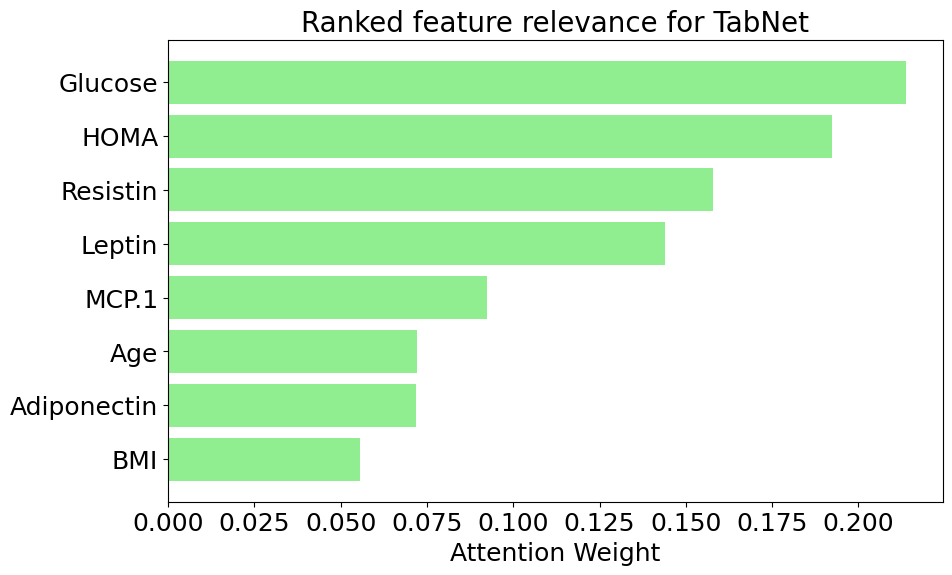

In [29]:
# visualising feature relevance by TabNet
sorted_features = [feature_names[idx] for idx in sorted_indices]
sorted_weights = [attention_weights[idx] for idx in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='lightgreen')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Attention Weight', fontsize=18)
plt.title('Ranked feature relevance for TabNet', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()

In [30]:
# 5. Rectifier Network

param_dist = {
    'hidden_layer_sizes': [(64, 128),(8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256), (32, 64, 128, 256), 
                           (64, 128, 256, 512), (128, 256, 512, 1024)],
    'max_iter': randint(1500, 3500),
    'early_stopping': [True],
    'n_iter_no_change': randint(100, 150),
    'validation_fraction': uniform(0.15, 0.25),
    'activation': ['relu'],
    'learning_rate_init': uniform(1e-5, 1e-3), 
    'alpha': uniform(1e-6, 1e-4),
    'beta_1': [0.9, 0.95, 0.85, 0.88],
    'beta_2': [0.999, 0.9999, 0.9995, 0.9999],
    'epsilon': [1e-8, 1e-9],
}

# Hyperparameter optimization
search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=RANDOM_STATE),
   param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Rectifier Network Training
search_mlp.fit(X_train_scaled, y_train)
best_params_mlp = search_mlp.best_params_
print("Best Parameters for MLP:", best_params_mlp)
print("Best f1 score for rectifier network during training: ",  search_mlp.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for MLP: {'activation': 'relu', 'alpha': 9.802519034770064e-06, 'beta_1': 0.85, 'beta_2': 0.9999, 'early_stopping': True, 'epsilon': 1e-09, 'hidden_layer_sizes': (128, 256, 512, 1024), 'learning_rate_init': 0.00010874432303199087, 'max_iter': 1750, 'n_iter_no_change': 116, 'validation_fraction': 0.2891161802534084}
Best f1 score for rectifier network during training:  0.8202756892230576


In [31]:
# Rectifier Network Testing
best_mlp_model =search_mlp.best_estimator_
y_pred_mlp =best_mlp_model.predict(X_test_scaled)

# Rectifier Network Performance Evaluation
print("\nEvaluation Metrics for Rectifier network:")
accuracy= accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_mlp)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_mlp)
print("Recall:", recall)
f1 = f1_score(y_test, best_mlp_model.predict(X_test))
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_mlp, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_mlp_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Rectifier network:
Accuracy: 0.7916666666666666
Precision: 0.9
Recall: 0.6923076923076923
F1 Score: 0.7428571428571429
F2 Score: 0.7258064516129032
AUC: 0.7552447552447552


C:\Users\de_de\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [32]:
#Feed fwd weights extraction- Local linear models_ interpretability
def mlp_relu_interpretation(model, x):
    w_list, b_list = model.coefs_, model.intercepts_

    layers = range(len(w_list))
    layer_j = np.copy(x)
    activation_pattern = []
    for j in layers:
        if j == len(w_list) - 1:
            continue
        layer_j = layer_j @ w_list[j] + b_list[j]
        layer_j[layer_j <= 0] = 0
        activation_pattern.extend(np.where(layer_j > 0))

    for j in layers:
        if j == 0:
            feature_weights_layer = w_list[j][:, activation_pattern[j]]
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif 0 < j < len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            layer_j_w_active_output = layer_j_w_active_input[:, activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]

    return feature_weights_layer, intercepts_layer

In [33]:
# Model prediction and  feed fwd weights(Local linear models) extraction- Interpretability
prediction = best_mlp_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_weights, intercepts = mlp_relu_interpretation(best_mlp_model, instance_to_explain)
feature_weights_tuples = [(feature_index, weight) for feature_index, weight in enumerate(feature_weights.flatten())]
sorted_feature_weights = sorted(feature_weights_tuples, key=lambda x: abs(x[1]), reverse=True)
feature_index_to_name = {i: name for i, name in enumerate(feature_names)}
sorted_feature_names = [feature_index_to_name.get(index, f'Unknown Feature {index}') for index, _ in sorted_feature_weights]
absolute_weights = [abs(weight) for _, weight in sorted_feature_weights]

Model Prediction: 1


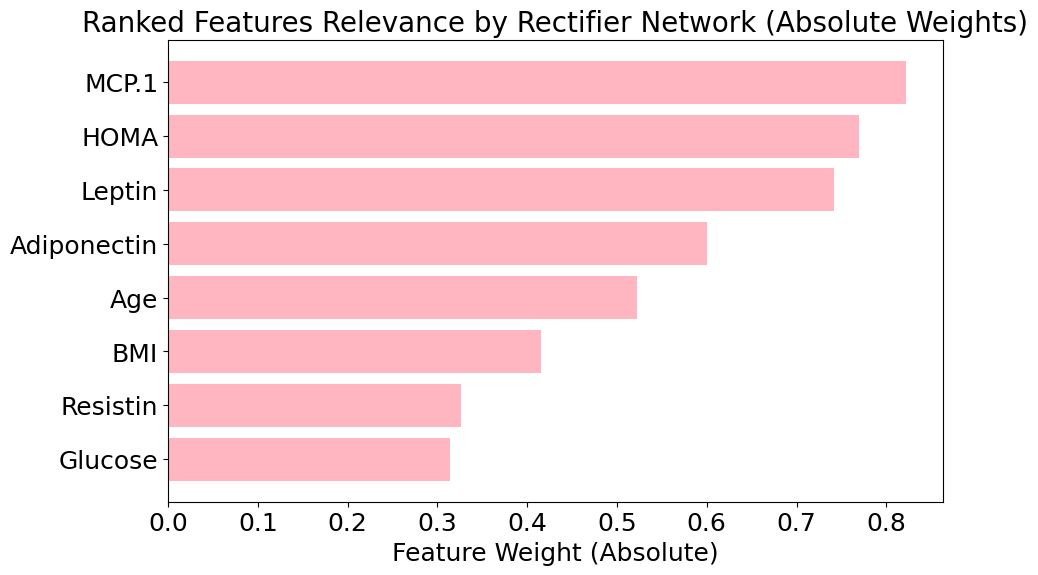

In [34]:
# Visualisation feature relevance by rectifier network
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, absolute_weights, color='lightpink')  
plt.gca().tick_params(labelsize=18) 
plt.xlabel('Feature Weight (Absolute)', fontsize=18)  
plt.title('Ranked Features Relevance by Rectifier Network (Absolute Weights)', fontsize=20)  
plt.gca().invert_yaxis()  
plt.show()
